In [1]:
# PyTorch
!pip install torchsummary
from torchsummary import summary
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset
from torch import optim
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import albumentations as A
from albumentations.pytorch import ToTensorV2

from collections import defaultdict

import random
from pathlib import Path
import sys
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2


### DATA LOADING AND PREPROCESSING

In [2]:
### here i will create the list of paths related to each one

train_list = []
test_list = []

root = '../input/cleaned-lfw/cleaned_lfw'
for i in os.listdir(root):
    imgs = glob(os.path.join(root, i, "*"))
    length = len(imgs)
    if (length==7):
        ratio = 0.7
    else:
        ratio=0.8
    train_div = int(ratio*length)
    train_list.append(imgs[0:train_div])
    test_list.append(imgs[train_div:])

In [3]:
def lenght(list_of_lists):
    count = 0
    for i in range(len(list_of_lists)):
        count +=len(list_of_lists[i])
    return count

In [4]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self, data_list, transform=None):
        self.list = data_list
        self.transform = transform
        
    def get_pair(self, data_list, positive):
        pair = []
        if positive:
            value = random.randint(0,255)
            id = [value, value]
            label = 1
        else:
            label = 0
            while True:
                id = [random.randint(0,255), random.randint(0,255)]
                if id[0] != id[1]:
                    break
        
        for i in range(2):
            filepath = ''
            while True:
                sub = self.list[id[i]]
                filepath = random.choice(sub)
                if not os.path.exists(filepath):
                    continue
                break
            pair.append(filepath)
        return pair, torch.tensor(label).long()
  
    def __getitem__(self,index):
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        path, label = self.get_pair(self.list, should_get_same_class)
        img0 = cv2.imread(path[0])
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        img1 = cv2.imread(path[1])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


        if self.transform is not None:
            img0 = self.transform(image=img0)["image"]
            img1 = self.transform(image=img1)["image"]
        
        img0 = img0/255.
        img1 = img1/255.
        return img0, img1, label 
    
    def __len__(self):
        return lenght(self.list)#essential for choose the num of data in one epoch

In [18]:
epochs = 600
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT+2, width=IMAGE_WIDTH+4, p=1),
    A.RandomCrop(width=IMAGE_WIDTH, height=IMAGE_HEIGHT,p=1),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10),
    A.OneOf([A.HueSaturationValue(p=0.4), A.RGBShift(p=0.4)], p=0.4),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])
val_transform = A.Compose([
                            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=1),
                            ToTensorV2()
                        ])



trainset = trainingDataset(train_list , transform=train_transform)
train_loader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=128)

valset = trainingDataset(test_list, transform=val_transform)
validation_loader = DataLoader(valset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=128)


## VISUALISATION

For visulaisation batch size= 8 else 128

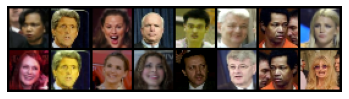

[0 1 1 0 0 1 1 0]


In [17]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    
dataiter = iter(train_loader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            

            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            
            nn.Conv2d(32, 32, kernel_size=3, stride = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        
        self.fc1 = nn.Linear(32*12*12, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)


    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.sub(output1, output2)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.fc3(output)
        return output

In [20]:
summary(SiameseNetwork().cuda(), [(3,32,32), (3,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
       BatchNorm2d-3           [-1, 64, 30, 30]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7           [-1, 32, 26, 26]          18,464
              ReLU-8           [-1, 32, 26, 26]               0
       BatchNorm2d-9           [-1, 32, 26, 26]              64
           Conv2d-10           [-1, 32, 12, 12]           9,248
             ReLU-11           [-1, 32, 12, 12]               0
      BatchNorm2d-12           [-1, 32, 12, 12]              64
           Linear-13                  [-1, 512]       2,359,808
           Conv2d-14           [-1, 64,

In [21]:
model = SiameseNetwork()
device = torch.device('cuda:0')
model = model.to(device)

criterion = nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005)

lambda1 = lambda iteration: ((0.0001 * iteration + 1) ** -0.75)

exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


iteration = 0

if os.path.exists('logs'):
    checkpoint = torch.load('logs')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    print('Restore model at epoch - ', epoch)

history = defaultdict(list) ## for storing histories
history['val_loss'].append(np.inf)
for i in range(epochs):
    val_acc = []
    val_loss = []
    train_acc = []
    train_loss = []
    
    
    model.train() # setting for training
    for batch_idx, data in enumerate(train_loader):
        
        
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.to(device), img1.to(device) , labels.to(device)#move to GPU
        optimizer.zero_grad()
        
        logits = model(img0, img1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        _, preds = torch.max(logits, 1)
        total = len(labels)
        correct = torch.sum(preds==labels)
        train_acc.append(correct.item()/total)
        iteration +=1
        print('Iteration: {}, learning rate: {:.5f}, Loss: {:.4f}, Accuracy:{:.3f}'.format(iteration, 
                                                                                       optimizer.param_groups[0]["lr"], 
                                                                                       loss.item(), correct.item()/total))
        exp_lr_scheduler.step()
    model.eval() # setting for training
    
    for batch_idx, data in enumerate(validation_loader):
        
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.to(device), img1.to(device) , labels.to(device)#move to GPU
        
        logits = model(img0, img1)
        loss = F.cross_entropy(logits, labels, reduction = 'sum')/len(img0)

        val_loss.append(loss.item())
        _, preds = torch.max(logits, 1)
        total = len(labels)
        correct = torch.sum(preds==labels)
        val_acc.append(correct.item()/total)  
    
    epoch_t_loss = np.mean(train_loss)
    epoch_t_acc = np.mean(train_acc)
    epoch_v_loss = np.mean(val_loss)
    epoch_v_acc = np.mean(val_acc)
    print('Epoch: {}, Loss: {:.4f}, Accuracy:{:.3f}, Val Loss: {:.4f}, Val Accuracy: {:.3f}'.format(
        i+1,  epoch_t_loss, epoch_t_acc , epoch_v_loss,  epoch_v_acc))
    
    history['loss'].append(epoch_t_loss)
    history['val_loss'].append(epoch_v_loss)
    history['acc'].append(epoch_t_acc)
    history['val_acc'].append(epoch_v_acc)
    if (history['val_loss'][-1]<min(history['val_loss'][:-1])):
        print('val_loss_decreased from {:.4f} to {:.4f}, saving_checkpoint for epoch {}'.format(min(history['val_loss'][:-1]), 
                                                                                                history['val_loss'][-1], i+1))
        torch.save({
                'epoch': i+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': exp_lr_scheduler.state_dict(),
                }, 'logs')


Iteration: 1, learning rate: 0.01000, Loss: 0.7390, Accuracy:0.406
Iteration: 2, learning rate: 0.01000, Loss: 0.7124, Accuracy:0.469
Iteration: 3, learning rate: 0.01000, Loss: 0.6838, Accuracy:0.523
Iteration: 4, learning rate: 0.01000, Loss: 0.6954, Accuracy:0.469
Iteration: 5, learning rate: 0.01000, Loss: 0.7014, Accuracy:0.445
Iteration: 6, learning rate: 0.01000, Loss: 0.6944, Accuracy:0.508
Iteration: 7, learning rate: 0.01000, Loss: 0.6971, Accuracy:0.445
Iteration: 8, learning rate: 0.00999, Loss: 0.6901, Accuracy:0.562
Iteration: 9, learning rate: 0.00999, Loss: 0.6966, Accuracy:0.469
Iteration: 10, learning rate: 0.00999, Loss: 0.6901, Accuracy:0.555
Iteration: 11, learning rate: 0.00999, Loss: 0.6954, Accuracy:0.531
Iteration: 12, learning rate: 0.00999, Loss: 0.6892, Accuracy:0.531
Iteration: 13, learning rate: 0.00999, Loss: 0.6913, Accuracy:0.508
Iteration: 14, learning rate: 0.00999, Loss: 0.6851, Accuracy:0.547
Iteration: 15, learning rate: 0.00999, Loss: 0.6861, Accu

Iteration: 116, learning rate: 0.00991, Loss: 0.6145, Accuracy:0.625
Iteration: 117, learning rate: 0.00991, Loss: 0.6224, Accuracy:0.641
Iteration: 118, learning rate: 0.00991, Loss: 0.6714, Accuracy:0.594
Iteration: 119, learning rate: 0.00991, Loss: 0.6393, Accuracy:0.672
Iteration: 120, learning rate: 0.00991, Loss: 0.6191, Accuracy:0.648
Iteration: 121, learning rate: 0.00991, Loss: 0.6328, Accuracy:0.648
Iteration: 122, learning rate: 0.00991, Loss: 0.6039, Accuracy:0.703
Iteration: 123, learning rate: 0.00991, Loss: 0.6362, Accuracy:0.617
Iteration: 124, learning rate: 0.00991, Loss: 0.5650, Accuracy:0.667
Epoch: 4, Loss: 0.6303, Accuracy:0.641, Val Loss: 0.5773, Val Accuracy: 0.730
val_loss_decreased from 0.6091 to 0.5773, saving_checkpoint for epoch 4
Iteration: 125, learning rate: 0.00991, Loss: 0.5815, Accuracy:0.703
Iteration: 126, learning rate: 0.00991, Loss: 0.5604, Accuracy:0.711
Iteration: 127, learning rate: 0.00991, Loss: 0.6297, Accuracy:0.656
Iteration: 128, learni

Iteration: 230, learning rate: 0.00983, Loss: 0.6011, Accuracy:0.680
Iteration: 231, learning rate: 0.00983, Loss: 0.5433, Accuracy:0.750
Iteration: 232, learning rate: 0.00983, Loss: 0.6171, Accuracy:0.648
Iteration: 233, learning rate: 0.00983, Loss: 0.6001, Accuracy:0.695
Iteration: 234, learning rate: 0.00983, Loss: 0.5165, Accuracy:0.758
Iteration: 235, learning rate: 0.00983, Loss: 0.6382, Accuracy:0.625
Iteration: 236, learning rate: 0.00983, Loss: 0.5868, Accuracy:0.688
Iteration: 237, learning rate: 0.00983, Loss: 0.5593, Accuracy:0.742
Iteration: 238, learning rate: 0.00983, Loss: 0.5768, Accuracy:0.711
Iteration: 239, learning rate: 0.00983, Loss: 0.6132, Accuracy:0.664
Iteration: 240, learning rate: 0.00982, Loss: 0.5283, Accuracy:0.789
Iteration: 241, learning rate: 0.00982, Loss: 0.5739, Accuracy:0.711
Iteration: 242, learning rate: 0.00982, Loss: 0.5489, Accuracy:0.688
Iteration: 243, learning rate: 0.00982, Loss: 0.5920, Accuracy:0.703
Iteration: 244, learning rate: 0.0

Iteration: 346, learning rate: 0.00975, Loss: 0.6217, Accuracy:0.648
Iteration: 347, learning rate: 0.00975, Loss: 0.6233, Accuracy:0.648
Iteration: 348, learning rate: 0.00975, Loss: 0.5832, Accuracy:0.664
Iteration: 349, learning rate: 0.00975, Loss: 0.5458, Accuracy:0.734
Iteration: 350, learning rate: 0.00975, Loss: 0.5243, Accuracy:0.750
Iteration: 351, learning rate: 0.00975, Loss: 0.5453, Accuracy:0.719
Iteration: 352, learning rate: 0.00974, Loss: 0.5872, Accuracy:0.695
Iteration: 353, learning rate: 0.00974, Loss: 0.5377, Accuracy:0.719
Iteration: 354, learning rate: 0.00974, Loss: 0.5985, Accuracy:0.656
Iteration: 355, learning rate: 0.00974, Loss: 0.5646, Accuracy:0.734
Iteration: 356, learning rate: 0.00974, Loss: 0.5187, Accuracy:0.727
Iteration: 357, learning rate: 0.00974, Loss: 0.5946, Accuracy:0.648
Iteration: 358, learning rate: 0.00974, Loss: 0.5858, Accuracy:0.695
Iteration: 359, learning rate: 0.00974, Loss: 0.5330, Accuracy:0.742
Iteration: 360, learning rate: 0.0

Epoch: 15, Loss: 0.5303, Accuracy:0.731, Val Loss: 0.5235, Val Accuracy: 0.721
Iteration: 466, learning rate: 0.00966, Loss: 0.5231, Accuracy:0.734
Iteration: 467, learning rate: 0.00966, Loss: 0.5800, Accuracy:0.688
Iteration: 468, learning rate: 0.00966, Loss: 0.6187, Accuracy:0.688
Iteration: 469, learning rate: 0.00966, Loss: 0.5346, Accuracy:0.719
Iteration: 470, learning rate: 0.00966, Loss: 0.5041, Accuracy:0.727
Iteration: 471, learning rate: 0.00966, Loss: 0.6127, Accuracy:0.672
Iteration: 472, learning rate: 0.00966, Loss: 0.4853, Accuracy:0.797
Iteration: 473, learning rate: 0.00966, Loss: 0.5519, Accuracy:0.703
Iteration: 474, learning rate: 0.00966, Loss: 0.5756, Accuracy:0.688
Iteration: 475, learning rate: 0.00966, Loss: 0.5977, Accuracy:0.680
Iteration: 476, learning rate: 0.00966, Loss: 0.5849, Accuracy:0.680
Iteration: 477, learning rate: 0.00966, Loss: 0.5491, Accuracy:0.734
Iteration: 478, learning rate: 0.00966, Loss: 0.5948, Accuracy:0.680
Iteration: 479, learning

Iteration: 582, learning rate: 0.00959, Loss: 0.4969, Accuracy:0.742
Iteration: 583, learning rate: 0.00958, Loss: 0.5325, Accuracy:0.742
Iteration: 584, learning rate: 0.00958, Loss: 0.5415, Accuracy:0.695
Iteration: 585, learning rate: 0.00958, Loss: 0.5043, Accuracy:0.789
Iteration: 586, learning rate: 0.00958, Loss: 0.5002, Accuracy:0.734
Iteration: 587, learning rate: 0.00958, Loss: 0.5495, Accuracy:0.766
Iteration: 588, learning rate: 0.00958, Loss: 0.4495, Accuracy:0.867
Iteration: 589, learning rate: 0.00958, Loss: 0.5559, Accuracy:0.742
Epoch: 19, Loss: 0.5235, Accuracy:0.740, Val Loss: 0.4705, Val Accuracy: 0.751
Iteration: 590, learning rate: 0.00958, Loss: 0.5025, Accuracy:0.758
Iteration: 591, learning rate: 0.00958, Loss: 0.5668, Accuracy:0.688
Iteration: 592, learning rate: 0.00958, Loss: 0.4587, Accuracy:0.766
Iteration: 593, learning rate: 0.00958, Loss: 0.4612, Accuracy:0.820
Iteration: 594, learning rate: 0.00958, Loss: 0.4903, Accuracy:0.781
Iteration: 595, learning

Iteration: 698, learning rate: 0.00951, Loss: 0.4334, Accuracy:0.836
Iteration: 699, learning rate: 0.00951, Loss: 0.5037, Accuracy:0.773
Iteration: 700, learning rate: 0.00951, Loss: 0.4889, Accuracy:0.766
Iteration: 701, learning rate: 0.00951, Loss: 0.4779, Accuracy:0.773
Iteration: 702, learning rate: 0.00950, Loss: 0.5226, Accuracy:0.742
Iteration: 703, learning rate: 0.00950, Loss: 0.4709, Accuracy:0.758
Iteration: 704, learning rate: 0.00950, Loss: 0.5729, Accuracy:0.727
Iteration: 705, learning rate: 0.00950, Loss: 0.5028, Accuracy:0.750
Iteration: 706, learning rate: 0.00950, Loss: 0.4773, Accuracy:0.797
Iteration: 707, learning rate: 0.00950, Loss: 0.4951, Accuracy:0.727
Iteration: 708, learning rate: 0.00950, Loss: 0.5274, Accuracy:0.742
Iteration: 709, learning rate: 0.00950, Loss: 0.3971, Accuracy:0.852
Iteration: 710, learning rate: 0.00950, Loss: 0.5498, Accuracy:0.664
Iteration: 711, learning rate: 0.00950, Loss: 0.4736, Accuracy:0.789
Iteration: 712, learning rate: 0.0

Iteration: 815, learning rate: 0.00943, Loss: 0.5574, Accuracy:0.688
Iteration: 816, learning rate: 0.00943, Loss: 0.4849, Accuracy:0.773
Iteration: 817, learning rate: 0.00943, Loss: 0.5032, Accuracy:0.781
Iteration: 818, learning rate: 0.00943, Loss: 0.4746, Accuracy:0.766
Iteration: 819, learning rate: 0.00943, Loss: 0.5100, Accuracy:0.758
Iteration: 820, learning rate: 0.00943, Loss: 0.5090, Accuracy:0.758
Iteration: 821, learning rate: 0.00943, Loss: 0.4956, Accuracy:0.750
Iteration: 822, learning rate: 0.00943, Loss: 0.5134, Accuracy:0.781
Iteration: 823, learning rate: 0.00942, Loss: 0.4822, Accuracy:0.742
Iteration: 824, learning rate: 0.00942, Loss: 0.5103, Accuracy:0.734
Iteration: 825, learning rate: 0.00942, Loss: 0.4816, Accuracy:0.781
Iteration: 826, learning rate: 0.00942, Loss: 0.5418, Accuracy:0.695
Iteration: 827, learning rate: 0.00942, Loss: 0.4382, Accuracy:0.797
Iteration: 828, learning rate: 0.00942, Loss: 0.4385, Accuracy:0.805
Iteration: 829, learning rate: 0.0

Epoch: 30, Loss: 0.4906, Accuracy:0.759, Val Loss: 0.4570, Val Accuracy: 0.769
Iteration: 931, learning rate: 0.00935, Loss: 0.5147, Accuracy:0.719
Iteration: 932, learning rate: 0.00935, Loss: 0.5303, Accuracy:0.734
Iteration: 933, learning rate: 0.00935, Loss: 0.5282, Accuracy:0.703
Iteration: 934, learning rate: 0.00935, Loss: 0.4153, Accuracy:0.828
Iteration: 935, learning rate: 0.00935, Loss: 0.4479, Accuracy:0.773
Iteration: 936, learning rate: 0.00935, Loss: 0.4900, Accuracy:0.758
Iteration: 937, learning rate: 0.00935, Loss: 0.5139, Accuracy:0.766
Iteration: 938, learning rate: 0.00935, Loss: 0.4683, Accuracy:0.797
Iteration: 939, learning rate: 0.00935, Loss: 0.4829, Accuracy:0.773
Iteration: 940, learning rate: 0.00935, Loss: 0.3682, Accuracy:0.867
Iteration: 941, learning rate: 0.00935, Loss: 0.4744, Accuracy:0.781
Iteration: 942, learning rate: 0.00935, Loss: 0.5173, Accuracy:0.742
Iteration: 943, learning rate: 0.00935, Loss: 0.4614, Accuracy:0.758
Iteration: 944, learning

Iteration: 1044, learning rate: 0.00928, Loss: 0.4712, Accuracy:0.758
Iteration: 1045, learning rate: 0.00928, Loss: 0.5073, Accuracy:0.766
Iteration: 1046, learning rate: 0.00928, Loss: 0.4578, Accuracy:0.758
Iteration: 1047, learning rate: 0.00928, Loss: 0.4075, Accuracy:0.820
Iteration: 1048, learning rate: 0.00928, Loss: 0.4394, Accuracy:0.844
Iteration: 1049, learning rate: 0.00928, Loss: 0.4758, Accuracy:0.758
Iteration: 1050, learning rate: 0.00928, Loss: 0.4281, Accuracy:0.781
Iteration: 1051, learning rate: 0.00928, Loss: 0.4739, Accuracy:0.797
Iteration: 1052, learning rate: 0.00928, Loss: 0.4751, Accuracy:0.703
Iteration: 1053, learning rate: 0.00928, Loss: 0.4686, Accuracy:0.773
Iteration: 1054, learning rate: 0.00928, Loss: 0.4664, Accuracy:0.774
Epoch: 34, Loss: 0.4679, Accuracy:0.780, Val Loss: 0.4356, Val Accuracy: 0.772
Iteration: 1055, learning rate: 0.00928, Loss: 0.5552, Accuracy:0.719
Iteration: 1056, learning rate: 0.00928, Loss: 0.4143, Accuracy:0.805
Iteration: 

Iteration: 1157, learning rate: 0.00921, Loss: 0.4481, Accuracy:0.797
Iteration: 1158, learning rate: 0.00921, Loss: 0.4523, Accuracy:0.805
Iteration: 1159, learning rate: 0.00921, Loss: 0.4818, Accuracy:0.734
Iteration: 1160, learning rate: 0.00921, Loss: 0.4405, Accuracy:0.812
Iteration: 1161, learning rate: 0.00921, Loss: 0.4075, Accuracy:0.812
Iteration: 1162, learning rate: 0.00921, Loss: 0.4723, Accuracy:0.805
Iteration: 1163, learning rate: 0.00921, Loss: 0.4343, Accuracy:0.766
Iteration: 1164, learning rate: 0.00921, Loss: 0.3939, Accuracy:0.812
Iteration: 1165, learning rate: 0.00921, Loss: 0.3610, Accuracy:0.867
Iteration: 1166, learning rate: 0.00921, Loss: 0.5100, Accuracy:0.781
Iteration: 1167, learning rate: 0.00921, Loss: 0.4581, Accuracy:0.773
Iteration: 1168, learning rate: 0.00921, Loss: 0.4687, Accuracy:0.781
Iteration: 1169, learning rate: 0.00920, Loss: 0.4370, Accuracy:0.797
Iteration: 1170, learning rate: 0.00920, Loss: 0.4086, Accuracy:0.836
Iteration: 1171, lea

Epoch: 41, Loss: 0.4405, Accuracy:0.789, Val Loss: 0.4233, Val Accuracy: 0.790
Iteration: 1272, learning rate: 0.00914, Loss: 0.4777, Accuracy:0.750
Iteration: 1273, learning rate: 0.00914, Loss: 0.4796, Accuracy:0.781
Iteration: 1274, learning rate: 0.00914, Loss: 0.4746, Accuracy:0.797
Iteration: 1275, learning rate: 0.00914, Loss: 0.4473, Accuracy:0.766
Iteration: 1276, learning rate: 0.00914, Loss: 0.5532, Accuracy:0.734
Iteration: 1277, learning rate: 0.00914, Loss: 0.4871, Accuracy:0.750
Iteration: 1278, learning rate: 0.00914, Loss: 0.4756, Accuracy:0.742
Iteration: 1279, learning rate: 0.00914, Loss: 0.4642, Accuracy:0.773
Iteration: 1280, learning rate: 0.00914, Loss: 0.3849, Accuracy:0.852
Iteration: 1281, learning rate: 0.00914, Loss: 0.5272, Accuracy:0.734
Iteration: 1282, learning rate: 0.00914, Loss: 0.4043, Accuracy:0.812
Iteration: 1283, learning rate: 0.00914, Loss: 0.5137, Accuracy:0.742
Iteration: 1284, learning rate: 0.00913, Loss: 0.4817, Accuracy:0.734
Iteration: 

Iteration: 1384, learning rate: 0.00907, Loss: 0.4375, Accuracy:0.805
Iteration: 1385, learning rate: 0.00907, Loss: 0.4392, Accuracy:0.781
Iteration: 1386, learning rate: 0.00907, Loss: 0.3496, Accuracy:0.883
Iteration: 1387, learning rate: 0.00907, Loss: 0.4770, Accuracy:0.750
Iteration: 1388, learning rate: 0.00907, Loss: 0.4264, Accuracy:0.773
Iteration: 1389, learning rate: 0.00907, Loss: 0.4182, Accuracy:0.812
Iteration: 1390, learning rate: 0.00907, Loss: 0.4276, Accuracy:0.797
Iteration: 1391, learning rate: 0.00907, Loss: 0.4468, Accuracy:0.750
Iteration: 1392, learning rate: 0.00907, Loss: 0.3793, Accuracy:0.836
Iteration: 1393, learning rate: 0.00907, Loss: 0.3992, Accuracy:0.844
Iteration: 1394, learning rate: 0.00907, Loss: 0.4043, Accuracy:0.836
Iteration: 1395, learning rate: 0.00907, Loss: 0.5346, Accuracy:0.731
Epoch: 45, Loss: 0.4430, Accuracy:0.794, Val Loss: 0.3834, Val Accuracy: 0.823
val_loss_decreased from 0.3904 to 0.3834, saving_checkpoint for epoch 45
Iteratio

Iteration: 1496, learning rate: 0.00901, Loss: 0.3893, Accuracy:0.805
Iteration: 1497, learning rate: 0.00901, Loss: 0.4415, Accuracy:0.781
Iteration: 1498, learning rate: 0.00901, Loss: 0.4123, Accuracy:0.820
Iteration: 1499, learning rate: 0.00901, Loss: 0.4309, Accuracy:0.812
Iteration: 1500, learning rate: 0.00901, Loss: 0.4108, Accuracy:0.805
Iteration: 1501, learning rate: 0.00900, Loss: 0.4244, Accuracy:0.797
Iteration: 1502, learning rate: 0.00900, Loss: 0.4598, Accuracy:0.766
Iteration: 1503, learning rate: 0.00900, Loss: 0.4388, Accuracy:0.805
Iteration: 1504, learning rate: 0.00900, Loss: 0.3310, Accuracy:0.867
Iteration: 1505, learning rate: 0.00900, Loss: 0.3773, Accuracy:0.820
Iteration: 1506, learning rate: 0.00900, Loss: 0.4225, Accuracy:0.781
Iteration: 1507, learning rate: 0.00900, Loss: 0.4647, Accuracy:0.773
Iteration: 1508, learning rate: 0.00900, Loss: 0.3747, Accuracy:0.852
Iteration: 1509, learning rate: 0.00900, Loss: 0.3749, Accuracy:0.844
Iteration: 1510, lea

Epoch: 52, Loss: 0.4200, Accuracy:0.799, Val Loss: 0.3542, Val Accuracy: 0.833
val_loss_decreased from 0.3722 to 0.3542, saving_checkpoint for epoch 52
Iteration: 1613, learning rate: 0.00894, Loss: 0.4991, Accuracy:0.758
Iteration: 1614, learning rate: 0.00894, Loss: 0.3840, Accuracy:0.844
Iteration: 1615, learning rate: 0.00894, Loss: 0.4408, Accuracy:0.766
Iteration: 1616, learning rate: 0.00894, Loss: 0.3073, Accuracy:0.867
Iteration: 1617, learning rate: 0.00894, Loss: 0.4502, Accuracy:0.781
Iteration: 1618, learning rate: 0.00894, Loss: 0.4238, Accuracy:0.781
Iteration: 1619, learning rate: 0.00894, Loss: 0.4662, Accuracy:0.789
Iteration: 1620, learning rate: 0.00894, Loss: 0.4359, Accuracy:0.812
Iteration: 1621, learning rate: 0.00894, Loss: 0.4310, Accuracy:0.789
Iteration: 1622, learning rate: 0.00893, Loss: 0.3854, Accuracy:0.852
Iteration: 1623, learning rate: 0.00893, Loss: 0.4174, Accuracy:0.828
Iteration: 1624, learning rate: 0.00893, Loss: 0.3331, Accuracy:0.828
Iteratio

Iteration: 1726, learning rate: 0.00887, Loss: 0.3823, Accuracy:0.844
Iteration: 1727, learning rate: 0.00887, Loss: 0.3762, Accuracy:0.844
Iteration: 1728, learning rate: 0.00887, Loss: 0.4414, Accuracy:0.797
Iteration: 1729, learning rate: 0.00887, Loss: 0.4229, Accuracy:0.773
Iteration: 1730, learning rate: 0.00887, Loss: 0.3545, Accuracy:0.852
Iteration: 1731, learning rate: 0.00887, Loss: 0.4213, Accuracy:0.805
Iteration: 1732, learning rate: 0.00887, Loss: 0.4202, Accuracy:0.812
Iteration: 1733, learning rate: 0.00887, Loss: 0.4741, Accuracy:0.766
Iteration: 1734, learning rate: 0.00887, Loss: 0.4181, Accuracy:0.820
Iteration: 1735, learning rate: 0.00887, Loss: 0.4332, Accuracy:0.773
Iteration: 1736, learning rate: 0.00887, Loss: 0.3246, Accuracy:0.871
Epoch: 56, Loss: 0.4055, Accuracy:0.815, Val Loss: 0.3918, Val Accuracy: 0.806
Iteration: 1737, learning rate: 0.00887, Loss: 0.3990, Accuracy:0.828
Iteration: 1738, learning rate: 0.00887, Loss: 0.3831, Accuracy:0.805
Iteration: 

Iteration: 1841, learning rate: 0.00881, Loss: 0.3550, Accuracy:0.844
Iteration: 1842, learning rate: 0.00881, Loss: 0.4059, Accuracy:0.781
Iteration: 1843, learning rate: 0.00881, Loss: 0.3731, Accuracy:0.859
Iteration: 1844, learning rate: 0.00881, Loss: 0.4345, Accuracy:0.828
Iteration: 1845, learning rate: 0.00881, Loss: 0.5301, Accuracy:0.766
Iteration: 1846, learning rate: 0.00881, Loss: 0.3727, Accuracy:0.844
Iteration: 1847, learning rate: 0.00881, Loss: 0.3943, Accuracy:0.844
Iteration: 1848, learning rate: 0.00881, Loss: 0.4396, Accuracy:0.828
Iteration: 1849, learning rate: 0.00881, Loss: 0.3939, Accuracy:0.852
Iteration: 1850, learning rate: 0.00881, Loss: 0.4106, Accuracy:0.805
Iteration: 1851, learning rate: 0.00880, Loss: 0.3871, Accuracy:0.820
Iteration: 1852, learning rate: 0.00880, Loss: 0.4962, Accuracy:0.711
Iteration: 1853, learning rate: 0.00880, Loss: 0.3259, Accuracy:0.883
Iteration: 1854, learning rate: 0.00880, Loss: 0.4089, Accuracy:0.789
Iteration: 1855, lea

Iteration: 1954, learning rate: 0.00875, Loss: 0.4512, Accuracy:0.836
Iteration: 1955, learning rate: 0.00875, Loss: 0.4400, Accuracy:0.781
Iteration: 1956, learning rate: 0.00875, Loss: 0.4120, Accuracy:0.820
Iteration: 1957, learning rate: 0.00875, Loss: 0.3891, Accuracy:0.852
Iteration: 1958, learning rate: 0.00875, Loss: 0.3027, Accuracy:0.867
Iteration: 1959, learning rate: 0.00874, Loss: 0.4745, Accuracy:0.789
Iteration: 1960, learning rate: 0.00874, Loss: 0.4070, Accuracy:0.805
Iteration: 1961, learning rate: 0.00874, Loss: 0.3446, Accuracy:0.812
Iteration: 1962, learning rate: 0.00874, Loss: 0.3417, Accuracy:0.867
Iteration: 1963, learning rate: 0.00874, Loss: 0.3704, Accuracy:0.828
Iteration: 1964, learning rate: 0.00874, Loss: 0.3508, Accuracy:0.844
Iteration: 1965, learning rate: 0.00874, Loss: 0.3849, Accuracy:0.820
Iteration: 1966, learning rate: 0.00874, Loss: 0.3621, Accuracy:0.852
Iteration: 1967, learning rate: 0.00874, Loss: 0.4307, Accuracy:0.789
Iteration: 1968, lea

Iteration: 2070, learning rate: 0.00868, Loss: 0.4369, Accuracy:0.781
Iteration: 2071, learning rate: 0.00868, Loss: 0.3576, Accuracy:0.844
Iteration: 2072, learning rate: 0.00868, Loss: 0.3540, Accuracy:0.844
Iteration: 2073, learning rate: 0.00868, Loss: 0.3998, Accuracy:0.805
Iteration: 2074, learning rate: 0.00868, Loss: 0.2944, Accuracy:0.875
Iteration: 2075, learning rate: 0.00868, Loss: 0.4044, Accuracy:0.812
Iteration: 2076, learning rate: 0.00868, Loss: 0.3128, Accuracy:0.867
Iteration: 2077, learning rate: 0.00868, Loss: 0.3283, Accuracy:0.871
Epoch: 67, Loss: 0.3674, Accuracy:0.834, Val Loss: 0.3885, Val Accuracy: 0.821
Iteration: 2078, learning rate: 0.00868, Loss: 0.3085, Accuracy:0.875
Iteration: 2079, learning rate: 0.00868, Loss: 0.3176, Accuracy:0.852
Iteration: 2080, learning rate: 0.00868, Loss: 0.3064, Accuracy:0.891
Iteration: 2081, learning rate: 0.00868, Loss: 0.3688, Accuracy:0.859
Iteration: 2082, learning rate: 0.00868, Loss: 0.3773, Accuracy:0.820
Iteration: 

Iteration: 2186, learning rate: 0.00862, Loss: 0.4487, Accuracy:0.758
Iteration: 2187, learning rate: 0.00862, Loss: 0.3181, Accuracy:0.836
Iteration: 2188, learning rate: 0.00862, Loss: 0.2920, Accuracy:0.867
Iteration: 2189, learning rate: 0.00862, Loss: 0.4405, Accuracy:0.797
Iteration: 2190, learning rate: 0.00862, Loss: 0.3957, Accuracy:0.828
Iteration: 2191, learning rate: 0.00862, Loss: 0.3936, Accuracy:0.797
Iteration: 2192, learning rate: 0.00862, Loss: 0.3626, Accuracy:0.812
Iteration: 2193, learning rate: 0.00862, Loss: 0.2916, Accuracy:0.867
Iteration: 2194, learning rate: 0.00862, Loss: 0.3791, Accuracy:0.852
Iteration: 2195, learning rate: 0.00862, Loss: 0.4313, Accuracy:0.781
Iteration: 2196, learning rate: 0.00862, Loss: 0.3053, Accuracy:0.852
Iteration: 2197, learning rate: 0.00862, Loss: 0.3470, Accuracy:0.820
Iteration: 2198, learning rate: 0.00862, Loss: 0.4131, Accuracy:0.820
Iteration: 2199, learning rate: 0.00862, Loss: 0.3511, Accuracy:0.812
Iteration: 2200, lea

Iteration: 2299, learning rate: 0.00856, Loss: 0.4672, Accuracy:0.758
Iteration: 2300, learning rate: 0.00856, Loss: 0.4288, Accuracy:0.789
Iteration: 2301, learning rate: 0.00856, Loss: 0.3874, Accuracy:0.836
Iteration: 2302, learning rate: 0.00856, Loss: 0.2679, Accuracy:0.875
Iteration: 2303, learning rate: 0.00856, Loss: 0.3246, Accuracy:0.859
Iteration: 2304, learning rate: 0.00856, Loss: 0.3895, Accuracy:0.836
Iteration: 2305, learning rate: 0.00856, Loss: 0.3065, Accuracy:0.859
Iteration: 2306, learning rate: 0.00856, Loss: 0.3973, Accuracy:0.828
Iteration: 2307, learning rate: 0.00856, Loss: 0.3650, Accuracy:0.836
Iteration: 2308, learning rate: 0.00856, Loss: 0.3760, Accuracy:0.836
Iteration: 2309, learning rate: 0.00856, Loss: 0.4317, Accuracy:0.812
Iteration: 2310, learning rate: 0.00856, Loss: 0.3158, Accuracy:0.867
Iteration: 2311, learning rate: 0.00856, Loss: 0.3603, Accuracy:0.852
Iteration: 2312, learning rate: 0.00856, Loss: 0.3084, Accuracy:0.867
Iteration: 2313, lea

Iteration: 2412, learning rate: 0.00850, Loss: 0.3783, Accuracy:0.867
Iteration: 2413, learning rate: 0.00850, Loss: 0.3688, Accuracy:0.844
Iteration: 2414, learning rate: 0.00850, Loss: 0.3824, Accuracy:0.844
Iteration: 2415, learning rate: 0.00850, Loss: 0.5100, Accuracy:0.766
Iteration: 2416, learning rate: 0.00850, Loss: 0.3310, Accuracy:0.844
Iteration: 2417, learning rate: 0.00850, Loss: 0.3360, Accuracy:0.852
Iteration: 2418, learning rate: 0.00850, Loss: 0.4351, Accuracy:0.796
Epoch: 78, Loss: 0.3697, Accuracy:0.838, Val Loss: 0.4034, Val Accuracy: 0.813
Iteration: 2419, learning rate: 0.00850, Loss: 0.3377, Accuracy:0.828
Iteration: 2420, learning rate: 0.00850, Loss: 0.3580, Accuracy:0.797
Iteration: 2421, learning rate: 0.00850, Loss: 0.3450, Accuracy:0.836
Iteration: 2422, learning rate: 0.00850, Loss: 0.2965, Accuracy:0.859
Iteration: 2423, learning rate: 0.00850, Loss: 0.3663, Accuracy:0.836
Iteration: 2424, learning rate: 0.00850, Loss: 0.3755, Accuracy:0.812
Iteration: 

Iteration: 2525, learning rate: 0.00845, Loss: 0.3076, Accuracy:0.891
Iteration: 2526, learning rate: 0.00845, Loss: 0.3051, Accuracy:0.859
Iteration: 2527, learning rate: 0.00845, Loss: 0.3516, Accuracy:0.844
Iteration: 2528, learning rate: 0.00845, Loss: 0.2757, Accuracy:0.898
Iteration: 2529, learning rate: 0.00844, Loss: 0.3933, Accuracy:0.844
Iteration: 2530, learning rate: 0.00844, Loss: 0.3372, Accuracy:0.867
Iteration: 2531, learning rate: 0.00844, Loss: 0.2578, Accuracy:0.914
Iteration: 2532, learning rate: 0.00844, Loss: 0.3162, Accuracy:0.867
Iteration: 2533, learning rate: 0.00844, Loss: 0.4039, Accuracy:0.820
Iteration: 2534, learning rate: 0.00844, Loss: 0.3716, Accuracy:0.812
Iteration: 2535, learning rate: 0.00844, Loss: 0.3928, Accuracy:0.836
Iteration: 2536, learning rate: 0.00844, Loss: 0.4179, Accuracy:0.844
Iteration: 2537, learning rate: 0.00844, Loss: 0.2798, Accuracy:0.898
Iteration: 2538, learning rate: 0.00844, Loss: 0.2726, Accuracy:0.898
Iteration: 2539, lea

Iteration: 2639, learning rate: 0.00839, Loss: 0.3571, Accuracy:0.859
Iteration: 2640, learning rate: 0.00839, Loss: 0.3063, Accuracy:0.852
Iteration: 2641, learning rate: 0.00839, Loss: 0.3523, Accuracy:0.828
Iteration: 2642, learning rate: 0.00839, Loss: 0.3499, Accuracy:0.844
Iteration: 2643, learning rate: 0.00839, Loss: 0.3242, Accuracy:0.883
Iteration: 2644, learning rate: 0.00839, Loss: 0.3390, Accuracy:0.875
Iteration: 2645, learning rate: 0.00839, Loss: 0.2832, Accuracy:0.883
Iteration: 2646, learning rate: 0.00839, Loss: 0.3411, Accuracy:0.828
Iteration: 2647, learning rate: 0.00839, Loss: 0.4367, Accuracy:0.797
Iteration: 2648, learning rate: 0.00839, Loss: 0.3658, Accuracy:0.836
Iteration: 2649, learning rate: 0.00838, Loss: 0.3196, Accuracy:0.883
Iteration: 2650, learning rate: 0.00838, Loss: 0.3021, Accuracy:0.852
Iteration: 2651, learning rate: 0.00838, Loss: 0.2893, Accuracy:0.875
Iteration: 2652, learning rate: 0.00838, Loss: 0.3246, Accuracy:0.836
Iteration: 2653, lea

Iteration: 2752, learning rate: 0.00833, Loss: 0.3168, Accuracy:0.898
Iteration: 2753, learning rate: 0.00833, Loss: 0.3789, Accuracy:0.812
Iteration: 2754, learning rate: 0.00833, Loss: 0.3993, Accuracy:0.828
Iteration: 2755, learning rate: 0.00833, Loss: 0.3680, Accuracy:0.781
Iteration: 2756, learning rate: 0.00833, Loss: 0.2815, Accuracy:0.875
Iteration: 2757, learning rate: 0.00833, Loss: 0.4535, Accuracy:0.781
Iteration: 2758, learning rate: 0.00833, Loss: 0.3571, Accuracy:0.836
Iteration: 2759, learning rate: 0.00833, Loss: 0.3244, Accuracy:0.860
Epoch: 89, Loss: 0.3517, Accuracy:0.845, Val Loss: 0.3375, Val Accuracy: 0.860
Iteration: 2760, learning rate: 0.00833, Loss: 0.2999, Accuracy:0.898
Iteration: 2761, learning rate: 0.00833, Loss: 0.3244, Accuracy:0.883
Iteration: 2762, learning rate: 0.00833, Loss: 0.3929, Accuracy:0.836
Iteration: 2763, learning rate: 0.00833, Loss: 0.3310, Accuracy:0.844
Iteration: 2764, learning rate: 0.00833, Loss: 0.2889, Accuracy:0.875
Iteration: 

Iteration: 2868, learning rate: 0.00828, Loss: 0.2685, Accuracy:0.891
Iteration: 2869, learning rate: 0.00828, Loss: 0.3441, Accuracy:0.812
Iteration: 2870, learning rate: 0.00828, Loss: 0.3281, Accuracy:0.867
Iteration: 2871, learning rate: 0.00828, Loss: 0.3206, Accuracy:0.859
Iteration: 2872, learning rate: 0.00828, Loss: 0.3063, Accuracy:0.859
Iteration: 2873, learning rate: 0.00827, Loss: 0.2362, Accuracy:0.914
Iteration: 2874, learning rate: 0.00827, Loss: 0.2450, Accuracy:0.914
Iteration: 2875, learning rate: 0.00827, Loss: 0.2329, Accuracy:0.922
Iteration: 2876, learning rate: 0.00827, Loss: 0.3759, Accuracy:0.836
Iteration: 2877, learning rate: 0.00827, Loss: 0.3222, Accuracy:0.883
Iteration: 2878, learning rate: 0.00827, Loss: 0.3253, Accuracy:0.844
Iteration: 2879, learning rate: 0.00827, Loss: 0.2911, Accuracy:0.891
Iteration: 2880, learning rate: 0.00827, Loss: 0.3365, Accuracy:0.867
Iteration: 2881, learning rate: 0.00827, Loss: 0.2970, Accuracy:0.875
Iteration: 2882, lea

Iteration: 2981, learning rate: 0.00822, Loss: 0.3392, Accuracy:0.852
Iteration: 2982, learning rate: 0.00822, Loss: 0.3117, Accuracy:0.859
Iteration: 2983, learning rate: 0.00822, Loss: 0.3424, Accuracy:0.852
Iteration: 2984, learning rate: 0.00822, Loss: 0.3280, Accuracy:0.883
Iteration: 2985, learning rate: 0.00822, Loss: 0.3368, Accuracy:0.859
Iteration: 2986, learning rate: 0.00822, Loss: 0.3271, Accuracy:0.867
Iteration: 2987, learning rate: 0.00822, Loss: 0.3464, Accuracy:0.867
Iteration: 2988, learning rate: 0.00822, Loss: 0.3778, Accuracy:0.844
Iteration: 2989, learning rate: 0.00822, Loss: 0.3622, Accuracy:0.836
Iteration: 2990, learning rate: 0.00822, Loss: 0.3139, Accuracy:0.867
Iteration: 2991, learning rate: 0.00822, Loss: 0.3067, Accuracy:0.859
Iteration: 2992, learning rate: 0.00822, Loss: 0.3190, Accuracy:0.867
Iteration: 2993, learning rate: 0.00822, Loss: 0.3404, Accuracy:0.836
Iteration: 2994, learning rate: 0.00822, Loss: 0.3780, Accuracy:0.844
Iteration: 2995, lea

Iteration: 3094, learning rate: 0.00817, Loss: 0.3126, Accuracy:0.898
Iteration: 3095, learning rate: 0.00817, Loss: 0.3510, Accuracy:0.867
Iteration: 3096, learning rate: 0.00817, Loss: 0.3186, Accuracy:0.891
Iteration: 3097, learning rate: 0.00817, Loss: 0.2692, Accuracy:0.844
Iteration: 3098, learning rate: 0.00817, Loss: 0.3013, Accuracy:0.859
Iteration: 3099, learning rate: 0.00817, Loss: 0.3161, Accuracy:0.852
Iteration: 3100, learning rate: 0.00817, Loss: 0.3737, Accuracy:0.839
Epoch: 100, Loss: 0.3203, Accuracy:0.857, Val Loss: 0.3087, Val Accuracy: 0.873
Iteration: 3101, learning rate: 0.00817, Loss: 0.3377, Accuracy:0.844
Iteration: 3102, learning rate: 0.00817, Loss: 0.4070, Accuracy:0.812
Iteration: 3103, learning rate: 0.00817, Loss: 0.3862, Accuracy:0.820
Iteration: 3104, learning rate: 0.00817, Loss: 0.3796, Accuracy:0.812
Iteration: 3105, learning rate: 0.00816, Loss: 0.3328, Accuracy:0.844
Iteration: 3106, learning rate: 0.00816, Loss: 0.4411, Accuracy:0.797
Iteration:

Iteration: 3207, learning rate: 0.00812, Loss: 0.2736, Accuracy:0.906
Iteration: 3208, learning rate: 0.00812, Loss: 0.3847, Accuracy:0.836
Iteration: 3209, learning rate: 0.00812, Loss: 0.2823, Accuracy:0.906
Iteration: 3210, learning rate: 0.00812, Loss: 0.2288, Accuracy:0.922
Iteration: 3211, learning rate: 0.00812, Loss: 0.3124, Accuracy:0.867
Iteration: 3212, learning rate: 0.00812, Loss: 0.3536, Accuracy:0.875
Iteration: 3213, learning rate: 0.00811, Loss: 0.3651, Accuracy:0.859
Iteration: 3214, learning rate: 0.00811, Loss: 0.3332, Accuracy:0.852
Iteration: 3215, learning rate: 0.00811, Loss: 0.2832, Accuracy:0.898
Iteration: 3216, learning rate: 0.00811, Loss: 0.3029, Accuracy:0.891
Iteration: 3217, learning rate: 0.00811, Loss: 0.3071, Accuracy:0.883
Iteration: 3218, learning rate: 0.00811, Loss: 0.3681, Accuracy:0.820
Iteration: 3219, learning rate: 0.00811, Loss: 0.2966, Accuracy:0.859
Iteration: 3220, learning rate: 0.00811, Loss: 0.3319, Accuracy:0.836
Iteration: 3221, lea

Iteration: 3321, learning rate: 0.00807, Loss: 0.2802, Accuracy:0.898
Iteration: 3322, learning rate: 0.00806, Loss: 0.3384, Accuracy:0.844
Iteration: 3323, learning rate: 0.00806, Loss: 0.3047, Accuracy:0.883
Iteration: 3324, learning rate: 0.00806, Loss: 0.3538, Accuracy:0.828
Iteration: 3325, learning rate: 0.00806, Loss: 0.3789, Accuracy:0.797
Iteration: 3326, learning rate: 0.00806, Loss: 0.2846, Accuracy:0.891
Iteration: 3327, learning rate: 0.00806, Loss: 0.3616, Accuracy:0.852
Iteration: 3328, learning rate: 0.00806, Loss: 0.2185, Accuracy:0.938
Iteration: 3329, learning rate: 0.00806, Loss: 0.3678, Accuracy:0.820
Iteration: 3330, learning rate: 0.00806, Loss: 0.2722, Accuracy:0.859
Iteration: 3331, learning rate: 0.00806, Loss: 0.2896, Accuracy:0.891
Iteration: 3332, learning rate: 0.00806, Loss: 0.3533, Accuracy:0.844
Iteration: 3333, learning rate: 0.00806, Loss: 0.3144, Accuracy:0.820
Iteration: 3334, learning rate: 0.00806, Loss: 0.2652, Accuracy:0.891
Iteration: 3335, lea

Iteration: 3435, learning rate: 0.00801, Loss: 0.4092, Accuracy:0.789
Iteration: 3436, learning rate: 0.00801, Loss: 0.3017, Accuracy:0.875
Iteration: 3437, learning rate: 0.00801, Loss: 0.3246, Accuracy:0.867
Iteration: 3438, learning rate: 0.00801, Loss: 0.2598, Accuracy:0.867
Iteration: 3439, learning rate: 0.00801, Loss: 0.2921, Accuracy:0.898
Iteration: 3440, learning rate: 0.00801, Loss: 0.2677, Accuracy:0.906
Iteration: 3441, learning rate: 0.00801, Loss: 0.2882, Accuracy:0.892
Epoch: 111, Loss: 0.3191, Accuracy:0.868, Val Loss: 0.3377, Val Accuracy: 0.848
Iteration: 3442, learning rate: 0.00801, Loss: 0.3456, Accuracy:0.812
Iteration: 3443, learning rate: 0.00801, Loss: 0.2409, Accuracy:0.898
Iteration: 3444, learning rate: 0.00801, Loss: 0.3638, Accuracy:0.852
Iteration: 3445, learning rate: 0.00801, Loss: 0.2195, Accuracy:0.922
Iteration: 3446, learning rate: 0.00801, Loss: 0.3283, Accuracy:0.844
Iteration: 3447, learning rate: 0.00801, Loss: 0.3772, Accuracy:0.820
Iteration:

Iteration: 3550, learning rate: 0.00796, Loss: 0.3832, Accuracy:0.852
Iteration: 3551, learning rate: 0.00796, Loss: 0.2355, Accuracy:0.906
Iteration: 3552, learning rate: 0.00796, Loss: 0.3251, Accuracy:0.883
Iteration: 3553, learning rate: 0.00796, Loss: 0.3176, Accuracy:0.867
Iteration: 3554, learning rate: 0.00796, Loss: 0.2766, Accuracy:0.898
Iteration: 3555, learning rate: 0.00796, Loss: 0.3450, Accuracy:0.844
Iteration: 3556, learning rate: 0.00796, Loss: 0.3298, Accuracy:0.891
Iteration: 3557, learning rate: 0.00796, Loss: 0.3645, Accuracy:0.828
Iteration: 3558, learning rate: 0.00796, Loss: 0.3469, Accuracy:0.836
Iteration: 3559, learning rate: 0.00796, Loss: 0.3825, Accuracy:0.828
Iteration: 3560, learning rate: 0.00796, Loss: 0.2424, Accuracy:0.930
Iteration: 3561, learning rate: 0.00796, Loss: 0.2874, Accuracy:0.883
Iteration: 3562, learning rate: 0.00796, Loss: 0.3010, Accuracy:0.883
Iteration: 3563, learning rate: 0.00796, Loss: 0.3496, Accuracy:0.828
Iteration: 3564, lea

Iteration: 3666, learning rate: 0.00791, Loss: 0.2600, Accuracy:0.883
Iteration: 3667, learning rate: 0.00791, Loss: 0.4470, Accuracy:0.820
Iteration: 3668, learning rate: 0.00791, Loss: 0.2814, Accuracy:0.891
Iteration: 3669, learning rate: 0.00791, Loss: 0.2601, Accuracy:0.898
Iteration: 3670, learning rate: 0.00791, Loss: 0.3052, Accuracy:0.875
Iteration: 3671, learning rate: 0.00791, Loss: 0.3020, Accuracy:0.883
Iteration: 3672, learning rate: 0.00791, Loss: 0.2942, Accuracy:0.906
Iteration: 3673, learning rate: 0.00791, Loss: 0.3192, Accuracy:0.836
Iteration: 3674, learning rate: 0.00791, Loss: 0.2272, Accuracy:0.898
Iteration: 3675, learning rate: 0.00791, Loss: 0.2975, Accuracy:0.883
Iteration: 3676, learning rate: 0.00791, Loss: 0.2364, Accuracy:0.914
Iteration: 3677, learning rate: 0.00791, Loss: 0.2935, Accuracy:0.852
Iteration: 3678, learning rate: 0.00791, Loss: 0.3266, Accuracy:0.844
Iteration: 3679, learning rate: 0.00791, Loss: 0.2804, Accuracy:0.883
Iteration: 3680, lea

Epoch: 122, Loss: 0.2918, Accuracy:0.875, Val Loss: 0.3051, Val Accuracy: 0.870
Iteration: 3783, learning rate: 0.00786, Loss: 0.4018, Accuracy:0.828
Iteration: 3784, learning rate: 0.00786, Loss: 0.3097, Accuracy:0.844
Iteration: 3785, learning rate: 0.00786, Loss: 0.3321, Accuracy:0.836
Iteration: 3786, learning rate: 0.00786, Loss: 0.3375, Accuracy:0.836
Iteration: 3787, learning rate: 0.00786, Loss: 0.2631, Accuracy:0.867
Iteration: 3788, learning rate: 0.00786, Loss: 0.3973, Accuracy:0.836
Iteration: 3789, learning rate: 0.00786, Loss: 0.2733, Accuracy:0.898
Iteration: 3790, learning rate: 0.00786, Loss: 0.3329, Accuracy:0.836
Iteration: 3791, learning rate: 0.00786, Loss: 0.2480, Accuracy:0.883
Iteration: 3792, learning rate: 0.00786, Loss: 0.3903, Accuracy:0.805
Iteration: 3793, learning rate: 0.00786, Loss: 0.4375, Accuracy:0.797
Iteration: 3794, learning rate: 0.00786, Loss: 0.3128, Accuracy:0.852
Iteration: 3795, learning rate: 0.00786, Loss: 0.3247, Accuracy:0.836
Iteration:

Iteration: 3899, learning rate: 0.00781, Loss: 0.4186, Accuracy:0.805
Iteration: 3900, learning rate: 0.00781, Loss: 0.2377, Accuracy:0.930
Iteration: 3901, learning rate: 0.00781, Loss: 0.3242, Accuracy:0.859
Iteration: 3902, learning rate: 0.00781, Loss: 0.2318, Accuracy:0.883
Iteration: 3903, learning rate: 0.00781, Loss: 0.2459, Accuracy:0.867
Iteration: 3904, learning rate: 0.00781, Loss: 0.2010, Accuracy:0.930
Iteration: 3905, learning rate: 0.00781, Loss: 0.2643, Accuracy:0.891
Iteration: 3906, learning rate: 0.00781, Loss: 0.2944, Accuracy:0.860
Epoch: 126, Loss: 0.2854, Accuracy:0.875, Val Loss: 0.3643, Val Accuracy: 0.835
Iteration: 3907, learning rate: 0.00781, Loss: 0.2632, Accuracy:0.930
Iteration: 3908, learning rate: 0.00781, Loss: 0.3542, Accuracy:0.875
Iteration: 3909, learning rate: 0.00781, Loss: 0.2839, Accuracy:0.859
Iteration: 3910, learning rate: 0.00781, Loss: 0.2784, Accuracy:0.914
Iteration: 3911, learning rate: 0.00781, Loss: 0.2610, Accuracy:0.922
Iteration:

Iteration: 4011, learning rate: 0.00777, Loss: 0.2721, Accuracy:0.875
Iteration: 4012, learning rate: 0.00777, Loss: 0.2560, Accuracy:0.898
Iteration: 4013, learning rate: 0.00776, Loss: 0.3221, Accuracy:0.820
Iteration: 4014, learning rate: 0.00776, Loss: 0.3046, Accuracy:0.852
Iteration: 4015, learning rate: 0.00776, Loss: 0.2248, Accuracy:0.930
Iteration: 4016, learning rate: 0.00776, Loss: 0.2342, Accuracy:0.906
Iteration: 4017, learning rate: 0.00776, Loss: 0.2411, Accuracy:0.914
Iteration: 4018, learning rate: 0.00776, Loss: 0.2793, Accuracy:0.891
Iteration: 4019, learning rate: 0.00776, Loss: 0.2290, Accuracy:0.914
Iteration: 4020, learning rate: 0.00776, Loss: 0.2561, Accuracy:0.898
Iteration: 4021, learning rate: 0.00776, Loss: 0.3452, Accuracy:0.883
Iteration: 4022, learning rate: 0.00776, Loss: 0.2822, Accuracy:0.906
Iteration: 4023, learning rate: 0.00776, Loss: 0.2467, Accuracy:0.891
Iteration: 4024, learning rate: 0.00776, Loss: 0.3085, Accuracy:0.875
Iteration: 4025, lea

Iteration: 4124, learning rate: 0.00772, Loss: 0.4233, Accuracy:0.812
Iteration: 4125, learning rate: 0.00772, Loss: 0.3716, Accuracy:0.828
Iteration: 4126, learning rate: 0.00772, Loss: 0.2122, Accuracy:0.914
Iteration: 4127, learning rate: 0.00772, Loss: 0.3091, Accuracy:0.875
Iteration: 4128, learning rate: 0.00772, Loss: 0.2780, Accuracy:0.875
Iteration: 4129, learning rate: 0.00772, Loss: 0.2595, Accuracy:0.883
Iteration: 4130, learning rate: 0.00772, Loss: 0.2926, Accuracy:0.875
Iteration: 4131, learning rate: 0.00772, Loss: 0.2843, Accuracy:0.859
Iteration: 4132, learning rate: 0.00772, Loss: 0.2740, Accuracy:0.875
Iteration: 4133, learning rate: 0.00772, Loss: 0.3002, Accuracy:0.883
Iteration: 4134, learning rate: 0.00771, Loss: 0.2876, Accuracy:0.875
Iteration: 4135, learning rate: 0.00771, Loss: 0.3068, Accuracy:0.875
Iteration: 4136, learning rate: 0.00771, Loss: 0.2843, Accuracy:0.891
Iteration: 4137, learning rate: 0.00771, Loss: 0.3418, Accuracy:0.836
Iteration: 4138, lea

Iteration: 4241, learning rate: 0.00767, Loss: 0.2421, Accuracy:0.883
Iteration: 4242, learning rate: 0.00767, Loss: 0.2382, Accuracy:0.930
Iteration: 4243, learning rate: 0.00767, Loss: 0.3166, Accuracy:0.852
Iteration: 4244, learning rate: 0.00767, Loss: 0.3090, Accuracy:0.859
Iteration: 4245, learning rate: 0.00767, Loss: 0.3046, Accuracy:0.859
Iteration: 4246, learning rate: 0.00767, Loss: 0.2697, Accuracy:0.859
Iteration: 4247, learning rate: 0.00767, Loss: 0.2088, Accuracy:0.914
Epoch: 137, Loss: 0.2816, Accuracy:0.882, Val Loss: 0.3012, Val Accuracy: 0.862
Iteration: 4248, learning rate: 0.00767, Loss: 0.3579, Accuracy:0.867
Iteration: 4249, learning rate: 0.00767, Loss: 0.2646, Accuracy:0.898
Iteration: 4250, learning rate: 0.00767, Loss: 0.2686, Accuracy:0.922
Iteration: 4251, learning rate: 0.00767, Loss: 0.2536, Accuracy:0.883
Iteration: 4252, learning rate: 0.00767, Loss: 0.2983, Accuracy:0.891
Iteration: 4253, learning rate: 0.00767, Loss: 0.2628, Accuracy:0.898
Iteration:

Iteration: 4356, learning rate: 0.00763, Loss: 0.2745, Accuracy:0.859
Iteration: 4357, learning rate: 0.00762, Loss: 0.2053, Accuracy:0.906
Iteration: 4358, learning rate: 0.00762, Loss: 0.2713, Accuracy:0.891
Iteration: 4359, learning rate: 0.00762, Loss: 0.2562, Accuracy:0.906
Iteration: 4360, learning rate: 0.00762, Loss: 0.2817, Accuracy:0.852
Iteration: 4361, learning rate: 0.00762, Loss: 0.2481, Accuracy:0.914
Iteration: 4362, learning rate: 0.00762, Loss: 0.1823, Accuracy:0.938
Iteration: 4363, learning rate: 0.00762, Loss: 0.2822, Accuracy:0.859
Iteration: 4364, learning rate: 0.00762, Loss: 0.3068, Accuracy:0.859
Iteration: 4365, learning rate: 0.00762, Loss: 0.3303, Accuracy:0.867
Iteration: 4366, learning rate: 0.00762, Loss: 0.3409, Accuracy:0.844
Iteration: 4367, learning rate: 0.00762, Loss: 0.2810, Accuracy:0.883
Iteration: 4368, learning rate: 0.00762, Loss: 0.3229, Accuracy:0.844
Iteration: 4369, learning rate: 0.00762, Loss: 0.2198, Accuracy:0.914
Iteration: 4370, lea

Iteration: 4472, learning rate: 0.00758, Loss: 0.2118, Accuracy:0.922
Iteration: 4473, learning rate: 0.00758, Loss: 0.3435, Accuracy:0.859
Iteration: 4474, learning rate: 0.00758, Loss: 0.2725, Accuracy:0.867
Iteration: 4475, learning rate: 0.00758, Loss: 0.2679, Accuracy:0.867
Iteration: 4476, learning rate: 0.00758, Loss: 0.3009, Accuracy:0.898
Iteration: 4477, learning rate: 0.00758, Loss: 0.3204, Accuracy:0.883
Iteration: 4478, learning rate: 0.00758, Loss: 0.3104, Accuracy:0.859
Iteration: 4479, learning rate: 0.00758, Loss: 0.2873, Accuracy:0.867
Iteration: 4480, learning rate: 0.00758, Loss: 0.3504, Accuracy:0.820
Iteration: 4481, learning rate: 0.00758, Loss: 0.2468, Accuracy:0.891
Iteration: 4482, learning rate: 0.00758, Loss: 0.1925, Accuracy:0.914
Iteration: 4483, learning rate: 0.00757, Loss: 0.2747, Accuracy:0.852
Iteration: 4484, learning rate: 0.00757, Loss: 0.2599, Accuracy:0.891
Iteration: 4485, learning rate: 0.00757, Loss: 0.3441, Accuracy:0.820
Iteration: 4486, lea

Epoch: 148, Loss: 0.2768, Accuracy:0.881, Val Loss: 0.3286, Val Accuracy: 0.848
Iteration: 4589, learning rate: 0.00753, Loss: 0.2583, Accuracy:0.883
Iteration: 4590, learning rate: 0.00753, Loss: 0.2811, Accuracy:0.859
Iteration: 4591, learning rate: 0.00753, Loss: 0.2733, Accuracy:0.891
Iteration: 4592, learning rate: 0.00753, Loss: 0.3242, Accuracy:0.867
Iteration: 4593, learning rate: 0.00753, Loss: 0.2411, Accuracy:0.898
Iteration: 4594, learning rate: 0.00753, Loss: 0.2805, Accuracy:0.883
Iteration: 4595, learning rate: 0.00753, Loss: 0.2645, Accuracy:0.891
Iteration: 4596, learning rate: 0.00753, Loss: 0.2486, Accuracy:0.906
Iteration: 4597, learning rate: 0.00753, Loss: 0.2443, Accuracy:0.891
Iteration: 4598, learning rate: 0.00753, Loss: 0.2686, Accuracy:0.875
Iteration: 4599, learning rate: 0.00753, Loss: 0.2304, Accuracy:0.914
Iteration: 4600, learning rate: 0.00753, Loss: 0.3150, Accuracy:0.852
Iteration: 4601, learning rate: 0.00753, Loss: 0.2646, Accuracy:0.875
Iteration:

Iteration: 4702, learning rate: 0.00749, Loss: 0.2441, Accuracy:0.898
Iteration: 4703, learning rate: 0.00749, Loss: 0.2134, Accuracy:0.914
Iteration: 4704, learning rate: 0.00749, Loss: 0.2752, Accuracy:0.844
Iteration: 4705, learning rate: 0.00749, Loss: 0.2371, Accuracy:0.875
Iteration: 4706, learning rate: 0.00749, Loss: 0.1999, Accuracy:0.945
Iteration: 4707, learning rate: 0.00749, Loss: 0.1666, Accuracy:0.922
Iteration: 4708, learning rate: 0.00749, Loss: 0.2372, Accuracy:0.898
Iteration: 4709, learning rate: 0.00749, Loss: 0.2341, Accuracy:0.914
Iteration: 4710, learning rate: 0.00749, Loss: 0.2791, Accuracy:0.898
Iteration: 4711, learning rate: 0.00749, Loss: 0.2707, Accuracy:0.898
Iteration: 4712, learning rate: 0.00749, Loss: 0.2202, Accuracy:0.903
Epoch: 152, Loss: 0.2538, Accuracy:0.890, Val Loss: 0.3378, Val Accuracy: 0.844
Iteration: 4713, learning rate: 0.00749, Loss: 0.1794, Accuracy:0.938
Iteration: 4714, learning rate: 0.00749, Loss: 0.3385, Accuracy:0.836
Iteration:

Iteration: 4817, learning rate: 0.00745, Loss: 0.2448, Accuracy:0.883
Iteration: 4818, learning rate: 0.00745, Loss: 0.2509, Accuracy:0.898
Iteration: 4819, learning rate: 0.00745, Loss: 0.2431, Accuracy:0.906
Iteration: 4820, learning rate: 0.00745, Loss: 0.3386, Accuracy:0.883
Iteration: 4821, learning rate: 0.00744, Loss: 0.1921, Accuracy:0.930
Iteration: 4822, learning rate: 0.00744, Loss: 0.2454, Accuracy:0.906
Iteration: 4823, learning rate: 0.00744, Loss: 0.3080, Accuracy:0.867
Iteration: 4824, learning rate: 0.00744, Loss: 0.2650, Accuracy:0.906
Iteration: 4825, learning rate: 0.00744, Loss: 0.2994, Accuracy:0.859
Iteration: 4826, learning rate: 0.00744, Loss: 0.3248, Accuracy:0.883
Iteration: 4827, learning rate: 0.00744, Loss: 0.2942, Accuracy:0.867
Iteration: 4828, learning rate: 0.00744, Loss: 0.2992, Accuracy:0.883
Iteration: 4829, learning rate: 0.00744, Loss: 0.2212, Accuracy:0.906
Iteration: 4830, learning rate: 0.00744, Loss: 0.3334, Accuracy:0.875
Iteration: 4831, lea

Iteration: 4930, learning rate: 0.00740, Loss: 0.2477, Accuracy:0.898
Iteration: 4931, learning rate: 0.00740, Loss: 0.2287, Accuracy:0.898
Iteration: 4932, learning rate: 0.00740, Loss: 0.2476, Accuracy:0.898
Iteration: 4933, learning rate: 0.00740, Loss: 0.2631, Accuracy:0.867
Iteration: 4934, learning rate: 0.00740, Loss: 0.2306, Accuracy:0.922
Iteration: 4935, learning rate: 0.00740, Loss: 0.2282, Accuracy:0.906
Iteration: 4936, learning rate: 0.00740, Loss: 0.1852, Accuracy:0.938
Iteration: 4937, learning rate: 0.00740, Loss: 0.3020, Accuracy:0.875
Iteration: 4938, learning rate: 0.00740, Loss: 0.2451, Accuracy:0.898
Iteration: 4939, learning rate: 0.00740, Loss: 0.2810, Accuracy:0.875
Iteration: 4940, learning rate: 0.00740, Loss: 0.2686, Accuracy:0.891
Iteration: 4941, learning rate: 0.00740, Loss: 0.3429, Accuracy:0.859
Iteration: 4942, learning rate: 0.00740, Loss: 0.2353, Accuracy:0.906
Iteration: 4943, learning rate: 0.00740, Loss: 0.2681, Accuracy:0.875
Iteration: 4944, lea

Iteration: 5046, learning rate: 0.00736, Loss: 0.2733, Accuracy:0.859
Iteration: 5047, learning rate: 0.00736, Loss: 0.2529, Accuracy:0.867
Iteration: 5048, learning rate: 0.00736, Loss: 0.2891, Accuracy:0.875
Iteration: 5049, learning rate: 0.00736, Loss: 0.2916, Accuracy:0.875
Iteration: 5050, learning rate: 0.00736, Loss: 0.1894, Accuracy:0.938
Iteration: 5051, learning rate: 0.00736, Loss: 0.2951, Accuracy:0.883
Iteration: 5052, learning rate: 0.00736, Loss: 0.2715, Accuracy:0.867
Iteration: 5053, learning rate: 0.00736, Loss: 0.1751, Accuracy:0.946
Epoch: 163, Loss: 0.2613, Accuracy:0.889, Val Loss: 0.3093, Val Accuracy: 0.872
Iteration: 5054, learning rate: 0.00736, Loss: 0.2657, Accuracy:0.914
Iteration: 5055, learning rate: 0.00736, Loss: 0.2227, Accuracy:0.898
Iteration: 5056, learning rate: 0.00736, Loss: 0.2275, Accuracy:0.914
Iteration: 5057, learning rate: 0.00736, Loss: 0.1979, Accuracy:0.906
Iteration: 5058, learning rate: 0.00736, Loss: 0.3037, Accuracy:0.859
Iteration:

Iteration: 5161, learning rate: 0.00732, Loss: 0.2935, Accuracy:0.859
Iteration: 5162, learning rate: 0.00732, Loss: 0.1600, Accuracy:0.953
Iteration: 5163, learning rate: 0.00732, Loss: 0.2098, Accuracy:0.938
Iteration: 5164, learning rate: 0.00732, Loss: 0.2240, Accuracy:0.898
Iteration: 5165, learning rate: 0.00732, Loss: 0.3063, Accuracy:0.852
Iteration: 5166, learning rate: 0.00732, Loss: 0.3048, Accuracy:0.883
Iteration: 5167, learning rate: 0.00732, Loss: 0.2959, Accuracy:0.875
Iteration: 5168, learning rate: 0.00732, Loss: 0.2565, Accuracy:0.883
Iteration: 5169, learning rate: 0.00732, Loss: 0.2250, Accuracy:0.906
Iteration: 5170, learning rate: 0.00732, Loss: 0.3111, Accuracy:0.844
Iteration: 5171, learning rate: 0.00732, Loss: 0.2555, Accuracy:0.898
Iteration: 5172, learning rate: 0.00732, Loss: 0.1759, Accuracy:0.938
Iteration: 5173, learning rate: 0.00732, Loss: 0.2053, Accuracy:0.898
Iteration: 5174, learning rate: 0.00731, Loss: 0.3210, Accuracy:0.867
Iteration: 5175, lea

Iteration: 5275, learning rate: 0.00728, Loss: 0.2070, Accuracy:0.938
Iteration: 5276, learning rate: 0.00728, Loss: 0.2403, Accuracy:0.898
Iteration: 5277, learning rate: 0.00728, Loss: 0.3434, Accuracy:0.844
Iteration: 5278, learning rate: 0.00728, Loss: 0.2071, Accuracy:0.914
Iteration: 5279, learning rate: 0.00728, Loss: 0.2565, Accuracy:0.891
Iteration: 5280, learning rate: 0.00728, Loss: 0.2156, Accuracy:0.898
Iteration: 5281, learning rate: 0.00728, Loss: 0.2345, Accuracy:0.883
Iteration: 5282, learning rate: 0.00728, Loss: 0.2643, Accuracy:0.883
Iteration: 5283, learning rate: 0.00728, Loss: 0.2486, Accuracy:0.883
Iteration: 5284, learning rate: 0.00728, Loss: 0.2998, Accuracy:0.867
Iteration: 5285, learning rate: 0.00727, Loss: 0.2536, Accuracy:0.930
Iteration: 5286, learning rate: 0.00727, Loss: 0.2385, Accuracy:0.875
Iteration: 5287, learning rate: 0.00727, Loss: 0.2338, Accuracy:0.891
Iteration: 5288, learning rate: 0.00727, Loss: 0.1857, Accuracy:0.945
Iteration: 5289, lea

Epoch: 174, Loss: 0.2294, Accuracy:0.909, Val Loss: 0.2965, Val Accuracy: 0.872
Iteration: 5395, learning rate: 0.00724, Loss: 0.2140, Accuracy:0.914
Iteration: 5396, learning rate: 0.00724, Loss: 0.2259, Accuracy:0.930
Iteration: 5397, learning rate: 0.00724, Loss: 0.2065, Accuracy:0.922
Iteration: 5398, learning rate: 0.00723, Loss: 0.2193, Accuracy:0.922
Iteration: 5399, learning rate: 0.00723, Loss: 0.2734, Accuracy:0.875
Iteration: 5400, learning rate: 0.00723, Loss: 0.2016, Accuracy:0.922
Iteration: 5401, learning rate: 0.00723, Loss: 0.2355, Accuracy:0.906
Iteration: 5402, learning rate: 0.00723, Loss: 0.2539, Accuracy:0.883
Iteration: 5403, learning rate: 0.00723, Loss: 0.2320, Accuracy:0.906
Iteration: 5404, learning rate: 0.00723, Loss: 0.1967, Accuracy:0.922
Iteration: 5405, learning rate: 0.00723, Loss: 0.2035, Accuracy:0.914
Iteration: 5406, learning rate: 0.00723, Loss: 0.1991, Accuracy:0.922
Iteration: 5407, learning rate: 0.00723, Loss: 0.2498, Accuracy:0.906
Iteration:

Iteration: 5508, learning rate: 0.00720, Loss: 0.2015, Accuracy:0.930
Iteration: 5509, learning rate: 0.00720, Loss: 0.1960, Accuracy:0.922
Iteration: 5510, learning rate: 0.00720, Loss: 0.2629, Accuracy:0.883
Iteration: 5511, learning rate: 0.00720, Loss: 0.2697, Accuracy:0.914
Iteration: 5512, learning rate: 0.00719, Loss: 0.2687, Accuracy:0.875
Iteration: 5513, learning rate: 0.00719, Loss: 0.2071, Accuracy:0.930
Iteration: 5514, learning rate: 0.00719, Loss: 0.1926, Accuracy:0.945
Iteration: 5515, learning rate: 0.00719, Loss: 0.1605, Accuracy:0.953
Iteration: 5516, learning rate: 0.00719, Loss: 0.2871, Accuracy:0.859
Iteration: 5517, learning rate: 0.00719, Loss: 0.2867, Accuracy:0.883
Iteration: 5518, learning rate: 0.00719, Loss: 0.2317, Accuracy:0.914
Epoch: 178, Loss: 0.2202, Accuracy:0.913, Val Loss: 0.3145, Val Accuracy: 0.868
Iteration: 5519, learning rate: 0.00719, Loss: 0.2188, Accuracy:0.898
Iteration: 5520, learning rate: 0.00719, Loss: 0.1985, Accuracy:0.883
Iteration:

Iteration: 5624, learning rate: 0.00716, Loss: 0.1544, Accuracy:0.922
Iteration: 5625, learning rate: 0.00716, Loss: 0.2756, Accuracy:0.875
Iteration: 5626, learning rate: 0.00716, Loss: 0.1887, Accuracy:0.922
Iteration: 5627, learning rate: 0.00716, Loss: 0.3093, Accuracy:0.852
Iteration: 5628, learning rate: 0.00715, Loss: 0.2589, Accuracy:0.875
Iteration: 5629, learning rate: 0.00715, Loss: 0.2645, Accuracy:0.914
Iteration: 5630, learning rate: 0.00715, Loss: 0.2601, Accuracy:0.898
Iteration: 5631, learning rate: 0.00715, Loss: 0.3410, Accuracy:0.852
Iteration: 5632, learning rate: 0.00715, Loss: 0.2930, Accuracy:0.898
Iteration: 5633, learning rate: 0.00715, Loss: 0.2441, Accuracy:0.906
Iteration: 5634, learning rate: 0.00715, Loss: 0.2271, Accuracy:0.914
Iteration: 5635, learning rate: 0.00715, Loss: 0.2450, Accuracy:0.891
Iteration: 5636, learning rate: 0.00715, Loss: 0.2060, Accuracy:0.930
Iteration: 5637, learning rate: 0.00715, Loss: 0.2544, Accuracy:0.914
Iteration: 5638, lea

Iteration: 5740, learning rate: 0.00712, Loss: 0.2043, Accuracy:0.922
Iteration: 5741, learning rate: 0.00712, Loss: 0.2694, Accuracy:0.914
Iteration: 5742, learning rate: 0.00712, Loss: 0.2174, Accuracy:0.891
Iteration: 5743, learning rate: 0.00712, Loss: 0.3393, Accuracy:0.852
Iteration: 5744, learning rate: 0.00712, Loss: 0.2313, Accuracy:0.914
Iteration: 5745, learning rate: 0.00711, Loss: 0.2131, Accuracy:0.906
Iteration: 5746, learning rate: 0.00711, Loss: 0.2890, Accuracy:0.891
Iteration: 5747, learning rate: 0.00711, Loss: 0.2210, Accuracy:0.898
Iteration: 5748, learning rate: 0.00711, Loss: 0.2011, Accuracy:0.898
Iteration: 5749, learning rate: 0.00711, Loss: 0.2037, Accuracy:0.922
Iteration: 5750, learning rate: 0.00711, Loss: 0.2735, Accuracy:0.891
Iteration: 5751, learning rate: 0.00711, Loss: 0.2542, Accuracy:0.891
Iteration: 5752, learning rate: 0.00711, Loss: 0.1701, Accuracy:0.930
Iteration: 5753, learning rate: 0.00711, Loss: 0.2001, Accuracy:0.922
Iteration: 5754, lea

Epoch: 189, Loss: 0.2344, Accuracy:0.902, Val Loss: 0.2777, Val Accuracy: 0.872
Iteration: 5860, learning rate: 0.00708, Loss: 0.2133, Accuracy:0.914
Iteration: 5861, learning rate: 0.00708, Loss: 0.1891, Accuracy:0.906
Iteration: 5862, learning rate: 0.00708, Loss: 0.2690, Accuracy:0.875
Iteration: 5863, learning rate: 0.00708, Loss: 0.2623, Accuracy:0.867
Iteration: 5864, learning rate: 0.00707, Loss: 0.2620, Accuracy:0.906
Iteration: 5865, learning rate: 0.00707, Loss: 0.3142, Accuracy:0.875
Iteration: 5866, learning rate: 0.00707, Loss: 0.2453, Accuracy:0.898
Iteration: 5867, learning rate: 0.00707, Loss: 0.2236, Accuracy:0.938
Iteration: 5868, learning rate: 0.00707, Loss: 0.2466, Accuracy:0.898
Iteration: 5869, learning rate: 0.00707, Loss: 0.2410, Accuracy:0.898
Iteration: 5870, learning rate: 0.00707, Loss: 0.2502, Accuracy:0.898
Iteration: 5871, learning rate: 0.00707, Loss: 0.2438, Accuracy:0.906
Iteration: 5872, learning rate: 0.00707, Loss: 0.2585, Accuracy:0.875
Iteration:

Iteration: 5976, learning rate: 0.00704, Loss: 0.1935, Accuracy:0.922
Iteration: 5977, learning rate: 0.00704, Loss: 0.1946, Accuracy:0.922
Iteration: 5978, learning rate: 0.00704, Loss: 0.2412, Accuracy:0.898
Iteration: 5979, learning rate: 0.00704, Loss: 0.1630, Accuracy:0.938
Iteration: 5980, learning rate: 0.00704, Loss: 0.2448, Accuracy:0.906
Iteration: 5981, learning rate: 0.00704, Loss: 0.2794, Accuracy:0.891
Iteration: 5982, learning rate: 0.00704, Loss: 0.2100, Accuracy:0.914
Iteration: 5983, learning rate: 0.00704, Loss: 0.2643, Accuracy:0.871
Epoch: 193, Loss: 0.2251, Accuracy:0.905, Val Loss: 0.2680, Val Accuracy: 0.883
val_loss_decreased from 0.2685 to 0.2680, saving_checkpoint for epoch 193
Iteration: 5984, learning rate: 0.00703, Loss: 0.2672, Accuracy:0.898
Iteration: 5985, learning rate: 0.00703, Loss: 0.1824, Accuracy:0.930
Iteration: 5986, learning rate: 0.00703, Loss: 0.2152, Accuracy:0.898
Iteration: 5987, learning rate: 0.00703, Loss: 0.3167, Accuracy:0.836
Iterat

Iteration: 6088, learning rate: 0.00700, Loss: 0.2473, Accuracy:0.867
Iteration: 6089, learning rate: 0.00700, Loss: 0.2823, Accuracy:0.875
Iteration: 6090, learning rate: 0.00700, Loss: 0.2471, Accuracy:0.906
Iteration: 6091, learning rate: 0.00700, Loss: 0.2412, Accuracy:0.867
Iteration: 6092, learning rate: 0.00700, Loss: 0.2629, Accuracy:0.859
Iteration: 6093, learning rate: 0.00700, Loss: 0.2367, Accuracy:0.930
Iteration: 6094, learning rate: 0.00700, Loss: 0.2816, Accuracy:0.898
Iteration: 6095, learning rate: 0.00700, Loss: 0.1826, Accuracy:0.945
Iteration: 6096, learning rate: 0.00700, Loss: 0.2443, Accuracy:0.891
Iteration: 6097, learning rate: 0.00700, Loss: 0.1814, Accuracy:0.945
Iteration: 6098, learning rate: 0.00700, Loss: 0.2190, Accuracy:0.883
Iteration: 6099, learning rate: 0.00700, Loss: 0.2928, Accuracy:0.859
Iteration: 6100, learning rate: 0.00700, Loss: 0.3040, Accuracy:0.859
Iteration: 6101, learning rate: 0.00700, Loss: 0.2411, Accuracy:0.898
Iteration: 6102, lea

Iteration: 6201, learning rate: 0.00696, Loss: 0.2284, Accuracy:0.906
Iteration: 6202, learning rate: 0.00696, Loss: 0.2527, Accuracy:0.891
Iteration: 6203, learning rate: 0.00696, Loss: 0.2382, Accuracy:0.898
Iteration: 6204, learning rate: 0.00696, Loss: 0.1851, Accuracy:0.914
Iteration: 6205, learning rate: 0.00696, Loss: 0.3204, Accuracy:0.883
Iteration: 6206, learning rate: 0.00696, Loss: 0.2404, Accuracy:0.891
Iteration: 6207, learning rate: 0.00696, Loss: 0.1702, Accuracy:0.938
Iteration: 6208, learning rate: 0.00696, Loss: 0.1944, Accuracy:0.930
Iteration: 6209, learning rate: 0.00696, Loss: 0.2522, Accuracy:0.891
Iteration: 6210, learning rate: 0.00696, Loss: 0.1894, Accuracy:0.938
Iteration: 6211, learning rate: 0.00696, Loss: 0.1625, Accuracy:0.945
Iteration: 6212, learning rate: 0.00696, Loss: 0.2086, Accuracy:0.898
Iteration: 6213, learning rate: 0.00696, Loss: 0.2088, Accuracy:0.891
Iteration: 6214, learning rate: 0.00696, Loss: 0.2384, Accuracy:0.906
Iteration: 6215, lea

Iteration: 6316, learning rate: 0.00693, Loss: 0.2688, Accuracy:0.875
Iteration: 6317, learning rate: 0.00693, Loss: 0.2093, Accuracy:0.938
Iteration: 6318, learning rate: 0.00693, Loss: 0.2144, Accuracy:0.898
Iteration: 6319, learning rate: 0.00693, Loss: 0.1231, Accuracy:0.961
Iteration: 6320, learning rate: 0.00693, Loss: 0.1911, Accuracy:0.922
Iteration: 6321, learning rate: 0.00693, Loss: 0.2086, Accuracy:0.906
Iteration: 6322, learning rate: 0.00693, Loss: 0.2640, Accuracy:0.914
Iteration: 6323, learning rate: 0.00693, Loss: 0.2870, Accuracy:0.883
Iteration: 6324, learning rate: 0.00692, Loss: 0.1919, Accuracy:0.914
Epoch: 204, Loss: 0.2269, Accuracy:0.909, Val Loss: 0.3505, Val Accuracy: 0.858
Iteration: 6325, learning rate: 0.00692, Loss: 0.1974, Accuracy:0.945
Iteration: 6326, learning rate: 0.00692, Loss: 0.2663, Accuracy:0.891
Iteration: 6327, learning rate: 0.00692, Loss: 0.2691, Accuracy:0.914
Iteration: 6328, learning rate: 0.00692, Loss: 0.2230, Accuracy:0.891
Iteration:

Iteration: 6434, learning rate: 0.00689, Loss: 0.2723, Accuracy:0.906
Iteration: 6435, learning rate: 0.00689, Loss: 0.2203, Accuracy:0.914
Iteration: 6436, learning rate: 0.00689, Loss: 0.2333, Accuracy:0.891
Iteration: 6437, learning rate: 0.00689, Loss: 0.1295, Accuracy:0.961
Iteration: 6438, learning rate: 0.00689, Loss: 0.1855, Accuracy:0.914
Iteration: 6439, learning rate: 0.00689, Loss: 0.1759, Accuracy:0.953
Iteration: 6440, learning rate: 0.00689, Loss: 0.1715, Accuracy:0.930
Iteration: 6441, learning rate: 0.00689, Loss: 0.3002, Accuracy:0.867
Iteration: 6442, learning rate: 0.00689, Loss: 0.2924, Accuracy:0.891
Iteration: 6443, learning rate: 0.00689, Loss: 0.2295, Accuracy:0.883
Iteration: 6444, learning rate: 0.00689, Loss: 0.2125, Accuracy:0.922
Iteration: 6445, learning rate: 0.00689, Loss: 0.1697, Accuracy:0.938
Iteration: 6446, learning rate: 0.00689, Loss: 0.1770, Accuracy:0.930
Iteration: 6447, learning rate: 0.00689, Loss: 0.2224, Accuracy:0.875
Iteration: 6448, lea

Iteration: 6550, learning rate: 0.00685, Loss: 0.1750, Accuracy:0.938
Iteration: 6551, learning rate: 0.00685, Loss: 0.2131, Accuracy:0.898
Iteration: 6552, learning rate: 0.00685, Loss: 0.1933, Accuracy:0.930
Iteration: 6553, learning rate: 0.00685, Loss: 0.2737, Accuracy:0.914
Iteration: 6554, learning rate: 0.00685, Loss: 0.1535, Accuracy:0.938
Iteration: 6555, learning rate: 0.00685, Loss: 0.2842, Accuracy:0.906
Iteration: 6556, learning rate: 0.00685, Loss: 0.1951, Accuracy:0.930
Iteration: 6557, learning rate: 0.00685, Loss: 0.2126, Accuracy:0.938
Iteration: 6558, learning rate: 0.00685, Loss: 0.1665, Accuracy:0.930
Iteration: 6559, learning rate: 0.00685, Loss: 0.1966, Accuracy:0.953
Iteration: 6560, learning rate: 0.00685, Loss: 0.2497, Accuracy:0.891
Iteration: 6561, learning rate: 0.00685, Loss: 0.1996, Accuracy:0.914
Iteration: 6562, learning rate: 0.00685, Loss: 0.2077, Accuracy:0.922
Iteration: 6563, learning rate: 0.00685, Loss: 0.2411, Accuracy:0.898
Iteration: 6564, lea

Epoch: 215, Loss: 0.2215, Accuracy:0.912, Val Loss: 0.2757, Val Accuracy: 0.888
Iteration: 6666, learning rate: 0.00682, Loss: 0.2445, Accuracy:0.945
Iteration: 6667, learning rate: 0.00682, Loss: 0.1564, Accuracy:0.922
Iteration: 6668, learning rate: 0.00682, Loss: 0.2759, Accuracy:0.898
Iteration: 6669, learning rate: 0.00682, Loss: 0.0989, Accuracy:0.977
Iteration: 6670, learning rate: 0.00682, Loss: 0.1891, Accuracy:0.930
Iteration: 6671, learning rate: 0.00682, Loss: 0.2024, Accuracy:0.930
Iteration: 6672, learning rate: 0.00682, Loss: 0.2782, Accuracy:0.883
Iteration: 6673, learning rate: 0.00682, Loss: 0.2137, Accuracy:0.891
Iteration: 6674, learning rate: 0.00682, Loss: 0.2064, Accuracy:0.922
Iteration: 6675, learning rate: 0.00682, Loss: 0.2336, Accuracy:0.883
Iteration: 6676, learning rate: 0.00681, Loss: 0.1712, Accuracy:0.930
Iteration: 6677, learning rate: 0.00681, Loss: 0.2816, Accuracy:0.883
Iteration: 6678, learning rate: 0.00681, Loss: 0.1964, Accuracy:0.922
Iteration:

Iteration: 6780, learning rate: 0.00678, Loss: 0.2127, Accuracy:0.898
Iteration: 6781, learning rate: 0.00678, Loss: 0.2359, Accuracy:0.883
Iteration: 6782, learning rate: 0.00678, Loss: 0.2736, Accuracy:0.898
Iteration: 6783, learning rate: 0.00678, Loss: 0.1944, Accuracy:0.922
Iteration: 6784, learning rate: 0.00678, Loss: 0.1666, Accuracy:0.914
Iteration: 6785, learning rate: 0.00678, Loss: 0.2841, Accuracy:0.883
Iteration: 6786, learning rate: 0.00678, Loss: 0.2392, Accuracy:0.914
Iteration: 6787, learning rate: 0.00678, Loss: 0.2178, Accuracy:0.922
Iteration: 6788, learning rate: 0.00678, Loss: 0.2442, Accuracy:0.883
Iteration: 6789, learning rate: 0.00678, Loss: 0.2666, Accuracy:0.860
Epoch: 219, Loss: 0.2187, Accuracy:0.906, Val Loss: 0.3142, Val Accuracy: 0.856
Iteration: 6790, learning rate: 0.00678, Loss: 0.1687, Accuracy:0.906
Iteration: 6791, learning rate: 0.00678, Loss: 0.2282, Accuracy:0.898
Iteration: 6792, learning rate: 0.00678, Loss: 0.2213, Accuracy:0.898
Iteration:

Iteration: 6895, learning rate: 0.00675, Loss: 0.2781, Accuracy:0.867
Iteration: 6896, learning rate: 0.00675, Loss: 0.1914, Accuracy:0.914
Iteration: 6897, learning rate: 0.00675, Loss: 0.2995, Accuracy:0.875
Iteration: 6898, learning rate: 0.00675, Loss: 0.1593, Accuracy:0.945
Iteration: 6899, learning rate: 0.00675, Loss: 0.1997, Accuracy:0.906
Iteration: 6900, learning rate: 0.00675, Loss: 0.2293, Accuracy:0.906
Iteration: 6901, learning rate: 0.00675, Loss: 0.2199, Accuracy:0.891
Iteration: 6902, learning rate: 0.00675, Loss: 0.2237, Accuracy:0.898
Iteration: 6903, learning rate: 0.00675, Loss: 0.2846, Accuracy:0.891
Iteration: 6904, learning rate: 0.00675, Loss: 0.2080, Accuracy:0.906
Iteration: 6905, learning rate: 0.00675, Loss: 0.1477, Accuracy:0.938
Iteration: 6906, learning rate: 0.00675, Loss: 0.1351, Accuracy:0.945
Iteration: 6907, learning rate: 0.00674, Loss: 0.1885, Accuracy:0.906
Iteration: 6908, learning rate: 0.00674, Loss: 0.2752, Accuracy:0.883
Iteration: 6909, lea

Iteration: 7011, learning rate: 0.00671, Loss: 0.2350, Accuracy:0.883
Iteration: 7012, learning rate: 0.00671, Loss: 0.2197, Accuracy:0.930
Iteration: 7013, learning rate: 0.00671, Loss: 0.2337, Accuracy:0.883
Iteration: 7014, learning rate: 0.00671, Loss: 0.2282, Accuracy:0.898
Iteration: 7015, learning rate: 0.00671, Loss: 0.1963, Accuracy:0.930
Iteration: 7016, learning rate: 0.00671, Loss: 0.1771, Accuracy:0.922
Iteration: 7017, learning rate: 0.00671, Loss: 0.2131, Accuracy:0.891
Iteration: 7018, learning rate: 0.00671, Loss: 0.2014, Accuracy:0.922
Iteration: 7019, learning rate: 0.00671, Loss: 0.1688, Accuracy:0.930
Iteration: 7020, learning rate: 0.00671, Loss: 0.2348, Accuracy:0.914
Iteration: 7021, learning rate: 0.00671, Loss: 0.2222, Accuracy:0.914
Iteration: 7022, learning rate: 0.00671, Loss: 0.2322, Accuracy:0.875
Iteration: 7023, learning rate: 0.00671, Loss: 0.2414, Accuracy:0.922
Iteration: 7024, learning rate: 0.00671, Loss: 0.2663, Accuracy:0.883
Iteration: 7025, lea

Iteration: 7128, learning rate: 0.00668, Loss: 0.2048, Accuracy:0.922
Iteration: 7129, learning rate: 0.00668, Loss: 0.3207, Accuracy:0.852
Iteration: 7130, learning rate: 0.00668, Loss: 0.3130, Accuracy:0.849
Epoch: 230, Loss: 0.2113, Accuracy:0.912, Val Loss: 0.2615, Val Accuracy: 0.893
Iteration: 7131, learning rate: 0.00668, Loss: 0.2886, Accuracy:0.836
Iteration: 7132, learning rate: 0.00668, Loss: 0.2611, Accuracy:0.883
Iteration: 7133, learning rate: 0.00668, Loss: 0.2092, Accuracy:0.914
Iteration: 7134, learning rate: 0.00668, Loss: 0.1435, Accuracy:0.953
Iteration: 7135, learning rate: 0.00668, Loss: 0.2203, Accuracy:0.891
Iteration: 7136, learning rate: 0.00668, Loss: 0.1769, Accuracy:0.930
Iteration: 7137, learning rate: 0.00668, Loss: 0.2168, Accuracy:0.930
Iteration: 7138, learning rate: 0.00668, Loss: 0.2084, Accuracy:0.914
Iteration: 7139, learning rate: 0.00668, Loss: 0.1907, Accuracy:0.938
Iteration: 7140, learning rate: 0.00668, Loss: 0.2032, Accuracy:0.922
Iteration:

Iteration: 7243, learning rate: 0.00665, Loss: 0.2496, Accuracy:0.898
Iteration: 7244, learning rate: 0.00665, Loss: 0.1956, Accuracy:0.922
Iteration: 7245, learning rate: 0.00665, Loss: 0.1944, Accuracy:0.914
Iteration: 7246, learning rate: 0.00665, Loss: 0.2129, Accuracy:0.906
Iteration: 7247, learning rate: 0.00664, Loss: 0.2051, Accuracy:0.914
Iteration: 7248, learning rate: 0.00664, Loss: 0.2132, Accuracy:0.906
Iteration: 7249, learning rate: 0.00664, Loss: 0.1107, Accuracy:0.969
Iteration: 7250, learning rate: 0.00664, Loss: 0.1767, Accuracy:0.930
Iteration: 7251, learning rate: 0.00664, Loss: 0.2101, Accuracy:0.930
Iteration: 7252, learning rate: 0.00664, Loss: 0.1666, Accuracy:0.938
Iteration: 7253, learning rate: 0.00664, Loss: 0.2148, Accuracy:0.914
Iteration: 7254, learning rate: 0.00664, Loss: 0.1813, Accuracy:0.925
Epoch: 234, Loss: 0.2006, Accuracy:0.919, Val Loss: 0.3087, Val Accuracy: 0.870
Iteration: 7255, learning rate: 0.00664, Loss: 0.1277, Accuracy:0.945
Iteration:

Iteration: 7356, learning rate: 0.00661, Loss: 0.2157, Accuracy:0.914
Iteration: 7357, learning rate: 0.00661, Loss: 0.2038, Accuracy:0.914
Iteration: 7358, learning rate: 0.00661, Loss: 0.2136, Accuracy:0.914
Iteration: 7359, learning rate: 0.00661, Loss: 0.1896, Accuracy:0.914
Iteration: 7360, learning rate: 0.00661, Loss: 0.1472, Accuracy:0.961
Iteration: 7361, learning rate: 0.00661, Loss: 0.1472, Accuracy:0.922
Iteration: 7362, learning rate: 0.00661, Loss: 0.2008, Accuracy:0.938
Iteration: 7363, learning rate: 0.00661, Loss: 0.1771, Accuracy:0.922
Iteration: 7364, learning rate: 0.00661, Loss: 0.1766, Accuracy:0.930
Iteration: 7365, learning rate: 0.00661, Loss: 0.1516, Accuracy:0.945
Iteration: 7366, learning rate: 0.00661, Loss: 0.2203, Accuracy:0.906
Iteration: 7367, learning rate: 0.00661, Loss: 0.1393, Accuracy:0.945
Iteration: 7368, learning rate: 0.00661, Loss: 0.2479, Accuracy:0.914
Iteration: 7369, learning rate: 0.00661, Loss: 0.2102, Accuracy:0.922
Iteration: 7370, lea

Epoch: 241, Loss: 0.2072, Accuracy:0.912, Val Loss: 0.3052, Val Accuracy: 0.877
Iteration: 7472, learning rate: 0.00658, Loss: 0.1904, Accuracy:0.914
Iteration: 7473, learning rate: 0.00658, Loss: 0.2294, Accuracy:0.922
Iteration: 7474, learning rate: 0.00658, Loss: 0.2119, Accuracy:0.914
Iteration: 7475, learning rate: 0.00658, Loss: 0.2075, Accuracy:0.922
Iteration: 7476, learning rate: 0.00658, Loss: 0.2028, Accuracy:0.906
Iteration: 7477, learning rate: 0.00658, Loss: 0.1111, Accuracy:0.953
Iteration: 7478, learning rate: 0.00658, Loss: 0.2798, Accuracy:0.891
Iteration: 7479, learning rate: 0.00658, Loss: 0.1811, Accuracy:0.914
Iteration: 7480, learning rate: 0.00658, Loss: 0.1430, Accuracy:0.953
Iteration: 7481, learning rate: 0.00658, Loss: 0.1948, Accuracy:0.914
Iteration: 7482, learning rate: 0.00658, Loss: 0.2077, Accuracy:0.906
Iteration: 7483, learning rate: 0.00658, Loss: 0.2151, Accuracy:0.922
Iteration: 7484, learning rate: 0.00658, Loss: 0.1640, Accuracy:0.914
Iteration:

Iteration: 7585, learning rate: 0.00655, Loss: 0.2041, Accuracy:0.883
Iteration: 7586, learning rate: 0.00655, Loss: 0.2002, Accuracy:0.922
Iteration: 7587, learning rate: 0.00655, Loss: 0.1986, Accuracy:0.930
Iteration: 7588, learning rate: 0.00655, Loss: 0.3770, Accuracy:0.836
Iteration: 7589, learning rate: 0.00655, Loss: 0.1953, Accuracy:0.898
Iteration: 7590, learning rate: 0.00655, Loss: 0.2261, Accuracy:0.891
Iteration: 7591, learning rate: 0.00655, Loss: 0.2421, Accuracy:0.906
Iteration: 7592, learning rate: 0.00655, Loss: 0.1202, Accuracy:0.977
Iteration: 7593, learning rate: 0.00655, Loss: 0.1816, Accuracy:0.914
Iteration: 7594, learning rate: 0.00655, Loss: 0.2190, Accuracy:0.945
Iteration: 7595, learning rate: 0.00655, Loss: 0.2664, Accuracy:0.882
Epoch: 245, Loss: 0.2022, Accuracy:0.916, Val Loss: 0.2879, Val Accuracy: 0.870
Iteration: 7596, learning rate: 0.00655, Loss: 0.2148, Accuracy:0.922
Iteration: 7597, learning rate: 0.00655, Loss: 0.1659, Accuracy:0.938
Iteration:

Iteration: 7699, learning rate: 0.00652, Loss: 0.1453, Accuracy:0.938
Iteration: 7700, learning rate: 0.00652, Loss: 0.1631, Accuracy:0.930
Iteration: 7701, learning rate: 0.00652, Loss: 0.2176, Accuracy:0.898
Iteration: 7702, learning rate: 0.00652, Loss: 0.2375, Accuracy:0.891
Iteration: 7703, learning rate: 0.00652, Loss: 0.2504, Accuracy:0.914
Iteration: 7704, learning rate: 0.00652, Loss: 0.1149, Accuracy:0.969
Iteration: 7705, learning rate: 0.00652, Loss: 0.2711, Accuracy:0.891
Iteration: 7706, learning rate: 0.00652, Loss: 0.1848, Accuracy:0.922
Iteration: 7707, learning rate: 0.00651, Loss: 0.1288, Accuracy:0.961
Iteration: 7708, learning rate: 0.00651, Loss: 0.1445, Accuracy:0.961
Iteration: 7709, learning rate: 0.00651, Loss: 0.1554, Accuracy:0.938
Iteration: 7710, learning rate: 0.00651, Loss: 0.2415, Accuracy:0.930
Iteration: 7711, learning rate: 0.00651, Loss: 0.1912, Accuracy:0.914
Iteration: 7712, learning rate: 0.00651, Loss: 0.2413, Accuracy:0.883
Iteration: 7713, lea

Epoch: 252, Loss: 0.2141, Accuracy:0.909, Val Loss: 0.2841, Val Accuracy: 0.887
Iteration: 7813, learning rate: 0.00649, Loss: 0.2301, Accuracy:0.898
Iteration: 7814, learning rate: 0.00649, Loss: 0.1299, Accuracy:0.953
Iteration: 7815, learning rate: 0.00649, Loss: 0.2032, Accuracy:0.906
Iteration: 7816, learning rate: 0.00649, Loss: 0.2771, Accuracy:0.867
Iteration: 7817, learning rate: 0.00648, Loss: 0.1815, Accuracy:0.945
Iteration: 7818, learning rate: 0.00648, Loss: 0.1651, Accuracy:0.945
Iteration: 7819, learning rate: 0.00648, Loss: 0.1754, Accuracy:0.922
Iteration: 7820, learning rate: 0.00648, Loss: 0.1904, Accuracy:0.914
Iteration: 7821, learning rate: 0.00648, Loss: 0.1530, Accuracy:0.938
Iteration: 7822, learning rate: 0.00648, Loss: 0.2357, Accuracy:0.914
Iteration: 7823, learning rate: 0.00648, Loss: 0.2893, Accuracy:0.875
Iteration: 7824, learning rate: 0.00648, Loss: 0.2404, Accuracy:0.898
Iteration: 7825, learning rate: 0.00648, Loss: 0.1732, Accuracy:0.914
Iteration:

Iteration: 7928, learning rate: 0.00645, Loss: 0.1832, Accuracy:0.922
Iteration: 7929, learning rate: 0.00645, Loss: 0.1754, Accuracy:0.938
Iteration: 7930, learning rate: 0.00645, Loss: 0.1634, Accuracy:0.922
Iteration: 7931, learning rate: 0.00645, Loss: 0.1483, Accuracy:0.945
Iteration: 7932, learning rate: 0.00645, Loss: 0.1382, Accuracy:0.953
Iteration: 7933, learning rate: 0.00645, Loss: 0.1803, Accuracy:0.945
Iteration: 7934, learning rate: 0.00645, Loss: 0.2341, Accuracy:0.914
Iteration: 7935, learning rate: 0.00645, Loss: 0.1460, Accuracy:0.938
Iteration: 7936, learning rate: 0.00645, Loss: 0.1775, Accuracy:0.925
Epoch: 256, Loss: 0.1919, Accuracy:0.927, Val Loss: 0.2754, Val Accuracy: 0.883
Iteration: 7937, learning rate: 0.00645, Loss: 0.1525, Accuracy:0.953
Iteration: 7938, learning rate: 0.00645, Loss: 0.2570, Accuracy:0.883
Iteration: 7939, learning rate: 0.00645, Loss: 0.2237, Accuracy:0.859
Iteration: 7940, learning rate: 0.00645, Loss: 0.1858, Accuracy:0.914
Iteration:

Iteration: 8043, learning rate: 0.00642, Loss: 0.1194, Accuracy:0.969
Iteration: 8044, learning rate: 0.00642, Loss: 0.2559, Accuracy:0.875
Iteration: 8045, learning rate: 0.00642, Loss: 0.1387, Accuracy:0.938
Iteration: 8046, learning rate: 0.00642, Loss: 0.2234, Accuracy:0.930
Iteration: 8047, learning rate: 0.00642, Loss: 0.2620, Accuracy:0.867
Iteration: 8048, learning rate: 0.00642, Loss: 0.1635, Accuracy:0.914
Iteration: 8049, learning rate: 0.00642, Loss: 0.2010, Accuracy:0.906
Iteration: 8050, learning rate: 0.00642, Loss: 0.1791, Accuracy:0.930
Iteration: 8051, learning rate: 0.00642, Loss: 0.1488, Accuracy:0.953
Iteration: 8052, learning rate: 0.00642, Loss: 0.3223, Accuracy:0.883
Iteration: 8053, learning rate: 0.00642, Loss: 0.1423, Accuracy:0.953
Iteration: 8054, learning rate: 0.00642, Loss: 0.2369, Accuracy:0.898
Iteration: 8055, learning rate: 0.00642, Loss: 0.1660, Accuracy:0.953
Iteration: 8056, learning rate: 0.00642, Loss: 0.2341, Accuracy:0.914
Iteration: 8057, lea

Iteration: 8157, learning rate: 0.00639, Loss: 0.1419, Accuracy:0.961
Iteration: 8158, learning rate: 0.00639, Loss: 0.1567, Accuracy:0.961
Iteration: 8159, learning rate: 0.00639, Loss: 0.1790, Accuracy:0.945
Iteration: 8160, learning rate: 0.00639, Loss: 0.1805, Accuracy:0.922
Iteration: 8161, learning rate: 0.00639, Loss: 0.2350, Accuracy:0.906
Iteration: 8162, learning rate: 0.00639, Loss: 0.1541, Accuracy:0.961
Iteration: 8163, learning rate: 0.00639, Loss: 0.2875, Accuracy:0.867
Iteration: 8164, learning rate: 0.00639, Loss: 0.1240, Accuracy:0.953
Iteration: 8165, learning rate: 0.00639, Loss: 0.1686, Accuracy:0.938
Iteration: 8166, learning rate: 0.00639, Loss: 0.1956, Accuracy:0.906
Iteration: 8167, learning rate: 0.00639, Loss: 0.2361, Accuracy:0.914
Iteration: 8168, learning rate: 0.00639, Loss: 0.1171, Accuracy:0.945
Iteration: 8169, learning rate: 0.00639, Loss: 0.1449, Accuracy:0.961
Iteration: 8170, learning rate: 0.00639, Loss: 0.2567, Accuracy:0.875
Iteration: 8171, lea

Iteration: 8271, learning rate: 0.00636, Loss: 0.2368, Accuracy:0.906
Iteration: 8272, learning rate: 0.00636, Loss: 0.1517, Accuracy:0.953
Iteration: 8273, learning rate: 0.00636, Loss: 0.2320, Accuracy:0.906
Iteration: 8274, learning rate: 0.00636, Loss: 0.1811, Accuracy:0.938
Iteration: 8275, learning rate: 0.00636, Loss: 0.2039, Accuracy:0.930
Iteration: 8276, learning rate: 0.00636, Loss: 0.2180, Accuracy:0.930
Iteration: 8277, learning rate: 0.00636, Loss: 0.0961, Accuracy:0.978
Epoch: 267, Loss: 0.1966, Accuracy:0.922, Val Loss: 0.3829, Val Accuracy: 0.847
Iteration: 8278, learning rate: 0.00636, Loss: 0.2948, Accuracy:0.906
Iteration: 8279, learning rate: 0.00636, Loss: 0.1743, Accuracy:0.906
Iteration: 8280, learning rate: 0.00636, Loss: 0.2018, Accuracy:0.914
Iteration: 8281, learning rate: 0.00636, Loss: 0.2096, Accuracy:0.875
Iteration: 8282, learning rate: 0.00636, Loss: 0.2408, Accuracy:0.906
Iteration: 8283, learning rate: 0.00636, Loss: 0.1099, Accuracy:0.977
Iteration:

Iteration: 8386, learning rate: 0.00633, Loss: 0.1385, Accuracy:0.961
Iteration: 8387, learning rate: 0.00633, Loss: 0.1332, Accuracy:0.953
Iteration: 8388, learning rate: 0.00633, Loss: 0.2322, Accuracy:0.914
Iteration: 8389, learning rate: 0.00633, Loss: 0.1787, Accuracy:0.930
Iteration: 8390, learning rate: 0.00633, Loss: 0.1801, Accuracy:0.938
Iteration: 8391, learning rate: 0.00633, Loss: 0.1910, Accuracy:0.938
Iteration: 8392, learning rate: 0.00633, Loss: 0.2092, Accuracy:0.938
Iteration: 8393, learning rate: 0.00633, Loss: 0.1890, Accuracy:0.930
Iteration: 8394, learning rate: 0.00633, Loss: 0.2804, Accuracy:0.867
Iteration: 8395, learning rate: 0.00633, Loss: 0.1937, Accuracy:0.930
Iteration: 8396, learning rate: 0.00633, Loss: 0.2311, Accuracy:0.906
Iteration: 8397, learning rate: 0.00633, Loss: 0.2091, Accuracy:0.938
Iteration: 8398, learning rate: 0.00633, Loss: 0.2593, Accuracy:0.914
Iteration: 8399, learning rate: 0.00633, Loss: 0.1722, Accuracy:0.922
Iteration: 8400, lea

Iteration: 8502, learning rate: 0.00630, Loss: 0.2255, Accuracy:0.898
Iteration: 8503, learning rate: 0.00630, Loss: 0.2976, Accuracy:0.883
Iteration: 8504, learning rate: 0.00630, Loss: 0.1818, Accuracy:0.914
Iteration: 8505, learning rate: 0.00630, Loss: 0.1879, Accuracy:0.922
Iteration: 8506, learning rate: 0.00630, Loss: 0.1501, Accuracy:0.969
Iteration: 8507, learning rate: 0.00630, Loss: 0.2896, Accuracy:0.891
Iteration: 8508, learning rate: 0.00630, Loss: 0.2875, Accuracy:0.883
Iteration: 8509, learning rate: 0.00630, Loss: 0.2155, Accuracy:0.930
Iteration: 8510, learning rate: 0.00630, Loss: 0.1551, Accuracy:0.945
Iteration: 8511, learning rate: 0.00630, Loss: 0.2861, Accuracy:0.875
Iteration: 8512, learning rate: 0.00630, Loss: 0.1742, Accuracy:0.930
Iteration: 8513, learning rate: 0.00630, Loss: 0.2185, Accuracy:0.914
Iteration: 8514, learning rate: 0.00630, Loss: 0.1349, Accuracy:0.945
Iteration: 8515, learning rate: 0.00630, Loss: 0.1887, Accuracy:0.930
Iteration: 8516, lea

Epoch: 278, Loss: 0.1863, Accuracy:0.927, Val Loss: 0.2900, Val Accuracy: 0.863
Iteration: 8619, learning rate: 0.00627, Loss: 0.1339, Accuracy:0.953
Iteration: 8620, learning rate: 0.00627, Loss: 0.2208, Accuracy:0.906
Iteration: 8621, learning rate: 0.00627, Loss: 0.1802, Accuracy:0.906
Iteration: 8622, learning rate: 0.00627, Loss: 0.1801, Accuracy:0.938
Iteration: 8623, learning rate: 0.00627, Loss: 0.1869, Accuracy:0.922
Iteration: 8624, learning rate: 0.00627, Loss: 0.1942, Accuracy:0.922
Iteration: 8625, learning rate: 0.00627, Loss: 0.1711, Accuracy:0.938
Iteration: 8626, learning rate: 0.00627, Loss: 0.1496, Accuracy:0.953
Iteration: 8627, learning rate: 0.00627, Loss: 0.1548, Accuracy:0.945
Iteration: 8628, learning rate: 0.00627, Loss: 0.2409, Accuracy:0.898
Iteration: 8629, learning rate: 0.00627, Loss: 0.1080, Accuracy:0.953
Iteration: 8630, learning rate: 0.00627, Loss: 0.2299, Accuracy:0.914
Iteration: 8631, learning rate: 0.00627, Loss: 0.2627, Accuracy:0.875
Iteration:

Iteration: 8734, learning rate: 0.00625, Loss: 0.2671, Accuracy:0.898
Iteration: 8735, learning rate: 0.00624, Loss: 0.2171, Accuracy:0.922
Iteration: 8736, learning rate: 0.00624, Loss: 0.1502, Accuracy:0.945
Iteration: 8737, learning rate: 0.00624, Loss: 0.2876, Accuracy:0.875
Iteration: 8738, learning rate: 0.00624, Loss: 0.2247, Accuracy:0.914
Iteration: 8739, learning rate: 0.00624, Loss: 0.1860, Accuracy:0.930
Iteration: 8740, learning rate: 0.00624, Loss: 0.1509, Accuracy:0.922
Iteration: 8741, learning rate: 0.00624, Loss: 0.1500, Accuracy:0.945
Iteration: 8742, learning rate: 0.00624, Loss: 0.1997, Accuracy:0.946
Epoch: 282, Loss: 0.1859, Accuracy:0.927, Val Loss: 0.3050, Val Accuracy: 0.875
Iteration: 8743, learning rate: 0.00624, Loss: 0.2118, Accuracy:0.922
Iteration: 8744, learning rate: 0.00624, Loss: 0.1710, Accuracy:0.930
Iteration: 8745, learning rate: 0.00624, Loss: 0.1821, Accuracy:0.938
Iteration: 8746, learning rate: 0.00624, Loss: 0.1639, Accuracy:0.930
Iteration:

Iteration: 8847, learning rate: 0.00622, Loss: 0.2295, Accuracy:0.914
Iteration: 8848, learning rate: 0.00622, Loss: 0.1715, Accuracy:0.922
Iteration: 8849, learning rate: 0.00622, Loss: 0.1593, Accuracy:0.961
Iteration: 8850, learning rate: 0.00622, Loss: 0.2376, Accuracy:0.898
Iteration: 8851, learning rate: 0.00622, Loss: 0.2037, Accuracy:0.898
Iteration: 8852, learning rate: 0.00622, Loss: 0.1797, Accuracy:0.945
Iteration: 8853, learning rate: 0.00622, Loss: 0.1520, Accuracy:0.945
Iteration: 8854, learning rate: 0.00622, Loss: 0.2149, Accuracy:0.914
Iteration: 8855, learning rate: 0.00622, Loss: 0.1673, Accuracy:0.945
Iteration: 8856, learning rate: 0.00621, Loss: 0.2273, Accuracy:0.922
Iteration: 8857, learning rate: 0.00621, Loss: 0.1611, Accuracy:0.953
Iteration: 8858, learning rate: 0.00621, Loss: 0.0961, Accuracy:0.969
Iteration: 8859, learning rate: 0.00621, Loss: 0.1809, Accuracy:0.930
Iteration: 8860, learning rate: 0.00621, Loss: 0.2051, Accuracy:0.914
Iteration: 8861, lea

Epoch: 289, Loss: 0.1843, Accuracy:0.929, Val Loss: 0.3075, Val Accuracy: 0.878
Iteration: 8960, learning rate: 0.00619, Loss: 0.1882, Accuracy:0.945
Iteration: 8961, learning rate: 0.00619, Loss: 0.1640, Accuracy:0.938
Iteration: 8962, learning rate: 0.00619, Loss: 0.2117, Accuracy:0.930
Iteration: 8963, learning rate: 0.00619, Loss: 0.2885, Accuracy:0.875
Iteration: 8964, learning rate: 0.00619, Loss: 0.2211, Accuracy:0.906
Iteration: 8965, learning rate: 0.00619, Loss: 0.1337, Accuracy:0.969
Iteration: 8966, learning rate: 0.00619, Loss: 0.1870, Accuracy:0.938
Iteration: 8967, learning rate: 0.00619, Loss: 0.1851, Accuracy:0.938
Iteration: 8968, learning rate: 0.00619, Loss: 0.2372, Accuracy:0.898
Iteration: 8969, learning rate: 0.00619, Loss: 0.1727, Accuracy:0.945
Iteration: 8970, learning rate: 0.00619, Loss: 0.2747, Accuracy:0.898
Iteration: 8971, learning rate: 0.00619, Loss: 0.1515, Accuracy:0.945
Iteration: 8972, learning rate: 0.00619, Loss: 0.1945, Accuracy:0.922
Iteration:

Iteration: 9073, learning rate: 0.00616, Loss: 0.1324, Accuracy:0.938
Iteration: 9074, learning rate: 0.00616, Loss: 0.1544, Accuracy:0.938
Iteration: 9075, learning rate: 0.00616, Loss: 0.2255, Accuracy:0.914
Iteration: 9076, learning rate: 0.00616, Loss: 0.1726, Accuracy:0.922
Iteration: 9077, learning rate: 0.00616, Loss: 0.2520, Accuracy:0.898
Iteration: 9078, learning rate: 0.00616, Loss: 0.2036, Accuracy:0.898
Iteration: 9079, learning rate: 0.00616, Loss: 0.1662, Accuracy:0.945
Iteration: 9080, learning rate: 0.00616, Loss: 0.1801, Accuracy:0.914
Iteration: 9081, learning rate: 0.00616, Loss: 0.2045, Accuracy:0.922
Iteration: 9082, learning rate: 0.00616, Loss: 0.1533, Accuracy:0.930
Iteration: 9083, learning rate: 0.00616, Loss: 0.1208, Accuracy:0.946
Epoch: 293, Loss: 0.1839, Accuracy:0.929, Val Loss: 0.3003, Val Accuracy: 0.871
Iteration: 9084, learning rate: 0.00616, Loss: 0.2248, Accuracy:0.922
Iteration: 9085, learning rate: 0.00616, Loss: 0.1097, Accuracy:0.953
Iteration:

Iteration: 9188, learning rate: 0.00613, Loss: 0.2491, Accuracy:0.914
Iteration: 9189, learning rate: 0.00613, Loss: 0.1730, Accuracy:0.898
Iteration: 9190, learning rate: 0.00613, Loss: 0.1608, Accuracy:0.930
Iteration: 9191, learning rate: 0.00613, Loss: 0.2094, Accuracy:0.906
Iteration: 9192, learning rate: 0.00613, Loss: 0.1804, Accuracy:0.930
Iteration: 9193, learning rate: 0.00613, Loss: 0.2001, Accuracy:0.930
Iteration: 9194, learning rate: 0.00613, Loss: 0.2247, Accuracy:0.914
Iteration: 9195, learning rate: 0.00613, Loss: 0.2053, Accuracy:0.922
Iteration: 9196, learning rate: 0.00613, Loss: 0.1776, Accuracy:0.945
Iteration: 9197, learning rate: 0.00613, Loss: 0.1419, Accuracy:0.953
Iteration: 9198, learning rate: 0.00613, Loss: 0.2312, Accuracy:0.906
Iteration: 9199, learning rate: 0.00613, Loss: 0.2312, Accuracy:0.906
Iteration: 9200, learning rate: 0.00613, Loss: 0.1382, Accuracy:0.953
Iteration: 9201, learning rate: 0.00613, Loss: 0.1414, Accuracy:0.922
Iteration: 9202, lea

Iteration: 9301, learning rate: 0.00611, Loss: 0.2225, Accuracy:0.922
Iteration: 9302, learning rate: 0.00611, Loss: 0.1729, Accuracy:0.938
Iteration: 9303, learning rate: 0.00611, Loss: 0.1524, Accuracy:0.945
Iteration: 9304, learning rate: 0.00611, Loss: 0.1535, Accuracy:0.938
Iteration: 9305, learning rate: 0.00611, Loss: 0.1637, Accuracy:0.930
Iteration: 9306, learning rate: 0.00611, Loss: 0.1727, Accuracy:0.930
Iteration: 9307, learning rate: 0.00611, Loss: 0.1782, Accuracy:0.938
Iteration: 9308, learning rate: 0.00611, Loss: 0.2166, Accuracy:0.930
Iteration: 9309, learning rate: 0.00611, Loss: 0.1296, Accuracy:0.945
Iteration: 9310, learning rate: 0.00610, Loss: 0.1311, Accuracy:0.969
Iteration: 9311, learning rate: 0.00610, Loss: 0.1220, Accuracy:0.961
Iteration: 9312, learning rate: 0.00610, Loss: 0.2019, Accuracy:0.938
Iteration: 9313, learning rate: 0.00610, Loss: 0.1730, Accuracy:0.906
Iteration: 9314, learning rate: 0.00610, Loss: 0.2176, Accuracy:0.906
Iteration: 9315, lea

Iteration: 9418, learning rate: 0.00608, Loss: 0.1243, Accuracy:0.945
Iteration: 9419, learning rate: 0.00608, Loss: 0.1231, Accuracy:0.969
Iteration: 9420, learning rate: 0.00608, Loss: 0.2107, Accuracy:0.914
Iteration: 9421, learning rate: 0.00608, Loss: 0.1611, Accuracy:0.938
Iteration: 9422, learning rate: 0.00608, Loss: 0.2115, Accuracy:0.922
Iteration: 9423, learning rate: 0.00608, Loss: 0.2401, Accuracy:0.906
Iteration: 9424, learning rate: 0.00608, Loss: 0.1866, Accuracy:0.935
Epoch: 304, Loss: 0.1767, Accuracy:0.932, Val Loss: 0.3258, Val Accuracy: 0.857
Iteration: 9425, learning rate: 0.00608, Loss: 0.2657, Accuracy:0.875
Iteration: 9426, learning rate: 0.00608, Loss: 0.2140, Accuracy:0.922
Iteration: 9427, learning rate: 0.00608, Loss: 0.1482, Accuracy:0.922
Iteration: 9428, learning rate: 0.00608, Loss: 0.2355, Accuracy:0.891
Iteration: 9429, learning rate: 0.00608, Loss: 0.1479, Accuracy:0.945
Iteration: 9430, learning rate: 0.00608, Loss: 0.1285, Accuracy:0.953
Iteration:

Iteration: 9533, learning rate: 0.00605, Loss: 0.1669, Accuracy:0.945
Iteration: 9534, learning rate: 0.00605, Loss: 0.1986, Accuracy:0.914
Iteration: 9535, learning rate: 0.00605, Loss: 0.2104, Accuracy:0.898
Iteration: 9536, learning rate: 0.00605, Loss: 0.2158, Accuracy:0.914
Iteration: 9537, learning rate: 0.00605, Loss: 0.2610, Accuracy:0.898
Iteration: 9538, learning rate: 0.00605, Loss: 0.2118, Accuracy:0.914
Iteration: 9539, learning rate: 0.00605, Loss: 0.2108, Accuracy:0.930
Iteration: 9540, learning rate: 0.00605, Loss: 0.1988, Accuracy:0.906
Iteration: 9541, learning rate: 0.00605, Loss: 0.1413, Accuracy:0.961
Iteration: 9542, learning rate: 0.00605, Loss: 0.1650, Accuracy:0.953
Iteration: 9543, learning rate: 0.00605, Loss: 0.1486, Accuracy:0.922
Iteration: 9544, learning rate: 0.00605, Loss: 0.1150, Accuracy:0.961
Iteration: 9545, learning rate: 0.00605, Loss: 0.2272, Accuracy:0.883
Iteration: 9546, learning rate: 0.00605, Loss: 0.1677, Accuracy:0.922
Iteration: 9547, lea

Iteration: 9646, learning rate: 0.00603, Loss: 0.2007, Accuracy:0.945
Iteration: 9647, learning rate: 0.00603, Loss: 0.2070, Accuracy:0.914
Iteration: 9648, learning rate: 0.00603, Loss: 0.1695, Accuracy:0.922
Iteration: 9649, learning rate: 0.00603, Loss: 0.1834, Accuracy:0.930
Iteration: 9650, learning rate: 0.00603, Loss: 0.1553, Accuracy:0.945
Iteration: 9651, learning rate: 0.00603, Loss: 0.2445, Accuracy:0.898
Iteration: 9652, learning rate: 0.00603, Loss: 0.1664, Accuracy:0.953
Iteration: 9653, learning rate: 0.00602, Loss: 0.1252, Accuracy:0.938
Iteration: 9654, learning rate: 0.00602, Loss: 0.1715, Accuracy:0.898
Iteration: 9655, learning rate: 0.00602, Loss: 0.2294, Accuracy:0.898
Iteration: 9656, learning rate: 0.00602, Loss: 0.1983, Accuracy:0.906
Iteration: 9657, learning rate: 0.00602, Loss: 0.1504, Accuracy:0.953
Iteration: 9658, learning rate: 0.00602, Loss: 0.1239, Accuracy:0.938
Iteration: 9659, learning rate: 0.00602, Loss: 0.1970, Accuracy:0.891
Iteration: 9660, lea

Iteration: 9762, learning rate: 0.00600, Loss: 0.2281, Accuracy:0.922
Iteration: 9763, learning rate: 0.00600, Loss: 0.1562, Accuracy:0.945
Iteration: 9764, learning rate: 0.00600, Loss: 0.1629, Accuracy:0.930
Iteration: 9765, learning rate: 0.00600, Loss: 0.1259, Accuracy:0.957
Epoch: 315, Loss: 0.1664, Accuracy:0.937, Val Loss: 0.2937, Val Accuracy: 0.886
Iteration: 9766, learning rate: 0.00600, Loss: 0.2088, Accuracy:0.898
Iteration: 9767, learning rate: 0.00600, Loss: 0.1801, Accuracy:0.914
Iteration: 9768, learning rate: 0.00600, Loss: 0.1699, Accuracy:0.906
Iteration: 9769, learning rate: 0.00600, Loss: 0.1556, Accuracy:0.930
Iteration: 9770, learning rate: 0.00600, Loss: 0.2230, Accuracy:0.898
Iteration: 9771, learning rate: 0.00600, Loss: 0.1549, Accuracy:0.938
Iteration: 9772, learning rate: 0.00600, Loss: 0.1617, Accuracy:0.953
Iteration: 9773, learning rate: 0.00600, Loss: 0.1593, Accuracy:0.945
Iteration: 9774, learning rate: 0.00600, Loss: 0.1485, Accuracy:0.945
Iteration:

Iteration: 9875, learning rate: 0.00597, Loss: 0.2573, Accuracy:0.898
Iteration: 9876, learning rate: 0.00597, Loss: 0.2000, Accuracy:0.898
Iteration: 9877, learning rate: 0.00597, Loss: 0.1625, Accuracy:0.938
Iteration: 9878, learning rate: 0.00597, Loss: 0.1614, Accuracy:0.930
Iteration: 9879, learning rate: 0.00597, Loss: 0.1899, Accuracy:0.945
Iteration: 9880, learning rate: 0.00597, Loss: 0.1434, Accuracy:0.945
Iteration: 9881, learning rate: 0.00597, Loss: 0.1713, Accuracy:0.914
Iteration: 9882, learning rate: 0.00597, Loss: 0.1972, Accuracy:0.914
Iteration: 9883, learning rate: 0.00597, Loss: 0.1451, Accuracy:0.945
Iteration: 9884, learning rate: 0.00597, Loss: 0.1715, Accuracy:0.922
Iteration: 9885, learning rate: 0.00597, Loss: 0.0898, Accuracy:0.969
Iteration: 9886, learning rate: 0.00597, Loss: 0.2070, Accuracy:0.914
Iteration: 9887, learning rate: 0.00597, Loss: 0.0930, Accuracy:0.977
Iteration: 9888, learning rate: 0.00597, Loss: 0.1773, Accuracy:0.930
Iteration: 9889, lea

Iteration: 9988, learning rate: 0.00595, Loss: 0.2337, Accuracy:0.914
Iteration: 9989, learning rate: 0.00595, Loss: 0.2505, Accuracy:0.906
Iteration: 9990, learning rate: 0.00595, Loss: 0.1605, Accuracy:0.906
Iteration: 9991, learning rate: 0.00595, Loss: 0.1484, Accuracy:0.945
Iteration: 9992, learning rate: 0.00595, Loss: 0.1682, Accuracy:0.938
Iteration: 9993, learning rate: 0.00595, Loss: 0.1674, Accuracy:0.922
Iteration: 9994, learning rate: 0.00595, Loss: 0.2227, Accuracy:0.898
Iteration: 9995, learning rate: 0.00595, Loss: 0.1372, Accuracy:0.945
Iteration: 9996, learning rate: 0.00595, Loss: 0.1855, Accuracy:0.914
Iteration: 9997, learning rate: 0.00595, Loss: 0.1946, Accuracy:0.914
Iteration: 9998, learning rate: 0.00595, Loss: 0.2270, Accuracy:0.930
Iteration: 9999, learning rate: 0.00595, Loss: 0.2246, Accuracy:0.938
Iteration: 10000, learning rate: 0.00595, Loss: 0.1610, Accuracy:0.938
Iteration: 10001, learning rate: 0.00595, Loss: 0.1075, Accuracy:0.961
Iteration: 10002, 

Epoch: 326, Loss: 0.1725, Accuracy:0.935, Val Loss: 0.3618, Val Accuracy: 0.852
Iteration: 10107, learning rate: 0.00592, Loss: 0.1733, Accuracy:0.930
Iteration: 10108, learning rate: 0.00592, Loss: 0.0900, Accuracy:0.977
Iteration: 10109, learning rate: 0.00592, Loss: 0.2030, Accuracy:0.922
Iteration: 10110, learning rate: 0.00592, Loss: 0.1370, Accuracy:0.945
Iteration: 10111, learning rate: 0.00592, Loss: 0.2437, Accuracy:0.898
Iteration: 10112, learning rate: 0.00592, Loss: 0.1765, Accuracy:0.938
Iteration: 10113, learning rate: 0.00592, Loss: 0.1891, Accuracy:0.930
Iteration: 10114, learning rate: 0.00592, Loss: 0.1815, Accuracy:0.938
Iteration: 10115, learning rate: 0.00592, Loss: 0.1385, Accuracy:0.922
Iteration: 10116, learning rate: 0.00592, Loss: 0.1173, Accuracy:0.961
Iteration: 10117, learning rate: 0.00592, Loss: 0.2128, Accuracy:0.914
Iteration: 10118, learning rate: 0.00592, Loss: 0.1631, Accuracy:0.891
Iteration: 10119, learning rate: 0.00592, Loss: 0.1058, Accuracy:0.9

Iteration: 10220, learning rate: 0.00590, Loss: 0.1930, Accuracy:0.914
Iteration: 10221, learning rate: 0.00590, Loss: 0.1190, Accuracy:0.969
Iteration: 10222, learning rate: 0.00590, Loss: 0.2024, Accuracy:0.906
Iteration: 10223, learning rate: 0.00590, Loss: 0.2322, Accuracy:0.875
Iteration: 10224, learning rate: 0.00590, Loss: 0.2318, Accuracy:0.922
Iteration: 10225, learning rate: 0.00590, Loss: 0.1475, Accuracy:0.945
Iteration: 10226, learning rate: 0.00590, Loss: 0.2159, Accuracy:0.938
Iteration: 10227, learning rate: 0.00590, Loss: 0.1776, Accuracy:0.945
Iteration: 10228, learning rate: 0.00590, Loss: 0.2142, Accuracy:0.914
Iteration: 10229, learning rate: 0.00590, Loss: 0.1521, Accuracy:0.953
Iteration: 10230, learning rate: 0.00590, Loss: 0.0522, Accuracy:1.000
Epoch: 330, Loss: 0.1776, Accuracy:0.932, Val Loss: 0.2995, Val Accuracy: 0.879
Iteration: 10231, learning rate: 0.00590, Loss: 0.1963, Accuracy:0.930
Iteration: 10232, learning rate: 0.00590, Loss: 0.1238, Accuracy:0.9

Iteration: 10331, learning rate: 0.00587, Loss: 0.1643, Accuracy:0.930
Iteration: 10332, learning rate: 0.00587, Loss: 0.2016, Accuracy:0.914
Iteration: 10333, learning rate: 0.00587, Loss: 0.1154, Accuracy:0.953
Iteration: 10334, learning rate: 0.00587, Loss: 0.2043, Accuracy:0.922
Iteration: 10335, learning rate: 0.00587, Loss: 0.1075, Accuracy:0.961
Iteration: 10336, learning rate: 0.00587, Loss: 0.1550, Accuracy:0.938
Iteration: 10337, learning rate: 0.00587, Loss: 0.2355, Accuracy:0.930
Iteration: 10338, learning rate: 0.00587, Loss: 0.1371, Accuracy:0.945
Iteration: 10339, learning rate: 0.00587, Loss: 0.1846, Accuracy:0.945
Iteration: 10340, learning rate: 0.00587, Loss: 0.1478, Accuracy:0.961
Iteration: 10341, learning rate: 0.00587, Loss: 0.1813, Accuracy:0.930
Iteration: 10342, learning rate: 0.00587, Loss: 0.1454, Accuracy:0.922
Iteration: 10343, learning rate: 0.00587, Loss: 0.1098, Accuracy:0.961
Iteration: 10344, learning rate: 0.00587, Loss: 0.2210, Accuracy:0.930
Iterat

Epoch: 337, Loss: 0.1838, Accuracy:0.927, Val Loss: 0.2706, Val Accuracy: 0.876
Iteration: 10448, learning rate: 0.00585, Loss: 0.1472, Accuracy:0.945
Iteration: 10449, learning rate: 0.00585, Loss: 0.1479, Accuracy:0.938
Iteration: 10450, learning rate: 0.00585, Loss: 0.2104, Accuracy:0.930
Iteration: 10451, learning rate: 0.00585, Loss: 0.2475, Accuracy:0.914
Iteration: 10452, learning rate: 0.00585, Loss: 0.2196, Accuracy:0.938
Iteration: 10453, learning rate: 0.00585, Loss: 0.2111, Accuracy:0.906
Iteration: 10454, learning rate: 0.00585, Loss: 0.0874, Accuracy:0.977
Iteration: 10455, learning rate: 0.00585, Loss: 0.1382, Accuracy:0.945
Iteration: 10456, learning rate: 0.00585, Loss: 0.2413, Accuracy:0.898
Iteration: 10457, learning rate: 0.00585, Loss: 0.1857, Accuracy:0.922
Iteration: 10458, learning rate: 0.00585, Loss: 0.1999, Accuracy:0.891
Iteration: 10459, learning rate: 0.00585, Loss: 0.1775, Accuracy:0.914
Iteration: 10460, learning rate: 0.00585, Loss: 0.1680, Accuracy:0.9

Iteration: 10562, learning rate: 0.00582, Loss: 0.0908, Accuracy:0.969
Iteration: 10563, learning rate: 0.00582, Loss: 0.1369, Accuracy:0.953
Iteration: 10564, learning rate: 0.00582, Loss: 0.2103, Accuracy:0.891
Iteration: 10565, learning rate: 0.00582, Loss: 0.1731, Accuracy:0.930
Iteration: 10566, learning rate: 0.00582, Loss: 0.1393, Accuracy:0.945
Iteration: 10567, learning rate: 0.00582, Loss: 0.2816, Accuracy:0.891
Iteration: 10568, learning rate: 0.00582, Loss: 0.1557, Accuracy:0.945
Iteration: 10569, learning rate: 0.00582, Loss: 0.2852, Accuracy:0.898
Iteration: 10570, learning rate: 0.00582, Loss: 0.1307, Accuracy:0.969
Iteration: 10571, learning rate: 0.00582, Loss: 0.1625, Accuracy:0.914
Epoch: 341, Loss: 0.1732, Accuracy:0.933, Val Loss: 0.2843, Val Accuracy: 0.891
Iteration: 10572, learning rate: 0.00582, Loss: 0.1648, Accuracy:0.930
Iteration: 10573, learning rate: 0.00582, Loss: 0.1935, Accuracy:0.930
Iteration: 10574, learning rate: 0.00582, Loss: 0.1624, Accuracy:0.8

Iteration: 10673, learning rate: 0.00580, Loss: 0.1473, Accuracy:0.953
Iteration: 10674, learning rate: 0.00580, Loss: 0.2195, Accuracy:0.906
Iteration: 10675, learning rate: 0.00580, Loss: 0.1892, Accuracy:0.914
Iteration: 10676, learning rate: 0.00580, Loss: 0.1447, Accuracy:0.969
Iteration: 10677, learning rate: 0.00580, Loss: 0.2582, Accuracy:0.898
Iteration: 10678, learning rate: 0.00580, Loss: 0.1558, Accuracy:0.930
Iteration: 10679, learning rate: 0.00580, Loss: 0.1428, Accuracy:0.945
Iteration: 10680, learning rate: 0.00580, Loss: 0.2151, Accuracy:0.914
Iteration: 10681, learning rate: 0.00580, Loss: 0.1517, Accuracy:0.930
Iteration: 10682, learning rate: 0.00580, Loss: 0.1595, Accuracy:0.922
Iteration: 10683, learning rate: 0.00580, Loss: 0.1978, Accuracy:0.938
Iteration: 10684, learning rate: 0.00580, Loss: 0.2106, Accuracy:0.922
Iteration: 10685, learning rate: 0.00580, Loss: 0.1792, Accuracy:0.938
Iteration: 10686, learning rate: 0.00580, Loss: 0.2180, Accuracy:0.914
Iterat

Epoch: 348, Loss: 0.1775, Accuracy:0.928, Val Loss: 0.2168, Val Accuracy: 0.906
val_loss_decreased from 0.2414 to 0.2168, saving_checkpoint for epoch 348
Iteration: 10789, learning rate: 0.00578, Loss: 0.1201, Accuracy:0.953
Iteration: 10790, learning rate: 0.00578, Loss: 0.1907, Accuracy:0.906
Iteration: 10791, learning rate: 0.00578, Loss: 0.2211, Accuracy:0.922
Iteration: 10792, learning rate: 0.00578, Loss: 0.0988, Accuracy:0.961
Iteration: 10793, learning rate: 0.00578, Loss: 0.1527, Accuracy:0.953
Iteration: 10794, learning rate: 0.00578, Loss: 0.2268, Accuracy:0.922
Iteration: 10795, learning rate: 0.00577, Loss: 0.1622, Accuracy:0.961
Iteration: 10796, learning rate: 0.00577, Loss: 0.2827, Accuracy:0.906
Iteration: 10797, learning rate: 0.00577, Loss: 0.1265, Accuracy:0.945
Iteration: 10798, learning rate: 0.00577, Loss: 0.1846, Accuracy:0.914
Iteration: 10799, learning rate: 0.00577, Loss: 0.1406, Accuracy:0.945
Iteration: 10800, learning rate: 0.00577, Loss: 0.1060, Accuracy:

Iteration: 10902, learning rate: 0.00575, Loss: 0.1463, Accuracy:0.930
Iteration: 10903, learning rate: 0.00575, Loss: 0.1102, Accuracy:0.961
Iteration: 10904, learning rate: 0.00575, Loss: 0.1791, Accuracy:0.938
Iteration: 10905, learning rate: 0.00575, Loss: 0.0982, Accuracy:0.961
Iteration: 10906, learning rate: 0.00575, Loss: 0.1939, Accuracy:0.922
Iteration: 10907, learning rate: 0.00575, Loss: 0.1617, Accuracy:0.922
Iteration: 10908, learning rate: 0.00575, Loss: 0.1325, Accuracy:0.961
Iteration: 10909, learning rate: 0.00575, Loss: 0.2403, Accuracy:0.883
Iteration: 10910, learning rate: 0.00575, Loss: 0.2237, Accuracy:0.922
Iteration: 10911, learning rate: 0.00575, Loss: 0.0945, Accuracy:0.977
Iteration: 10912, learning rate: 0.00575, Loss: 0.1763, Accuracy:0.935
Epoch: 352, Loss: 0.1681, Accuracy:0.935, Val Loss: 0.3147, Val Accuracy: 0.866
Iteration: 10913, learning rate: 0.00575, Loss: 0.1617, Accuracy:0.906
Iteration: 10914, learning rate: 0.00575, Loss: 0.1199, Accuracy:0.9

Iteration: 11014, learning rate: 0.00573, Loss: 0.2126, Accuracy:0.938
Iteration: 11015, learning rate: 0.00573, Loss: 0.2136, Accuracy:0.914
Iteration: 11016, learning rate: 0.00573, Loss: 0.1780, Accuracy:0.953
Iteration: 11017, learning rate: 0.00573, Loss: 0.1319, Accuracy:0.930
Iteration: 11018, learning rate: 0.00573, Loss: 0.1131, Accuracy:0.961
Iteration: 11019, learning rate: 0.00573, Loss: 0.1152, Accuracy:0.945
Iteration: 11020, learning rate: 0.00573, Loss: 0.1260, Accuracy:0.969
Iteration: 11021, learning rate: 0.00573, Loss: 0.1167, Accuracy:0.961
Iteration: 11022, learning rate: 0.00573, Loss: 0.1686, Accuracy:0.922
Iteration: 11023, learning rate: 0.00573, Loss: 0.2061, Accuracy:0.906
Iteration: 11024, learning rate: 0.00573, Loss: 0.2029, Accuracy:0.906
Iteration: 11025, learning rate: 0.00573, Loss: 0.2054, Accuracy:0.922
Iteration: 11026, learning rate: 0.00573, Loss: 0.1502, Accuracy:0.953
Iteration: 11027, learning rate: 0.00573, Loss: 0.1896, Accuracy:0.922
Iterat

Epoch: 359, Loss: 0.1739, Accuracy:0.932, Val Loss: 0.3043, Val Accuracy: 0.872
Iteration: 11130, learning rate: 0.00571, Loss: 0.1481, Accuracy:0.938
Iteration: 11131, learning rate: 0.00571, Loss: 0.1183, Accuracy:0.969
Iteration: 11132, learning rate: 0.00571, Loss: 0.1779, Accuracy:0.938
Iteration: 11133, learning rate: 0.00571, Loss: 0.1929, Accuracy:0.961
Iteration: 11134, learning rate: 0.00571, Loss: 0.1048, Accuracy:0.969
Iteration: 11135, learning rate: 0.00571, Loss: 0.1756, Accuracy:0.938
Iteration: 11136, learning rate: 0.00570, Loss: 0.1581, Accuracy:0.938
Iteration: 11137, learning rate: 0.00570, Loss: 0.2229, Accuracy:0.898
Iteration: 11138, learning rate: 0.00570, Loss: 0.1130, Accuracy:0.969
Iteration: 11139, learning rate: 0.00570, Loss: 0.1151, Accuracy:0.961
Iteration: 11140, learning rate: 0.00570, Loss: 0.1397, Accuracy:0.930
Iteration: 11141, learning rate: 0.00570, Loss: 0.2243, Accuracy:0.914
Iteration: 11142, learning rate: 0.00570, Loss: 0.1639, Accuracy:0.9

Iteration: 11243, learning rate: 0.00568, Loss: 0.2177, Accuracy:0.945
Iteration: 11244, learning rate: 0.00568, Loss: 0.2204, Accuracy:0.922
Iteration: 11245, learning rate: 0.00568, Loss: 0.1081, Accuracy:0.953
Iteration: 11246, learning rate: 0.00568, Loss: 0.2067, Accuracy:0.922
Iteration: 11247, learning rate: 0.00568, Loss: 0.1581, Accuracy:0.945
Iteration: 11248, learning rate: 0.00568, Loss: 0.1724, Accuracy:0.930
Iteration: 11249, learning rate: 0.00568, Loss: 0.1492, Accuracy:0.945
Iteration: 11250, learning rate: 0.00568, Loss: 0.1883, Accuracy:0.891
Iteration: 11251, learning rate: 0.00568, Loss: 0.1035, Accuracy:0.977
Iteration: 11252, learning rate: 0.00568, Loss: 0.2006, Accuracy:0.906
Iteration: 11253, learning rate: 0.00568, Loss: 0.1112, Accuracy:0.968
Epoch: 363, Loss: 0.1648, Accuracy:0.938, Val Loss: 0.3222, Val Accuracy: 0.888
Iteration: 11254, learning rate: 0.00568, Loss: 0.1955, Accuracy:0.938
Iteration: 11255, learning rate: 0.00568, Loss: 0.0772, Accuracy:0.9

Iteration: 11355, learning rate: 0.00566, Loss: 0.2105, Accuracy:0.914
Iteration: 11356, learning rate: 0.00566, Loss: 0.1962, Accuracy:0.914
Iteration: 11357, learning rate: 0.00566, Loss: 0.1167, Accuracy:0.961
Iteration: 11358, learning rate: 0.00566, Loss: 0.3141, Accuracy:0.891
Iteration: 11359, learning rate: 0.00566, Loss: 0.1574, Accuracy:0.945
Iteration: 11360, learning rate: 0.00566, Loss: 0.1484, Accuracy:0.969
Iteration: 11361, learning rate: 0.00566, Loss: 0.1553, Accuracy:0.945
Iteration: 11362, learning rate: 0.00566, Loss: 0.2153, Accuracy:0.922
Iteration: 11363, learning rate: 0.00566, Loss: 0.1801, Accuracy:0.930
Iteration: 11364, learning rate: 0.00566, Loss: 0.1978, Accuracy:0.938
Iteration: 11365, learning rate: 0.00566, Loss: 0.1673, Accuracy:0.906
Iteration: 11366, learning rate: 0.00566, Loss: 0.1853, Accuracy:0.938
Iteration: 11367, learning rate: 0.00566, Loss: 0.1260, Accuracy:0.938
Iteration: 11368, learning rate: 0.00566, Loss: 0.2313, Accuracy:0.922
Iterat

Epoch: 370, Loss: 0.1592, Accuracy:0.943, Val Loss: 0.3146, Val Accuracy: 0.864
Iteration: 11471, learning rate: 0.00564, Loss: 0.1600, Accuracy:0.938
Iteration: 11472, learning rate: 0.00564, Loss: 0.0958, Accuracy:0.984
Iteration: 11473, learning rate: 0.00564, Loss: 0.1775, Accuracy:0.922
Iteration: 11474, learning rate: 0.00564, Loss: 0.1752, Accuracy:0.914
Iteration: 11475, learning rate: 0.00564, Loss: 0.1189, Accuracy:0.961
Iteration: 11476, learning rate: 0.00564, Loss: 0.1928, Accuracy:0.922
Iteration: 11477, learning rate: 0.00564, Loss: 0.1919, Accuracy:0.906
Iteration: 11478, learning rate: 0.00564, Loss: 0.1065, Accuracy:0.953
Iteration: 11479, learning rate: 0.00564, Loss: 0.1584, Accuracy:0.922
Iteration: 11480, learning rate: 0.00564, Loss: 0.1455, Accuracy:0.945
Iteration: 11481, learning rate: 0.00564, Loss: 0.2011, Accuracy:0.930
Iteration: 11482, learning rate: 0.00564, Loss: 0.1359, Accuracy:0.938
Iteration: 11483, learning rate: 0.00564, Loss: 0.1717, Accuracy:0.9

Iteration: 11585, learning rate: 0.00562, Loss: 0.1385, Accuracy:0.945
Iteration: 11586, learning rate: 0.00562, Loss: 0.2741, Accuracy:0.883
Iteration: 11587, learning rate: 0.00562, Loss: 0.1317, Accuracy:0.961
Iteration: 11588, learning rate: 0.00562, Loss: 0.1412, Accuracy:0.938
Iteration: 11589, learning rate: 0.00561, Loss: 0.1764, Accuracy:0.930
Iteration: 11590, learning rate: 0.00561, Loss: 0.1094, Accuracy:0.969
Iteration: 11591, learning rate: 0.00561, Loss: 0.1601, Accuracy:0.938
Iteration: 11592, learning rate: 0.00561, Loss: 0.1985, Accuracy:0.938
Iteration: 11593, learning rate: 0.00561, Loss: 0.2106, Accuracy:0.930
Iteration: 11594, learning rate: 0.00561, Loss: 0.1516, Accuracy:0.957
Epoch: 374, Loss: 0.1644, Accuracy:0.938, Val Loss: 0.3184, Val Accuracy: 0.872
Iteration: 11595, learning rate: 0.00561, Loss: 0.1943, Accuracy:0.906
Iteration: 11596, learning rate: 0.00561, Loss: 0.0763, Accuracy:0.977
Iteration: 11597, learning rate: 0.00561, Loss: 0.1026, Accuracy:0.9

Iteration: 11696, learning rate: 0.00559, Loss: 0.1420, Accuracy:0.953
Iteration: 11697, learning rate: 0.00559, Loss: 0.1555, Accuracy:0.906
Iteration: 11698, learning rate: 0.00559, Loss: 0.2814, Accuracy:0.906
Iteration: 11699, learning rate: 0.00559, Loss: 0.1065, Accuracy:0.953
Iteration: 11700, learning rate: 0.00559, Loss: 0.1695, Accuracy:0.930
Iteration: 11701, learning rate: 0.00559, Loss: 0.1676, Accuracy:0.938
Iteration: 11702, learning rate: 0.00559, Loss: 0.1117, Accuracy:0.953
Iteration: 11703, learning rate: 0.00559, Loss: 0.1195, Accuracy:0.977
Iteration: 11704, learning rate: 0.00559, Loss: 0.1854, Accuracy:0.930
Iteration: 11705, learning rate: 0.00559, Loss: 0.1952, Accuracy:0.938
Iteration: 11706, learning rate: 0.00559, Loss: 0.1253, Accuracy:0.945
Iteration: 11707, learning rate: 0.00559, Loss: 0.1842, Accuracy:0.914
Iteration: 11708, learning rate: 0.00559, Loss: 0.1551, Accuracy:0.938
Iteration: 11709, learning rate: 0.00559, Loss: 0.2409, Accuracy:0.891
Iterat

Epoch: 381, Loss: 0.1665, Accuracy:0.939, Val Loss: 0.3092, Val Accuracy: 0.874
Iteration: 11812, learning rate: 0.00557, Loss: 0.1466, Accuracy:0.961
Iteration: 11813, learning rate: 0.00557, Loss: 0.1424, Accuracy:0.953
Iteration: 11814, learning rate: 0.00557, Loss: 0.1543, Accuracy:0.930
Iteration: 11815, learning rate: 0.00557, Loss: 0.1470, Accuracy:0.961
Iteration: 11816, learning rate: 0.00557, Loss: 0.2231, Accuracy:0.906
Iteration: 11817, learning rate: 0.00557, Loss: 0.1461, Accuracy:0.930
Iteration: 11818, learning rate: 0.00557, Loss: 0.1743, Accuracy:0.922
Iteration: 11819, learning rate: 0.00557, Loss: 0.2270, Accuracy:0.898
Iteration: 11820, learning rate: 0.00557, Loss: 0.1586, Accuracy:0.938
Iteration: 11821, learning rate: 0.00557, Loss: 0.0955, Accuracy:0.961
Iteration: 11822, learning rate: 0.00557, Loss: 0.1228, Accuracy:0.969
Iteration: 11823, learning rate: 0.00557, Loss: 0.1268, Accuracy:0.953
Iteration: 11824, learning rate: 0.00557, Loss: 0.1315, Accuracy:0.9

Iteration: 11925, learning rate: 0.00555, Loss: 0.1698, Accuracy:0.945
Iteration: 11926, learning rate: 0.00555, Loss: 0.1143, Accuracy:0.969
Iteration: 11927, learning rate: 0.00555, Loss: 0.1762, Accuracy:0.938
Iteration: 11928, learning rate: 0.00555, Loss: 0.1914, Accuracy:0.930
Iteration: 11929, learning rate: 0.00555, Loss: 0.1803, Accuracy:0.914
Iteration: 11930, learning rate: 0.00555, Loss: 0.1199, Accuracy:0.969
Iteration: 11931, learning rate: 0.00555, Loss: 0.1988, Accuracy:0.914
Iteration: 11932, learning rate: 0.00555, Loss: 0.1066, Accuracy:0.961
Iteration: 11933, learning rate: 0.00555, Loss: 0.2380, Accuracy:0.914
Iteration: 11934, learning rate: 0.00555, Loss: 0.1535, Accuracy:0.930
Iteration: 11935, learning rate: 0.00555, Loss: 0.1663, Accuracy:0.968
Epoch: 385, Loss: 0.1673, Accuracy:0.935, Val Loss: 0.2489, Val Accuracy: 0.890
Iteration: 11936, learning rate: 0.00555, Loss: 0.1415, Accuracy:0.938
Iteration: 11937, learning rate: 0.00555, Loss: 0.1401, Accuracy:0.9

Iteration: 12037, learning rate: 0.00553, Loss: 0.1903, Accuracy:0.922
Iteration: 12038, learning rate: 0.00553, Loss: 0.1250, Accuracy:0.969
Iteration: 12039, learning rate: 0.00553, Loss: 0.1611, Accuracy:0.922
Iteration: 12040, learning rate: 0.00553, Loss: 0.1880, Accuracy:0.930
Iteration: 12041, learning rate: 0.00553, Loss: 0.1610, Accuracy:0.930
Iteration: 12042, learning rate: 0.00553, Loss: 0.1592, Accuracy:0.930
Iteration: 12043, learning rate: 0.00553, Loss: 0.1109, Accuracy:0.961
Iteration: 12044, learning rate: 0.00553, Loss: 0.1696, Accuracy:0.922
Iteration: 12045, learning rate: 0.00553, Loss: 0.1630, Accuracy:0.938
Iteration: 12046, learning rate: 0.00553, Loss: 0.1621, Accuracy:0.938
Iteration: 12047, learning rate: 0.00553, Loss: 0.2282, Accuracy:0.891
Iteration: 12048, learning rate: 0.00553, Loss: 0.1360, Accuracy:0.961
Iteration: 12049, learning rate: 0.00553, Loss: 0.1371, Accuracy:0.953
Iteration: 12050, learning rate: 0.00553, Loss: 0.1893, Accuracy:0.906
Iterat

Epoch: 392, Loss: 0.1786, Accuracy:0.932, Val Loss: 0.2812, Val Accuracy: 0.875
Iteration: 12153, learning rate: 0.00551, Loss: 0.1805, Accuracy:0.922
Iteration: 12154, learning rate: 0.00551, Loss: 0.1514, Accuracy:0.953
Iteration: 12155, learning rate: 0.00551, Loss: 0.2181, Accuracy:0.922
Iteration: 12156, learning rate: 0.00551, Loss: 0.1575, Accuracy:0.945
Iteration: 12157, learning rate: 0.00551, Loss: 0.1967, Accuracy:0.914
Iteration: 12158, learning rate: 0.00551, Loss: 0.2155, Accuracy:0.922
Iteration: 12159, learning rate: 0.00551, Loss: 0.1244, Accuracy:0.945
Iteration: 12160, learning rate: 0.00551, Loss: 0.1402, Accuracy:0.914
Iteration: 12161, learning rate: 0.00551, Loss: 0.0950, Accuracy:0.977
Iteration: 12162, learning rate: 0.00551, Loss: 0.2326, Accuracy:0.891
Iteration: 12163, learning rate: 0.00551, Loss: 0.1011, Accuracy:0.961
Iteration: 12164, learning rate: 0.00551, Loss: 0.1616, Accuracy:0.930
Iteration: 12165, learning rate: 0.00551, Loss: 0.1139, Accuracy:0.9

Iteration: 12267, learning rate: 0.00549, Loss: 0.1602, Accuracy:0.938
Iteration: 12268, learning rate: 0.00549, Loss: 0.1507, Accuracy:0.930
Iteration: 12269, learning rate: 0.00549, Loss: 0.1378, Accuracy:0.953
Iteration: 12270, learning rate: 0.00549, Loss: 0.1710, Accuracy:0.922
Iteration: 12271, learning rate: 0.00549, Loss: 0.1697, Accuracy:0.945
Iteration: 12272, learning rate: 0.00549, Loss: 0.0810, Accuracy:0.984
Iteration: 12273, learning rate: 0.00549, Loss: 0.1228, Accuracy:0.961
Iteration: 12274, learning rate: 0.00548, Loss: 0.1708, Accuracy:0.961
Iteration: 12275, learning rate: 0.00548, Loss: 0.1579, Accuracy:0.961
Iteration: 12276, learning rate: 0.00548, Loss: 0.1816, Accuracy:0.946
Epoch: 396, Loss: 0.1463, Accuracy:0.947, Val Loss: 0.3196, Val Accuracy: 0.867
Iteration: 12277, learning rate: 0.00548, Loss: 0.2239, Accuracy:0.914
Iteration: 12278, learning rate: 0.00548, Loss: 0.1447, Accuracy:0.945
Iteration: 12279, learning rate: 0.00548, Loss: 0.0974, Accuracy:0.9

Iteration: 12378, learning rate: 0.00547, Loss: 0.1634, Accuracy:0.938
Iteration: 12379, learning rate: 0.00547, Loss: 0.1887, Accuracy:0.930
Iteration: 12380, learning rate: 0.00547, Loss: 0.1355, Accuracy:0.938
Iteration: 12381, learning rate: 0.00547, Loss: 0.1600, Accuracy:0.953
Iteration: 12382, learning rate: 0.00547, Loss: 0.1629, Accuracy:0.945
Iteration: 12383, learning rate: 0.00546, Loss: 0.1684, Accuracy:0.930
Iteration: 12384, learning rate: 0.00546, Loss: 0.1041, Accuracy:0.953
Iteration: 12385, learning rate: 0.00546, Loss: 0.2140, Accuracy:0.883
Iteration: 12386, learning rate: 0.00546, Loss: 0.2336, Accuracy:0.891
Iteration: 12387, learning rate: 0.00546, Loss: 0.1829, Accuracy:0.914
Iteration: 12388, learning rate: 0.00546, Loss: 0.1538, Accuracy:0.953
Iteration: 12389, learning rate: 0.00546, Loss: 0.1594, Accuracy:0.938
Iteration: 12390, learning rate: 0.00546, Loss: 0.1186, Accuracy:0.945
Iteration: 12391, learning rate: 0.00546, Loss: 0.1589, Accuracy:0.930
Iterat

Epoch: 403, Loss: 0.1573, Accuracy:0.942, Val Loss: 0.3080, Val Accuracy: 0.865
Iteration: 12494, learning rate: 0.00544, Loss: 0.1942, Accuracy:0.930
Iteration: 12495, learning rate: 0.00544, Loss: 0.1339, Accuracy:0.969
Iteration: 12496, learning rate: 0.00544, Loss: 0.1223, Accuracy:0.961
Iteration: 12497, learning rate: 0.00544, Loss: 0.1288, Accuracy:0.961
Iteration: 12498, learning rate: 0.00544, Loss: 0.0919, Accuracy:0.969
Iteration: 12499, learning rate: 0.00544, Loss: 0.2259, Accuracy:0.898
Iteration: 12500, learning rate: 0.00544, Loss: 0.1880, Accuracy:0.898
Iteration: 12501, learning rate: 0.00544, Loss: 0.1282, Accuracy:0.945
Iteration: 12502, learning rate: 0.00544, Loss: 0.1706, Accuracy:0.930
Iteration: 12503, learning rate: 0.00544, Loss: 0.1448, Accuracy:0.953
Iteration: 12504, learning rate: 0.00544, Loss: 0.1735, Accuracy:0.922
Iteration: 12505, learning rate: 0.00544, Loss: 0.1742, Accuracy:0.945
Iteration: 12506, learning rate: 0.00544, Loss: 0.1398, Accuracy:0.9

Iteration: 12608, learning rate: 0.00542, Loss: 0.1169, Accuracy:0.961
Iteration: 12609, learning rate: 0.00542, Loss: 0.1558, Accuracy:0.922
Iteration: 12610, learning rate: 0.00542, Loss: 0.0967, Accuracy:0.945
Iteration: 12611, learning rate: 0.00542, Loss: 0.0939, Accuracy:0.984
Iteration: 12612, learning rate: 0.00542, Loss: 0.2298, Accuracy:0.906
Iteration: 12613, learning rate: 0.00542, Loss: 0.1786, Accuracy:0.930
Iteration: 12614, learning rate: 0.00542, Loss: 0.1702, Accuracy:0.922
Iteration: 12615, learning rate: 0.00542, Loss: 0.1164, Accuracy:0.953
Iteration: 12616, learning rate: 0.00542, Loss: 0.1249, Accuracy:0.953
Iteration: 12617, learning rate: 0.00542, Loss: 0.1583, Accuracy:0.957
Epoch: 407, Loss: 0.1478, Accuracy:0.947, Val Loss: 0.3772, Val Accuracy: 0.829
Iteration: 12618, learning rate: 0.00542, Loss: 0.1459, Accuracy:0.930
Iteration: 12619, learning rate: 0.00542, Loss: 0.1773, Accuracy:0.945
Iteration: 12620, learning rate: 0.00542, Loss: 0.1451, Accuracy:0.9

Iteration: 12719, learning rate: 0.00540, Loss: 0.3358, Accuracy:0.859
Iteration: 12720, learning rate: 0.00540, Loss: 0.1915, Accuracy:0.906
Iteration: 12721, learning rate: 0.00540, Loss: 0.1276, Accuracy:0.953
Iteration: 12722, learning rate: 0.00540, Loss: 0.1644, Accuracy:0.906
Iteration: 12723, learning rate: 0.00540, Loss: 0.1434, Accuracy:0.938
Iteration: 12724, learning rate: 0.00540, Loss: 0.1136, Accuracy:0.961
Iteration: 12725, learning rate: 0.00540, Loss: 0.2115, Accuracy:0.875
Iteration: 12726, learning rate: 0.00540, Loss: 0.1780, Accuracy:0.922
Iteration: 12727, learning rate: 0.00540, Loss: 0.1560, Accuracy:0.945
Iteration: 12728, learning rate: 0.00540, Loss: 0.0976, Accuracy:0.953
Iteration: 12729, learning rate: 0.00540, Loss: 0.2115, Accuracy:0.922
Iteration: 12730, learning rate: 0.00540, Loss: 0.1992, Accuracy:0.906
Iteration: 12731, learning rate: 0.00540, Loss: 0.1531, Accuracy:0.945
Iteration: 12732, learning rate: 0.00540, Loss: 0.1546, Accuracy:0.922
Iterat

Epoch: 414, Loss: 0.1512, Accuracy:0.941, Val Loss: 0.3051, Val Accuracy: 0.875
Iteration: 12835, learning rate: 0.00538, Loss: 0.0935, Accuracy:0.961
Iteration: 12836, learning rate: 0.00538, Loss: 0.1129, Accuracy:0.945
Iteration: 12837, learning rate: 0.00538, Loss: 0.1829, Accuracy:0.938
Iteration: 12838, learning rate: 0.00538, Loss: 0.1358, Accuracy:0.953
Iteration: 12839, learning rate: 0.00538, Loss: 0.1150, Accuracy:0.961
Iteration: 12840, learning rate: 0.00538, Loss: 0.2195, Accuracy:0.922
Iteration: 12841, learning rate: 0.00538, Loss: 0.2180, Accuracy:0.914
Iteration: 12842, learning rate: 0.00538, Loss: 0.1638, Accuracy:0.914
Iteration: 12843, learning rate: 0.00538, Loss: 0.2060, Accuracy:0.922
Iteration: 12844, learning rate: 0.00538, Loss: 0.1923, Accuracy:0.914
Iteration: 12845, learning rate: 0.00538, Loss: 0.1729, Accuracy:0.930
Iteration: 12846, learning rate: 0.00538, Loss: 0.1577, Accuracy:0.930
Iteration: 12847, learning rate: 0.00538, Loss: 0.2263, Accuracy:0.8

Iteration: 12948, learning rate: 0.00536, Loss: 0.1396, Accuracy:0.969
Iteration: 12949, learning rate: 0.00536, Loss: 0.2297, Accuracy:0.906
Iteration: 12950, learning rate: 0.00536, Loss: 0.1378, Accuracy:0.953
Iteration: 12951, learning rate: 0.00536, Loss: 0.1641, Accuracy:0.938
Iteration: 12952, learning rate: 0.00536, Loss: 0.1152, Accuracy:0.969
Iteration: 12953, learning rate: 0.00536, Loss: 0.1269, Accuracy:0.938
Iteration: 12954, learning rate: 0.00536, Loss: 0.1696, Accuracy:0.938
Iteration: 12955, learning rate: 0.00536, Loss: 0.2496, Accuracy:0.891
Iteration: 12956, learning rate: 0.00536, Loss: 0.1795, Accuracy:0.930
Iteration: 12957, learning rate: 0.00536, Loss: 0.1158, Accuracy:0.961
Iteration: 12958, learning rate: 0.00536, Loss: 0.1629, Accuracy:0.925
Epoch: 418, Loss: 0.1695, Accuracy:0.937, Val Loss: 0.2940, Val Accuracy: 0.870
Iteration: 12959, learning rate: 0.00536, Loss: 0.1888, Accuracy:0.922
Iteration: 12960, learning rate: 0.00536, Loss: 0.1271, Accuracy:0.9

Iteration: 13060, learning rate: 0.00534, Loss: 0.2735, Accuracy:0.906
Iteration: 13061, learning rate: 0.00534, Loss: 0.1381, Accuracy:0.938
Iteration: 13062, learning rate: 0.00534, Loss: 0.1327, Accuracy:0.969
Iteration: 13063, learning rate: 0.00534, Loss: 0.1719, Accuracy:0.922
Iteration: 13064, learning rate: 0.00534, Loss: 0.0772, Accuracy:0.977
Iteration: 13065, learning rate: 0.00534, Loss: 0.2232, Accuracy:0.914
Iteration: 13066, learning rate: 0.00534, Loss: 0.1258, Accuracy:0.938
Iteration: 13067, learning rate: 0.00534, Loss: 0.1704, Accuracy:0.953
Iteration: 13068, learning rate: 0.00534, Loss: 0.1533, Accuracy:0.945
Iteration: 13069, learning rate: 0.00534, Loss: 0.1439, Accuracy:0.953
Iteration: 13070, learning rate: 0.00534, Loss: 0.1789, Accuracy:0.938
Iteration: 13071, learning rate: 0.00534, Loss: 0.0989, Accuracy:0.977
Iteration: 13072, learning rate: 0.00534, Loss: 0.1419, Accuracy:0.961
Iteration: 13073, learning rate: 0.00534, Loss: 0.1481, Accuracy:0.945
Iterat

Epoch: 425, Loss: 0.1533, Accuracy:0.939, Val Loss: 0.2904, Val Accuracy: 0.878
Iteration: 13176, learning rate: 0.00532, Loss: 0.2320, Accuracy:0.922
Iteration: 13177, learning rate: 0.00532, Loss: 0.1455, Accuracy:0.930
Iteration: 13178, learning rate: 0.00532, Loss: 0.1485, Accuracy:0.930
Iteration: 13179, learning rate: 0.00532, Loss: 0.1594, Accuracy:0.945
Iteration: 13180, learning rate: 0.00532, Loss: 0.2274, Accuracy:0.922
Iteration: 13181, learning rate: 0.00532, Loss: 0.1111, Accuracy:0.953
Iteration: 13182, learning rate: 0.00532, Loss: 0.1526, Accuracy:0.945
Iteration: 13183, learning rate: 0.00532, Loss: 0.1280, Accuracy:0.969
Iteration: 13184, learning rate: 0.00532, Loss: 0.1085, Accuracy:0.961
Iteration: 13185, learning rate: 0.00532, Loss: 0.1372, Accuracy:0.945
Iteration: 13186, learning rate: 0.00532, Loss: 0.1983, Accuracy:0.938
Iteration: 13187, learning rate: 0.00532, Loss: 0.1991, Accuracy:0.930
Iteration: 13188, learning rate: 0.00532, Loss: 0.1752, Accuracy:0.9

Iteration: 13290, learning rate: 0.00530, Loss: 0.1779, Accuracy:0.922
Iteration: 13291, learning rate: 0.00530, Loss: 0.1163, Accuracy:0.969
Iteration: 13292, learning rate: 0.00530, Loss: 0.1934, Accuracy:0.938
Iteration: 13293, learning rate: 0.00530, Loss: 0.2036, Accuracy:0.922
Iteration: 13294, learning rate: 0.00530, Loss: 0.1758, Accuracy:0.938
Iteration: 13295, learning rate: 0.00530, Loss: 0.1251, Accuracy:0.961
Iteration: 13296, learning rate: 0.00530, Loss: 0.2001, Accuracy:0.938
Iteration: 13297, learning rate: 0.00530, Loss: 0.1145, Accuracy:0.961
Iteration: 13298, learning rate: 0.00530, Loss: 0.1738, Accuracy:0.945
Iteration: 13299, learning rate: 0.00530, Loss: 0.1888, Accuracy:0.946
Epoch: 429, Loss: 0.1576, Accuracy:0.941, Val Loss: 0.2664, Val Accuracy: 0.889
Iteration: 13300, learning rate: 0.00530, Loss: 0.1366, Accuracy:0.953
Iteration: 13301, learning rate: 0.00530, Loss: 0.1436, Accuracy:0.938
Iteration: 13302, learning rate: 0.00530, Loss: 0.1429, Accuracy:0.9

Iteration: 13401, learning rate: 0.00529, Loss: 0.1968, Accuracy:0.906
Iteration: 13402, learning rate: 0.00529, Loss: 0.2295, Accuracy:0.906
Iteration: 13403, learning rate: 0.00529, Loss: 0.1573, Accuracy:0.930
Iteration: 13404, learning rate: 0.00529, Loss: 0.0988, Accuracy:0.969
Iteration: 13405, learning rate: 0.00528, Loss: 0.0979, Accuracy:0.961
Iteration: 13406, learning rate: 0.00528, Loss: 0.1316, Accuracy:0.961
Iteration: 13407, learning rate: 0.00528, Loss: 0.2094, Accuracy:0.914
Iteration: 13408, learning rate: 0.00528, Loss: 0.1839, Accuracy:0.930
Iteration: 13409, learning rate: 0.00528, Loss: 0.1140, Accuracy:0.961
Iteration: 13410, learning rate: 0.00528, Loss: 0.0929, Accuracy:0.977
Iteration: 13411, learning rate: 0.00528, Loss: 0.1620, Accuracy:0.930
Iteration: 13412, learning rate: 0.00528, Loss: 0.1357, Accuracy:0.930
Iteration: 13413, learning rate: 0.00528, Loss: 0.1581, Accuracy:0.922
Iteration: 13414, learning rate: 0.00528, Loss: 0.1282, Accuracy:0.953
Iterat

Iteration: 13516, learning rate: 0.00527, Loss: 0.1638, Accuracy:0.968
Epoch: 436, Loss: 0.1428, Accuracy:0.944, Val Loss: 0.3499, Val Accuracy: 0.877
Iteration: 13517, learning rate: 0.00527, Loss: 0.1330, Accuracy:0.953
Iteration: 13518, learning rate: 0.00527, Loss: 0.1722, Accuracy:0.930
Iteration: 13519, learning rate: 0.00527, Loss: 0.1348, Accuracy:0.945
Iteration: 13520, learning rate: 0.00527, Loss: 0.2579, Accuracy:0.891
Iteration: 13521, learning rate: 0.00527, Loss: 0.1178, Accuracy:0.961
Iteration: 13522, learning rate: 0.00527, Loss: 0.1448, Accuracy:0.953
Iteration: 13523, learning rate: 0.00526, Loss: 0.1425, Accuracy:0.938
Iteration: 13524, learning rate: 0.00526, Loss: 0.1175, Accuracy:0.969
Iteration: 13525, learning rate: 0.00526, Loss: 0.1490, Accuracy:0.953
Iteration: 13526, learning rate: 0.00526, Loss: 0.1708, Accuracy:0.938
Iteration: 13527, learning rate: 0.00526, Loss: 0.1861, Accuracy:0.922
Iteration: 13528, learning rate: 0.00526, Loss: 0.1918, Accuracy:0.9

Iteration: 13628, learning rate: 0.00525, Loss: 0.1547, Accuracy:0.938
Iteration: 13629, learning rate: 0.00525, Loss: 0.1179, Accuracy:0.969
Iteration: 13630, learning rate: 0.00525, Loss: 0.1240, Accuracy:0.961
Iteration: 13631, learning rate: 0.00525, Loss: 0.1841, Accuracy:0.930
Iteration: 13632, learning rate: 0.00525, Loss: 0.1747, Accuracy:0.938
Iteration: 13633, learning rate: 0.00525, Loss: 0.1052, Accuracy:0.961
Iteration: 13634, learning rate: 0.00525, Loss: 0.1679, Accuracy:0.945
Iteration: 13635, learning rate: 0.00525, Loss: 0.0801, Accuracy:0.969
Iteration: 13636, learning rate: 0.00525, Loss: 0.2151, Accuracy:0.922
Iteration: 13637, learning rate: 0.00525, Loss: 0.1687, Accuracy:0.938
Iteration: 13638, learning rate: 0.00525, Loss: 0.1825, Accuracy:0.938
Iteration: 13639, learning rate: 0.00525, Loss: 0.1418, Accuracy:0.953
Iteration: 13640, learning rate: 0.00525, Loss: 0.1260, Accuracy:0.914
Epoch: 440, Loss: 0.1448, Accuracy:0.946, Val Loss: 0.2980, Val Accuracy: 0.8

Iteration: 13742, learning rate: 0.00523, Loss: 0.0808, Accuracy:0.961
Iteration: 13743, learning rate: 0.00523, Loss: 0.1073, Accuracy:0.961
Iteration: 13744, learning rate: 0.00523, Loss: 0.1789, Accuracy:0.945
Iteration: 13745, learning rate: 0.00523, Loss: 0.1223, Accuracy:0.930
Iteration: 13746, learning rate: 0.00523, Loss: 0.1749, Accuracy:0.930
Iteration: 13747, learning rate: 0.00523, Loss: 0.1491, Accuracy:0.938
Iteration: 13748, learning rate: 0.00523, Loss: 0.1514, Accuracy:0.953
Iteration: 13749, learning rate: 0.00523, Loss: 0.1520, Accuracy:0.953
Iteration: 13750, learning rate: 0.00523, Loss: 0.2190, Accuracy:0.922
Iteration: 13751, learning rate: 0.00523, Loss: 0.0947, Accuracy:0.961
Iteration: 13752, learning rate: 0.00523, Loss: 0.1219, Accuracy:0.953
Iteration: 13753, learning rate: 0.00523, Loss: 0.1178, Accuracy:0.961
Iteration: 13754, learning rate: 0.00523, Loss: 0.1391, Accuracy:0.969
Iteration: 13755, learning rate: 0.00523, Loss: 0.1057, Accuracy:0.969
Iterat

Epoch: 447, Loss: 0.1529, Accuracy:0.945, Val Loss: 0.2352, Val Accuracy: 0.900
Iteration: 13858, learning rate: 0.00521, Loss: 0.1409, Accuracy:0.922
Iteration: 13859, learning rate: 0.00521, Loss: 0.1280, Accuracy:0.938
Iteration: 13860, learning rate: 0.00521, Loss: 0.0751, Accuracy:0.984
Iteration: 13861, learning rate: 0.00521, Loss: 0.1585, Accuracy:0.945
Iteration: 13862, learning rate: 0.00521, Loss: 0.1621, Accuracy:0.914
Iteration: 13863, learning rate: 0.00521, Loss: 0.2011, Accuracy:0.914
Iteration: 13864, learning rate: 0.00521, Loss: 0.1254, Accuracy:0.945
Iteration: 13865, learning rate: 0.00521, Loss: 0.1430, Accuracy:0.938
Iteration: 13866, learning rate: 0.00521, Loss: 0.1153, Accuracy:0.953
Iteration: 13867, learning rate: 0.00521, Loss: 0.1326, Accuracy:0.945
Iteration: 13868, learning rate: 0.00521, Loss: 0.1847, Accuracy:0.938
Iteration: 13869, learning rate: 0.00521, Loss: 0.2360, Accuracy:0.906
Iteration: 13870, learning rate: 0.00521, Loss: 0.1371, Accuracy:0.9

Iteration: 13971, learning rate: 0.00519, Loss: 0.2319, Accuracy:0.906
Iteration: 13972, learning rate: 0.00519, Loss: 0.0842, Accuracy:0.969
Iteration: 13973, learning rate: 0.00519, Loss: 0.0962, Accuracy:0.977
Iteration: 13974, learning rate: 0.00519, Loss: 0.2088, Accuracy:0.930
Iteration: 13975, learning rate: 0.00519, Loss: 0.1897, Accuracy:0.914
Iteration: 13976, learning rate: 0.00519, Loss: 0.1198, Accuracy:0.969
Iteration: 13977, learning rate: 0.00519, Loss: 0.2574, Accuracy:0.898
Iteration: 13978, learning rate: 0.00519, Loss: 0.0899, Accuracy:0.969
Iteration: 13979, learning rate: 0.00519, Loss: 0.0978, Accuracy:0.961
Iteration: 13980, learning rate: 0.00519, Loss: 0.1538, Accuracy:0.930
Iteration: 13981, learning rate: 0.00519, Loss: 0.2197, Accuracy:0.903
Epoch: 451, Loss: 0.1636, Accuracy:0.937, Val Loss: 0.2823, Val Accuracy: 0.891
Iteration: 13982, learning rate: 0.00519, Loss: 0.1528, Accuracy:0.938
Iteration: 13983, learning rate: 0.00519, Loss: 0.1619, Accuracy:0.9

Iteration: 14083, learning rate: 0.00517, Loss: 0.1168, Accuracy:0.969
Iteration: 14084, learning rate: 0.00517, Loss: 0.1835, Accuracy:0.914
Iteration: 14085, learning rate: 0.00517, Loss: 0.0978, Accuracy:0.977
Iteration: 14086, learning rate: 0.00517, Loss: 0.0695, Accuracy:0.984
Iteration: 14087, learning rate: 0.00517, Loss: 0.1694, Accuracy:0.930
Iteration: 14088, learning rate: 0.00517, Loss: 0.1542, Accuracy:0.938
Iteration: 14089, learning rate: 0.00517, Loss: 0.1777, Accuracy:0.930
Iteration: 14090, learning rate: 0.00517, Loss: 0.1445, Accuracy:0.938
Iteration: 14091, learning rate: 0.00517, Loss: 0.1391, Accuracy:0.953
Iteration: 14092, learning rate: 0.00517, Loss: 0.1441, Accuracy:0.945
Iteration: 14093, learning rate: 0.00517, Loss: 0.1200, Accuracy:0.953
Iteration: 14094, learning rate: 0.00517, Loss: 0.1723, Accuracy:0.945
Iteration: 14095, learning rate: 0.00517, Loss: 0.1232, Accuracy:0.953
Iteration: 14096, learning rate: 0.00517, Loss: 0.1454, Accuracy:0.969
Iterat

Epoch: 458, Loss: 0.1554, Accuracy:0.943, Val Loss: 0.3034, Val Accuracy: 0.897
Iteration: 14199, learning rate: 0.00515, Loss: 0.1093, Accuracy:0.961
Iteration: 14200, learning rate: 0.00515, Loss: 0.1957, Accuracy:0.938
Iteration: 14201, learning rate: 0.00515, Loss: 0.0949, Accuracy:0.961
Iteration: 14202, learning rate: 0.00515, Loss: 0.2091, Accuracy:0.930
Iteration: 14203, learning rate: 0.00515, Loss: 0.1407, Accuracy:0.930
Iteration: 14204, learning rate: 0.00515, Loss: 0.1094, Accuracy:0.969
Iteration: 14205, learning rate: 0.00515, Loss: 0.1585, Accuracy:0.938
Iteration: 14206, learning rate: 0.00515, Loss: 0.2139, Accuracy:0.922
Iteration: 14207, learning rate: 0.00515, Loss: 0.1897, Accuracy:0.922
Iteration: 14208, learning rate: 0.00515, Loss: 0.0738, Accuracy:0.969
Iteration: 14209, learning rate: 0.00515, Loss: 0.1713, Accuracy:0.922
Iteration: 14210, learning rate: 0.00515, Loss: 0.1603, Accuracy:0.953
Iteration: 14211, learning rate: 0.00515, Loss: 0.1502, Accuracy:0.9

Iteration: 14312, learning rate: 0.00514, Loss: 0.1282, Accuracy:0.938
Iteration: 14313, learning rate: 0.00514, Loss: 0.1197, Accuracy:0.969
Iteration: 14314, learning rate: 0.00514, Loss: 0.1695, Accuracy:0.938
Iteration: 14315, learning rate: 0.00514, Loss: 0.1219, Accuracy:0.961
Iteration: 14316, learning rate: 0.00514, Loss: 0.1180, Accuracy:0.961
Iteration: 14317, learning rate: 0.00514, Loss: 0.2217, Accuracy:0.922
Iteration: 14318, learning rate: 0.00514, Loss: 0.1719, Accuracy:0.953
Iteration: 14319, learning rate: 0.00514, Loss: 0.1347, Accuracy:0.945
Iteration: 14320, learning rate: 0.00514, Loss: 0.2263, Accuracy:0.914
Iteration: 14321, learning rate: 0.00513, Loss: 0.1379, Accuracy:0.961
Iteration: 14322, learning rate: 0.00513, Loss: 0.0832, Accuracy:0.957
Epoch: 462, Loss: 0.1487, Accuracy:0.947, Val Loss: 0.2663, Val Accuracy: 0.893
Iteration: 14323, learning rate: 0.00513, Loss: 0.1140, Accuracy:0.977
Iteration: 14324, learning rate: 0.00513, Loss: 0.1472, Accuracy:0.9

Iteration: 14423, learning rate: 0.00512, Loss: 0.1036, Accuracy:0.953
Iteration: 14424, learning rate: 0.00512, Loss: 0.1731, Accuracy:0.945
Iteration: 14425, learning rate: 0.00512, Loss: 0.1710, Accuracy:0.953
Iteration: 14426, learning rate: 0.00512, Loss: 0.1120, Accuracy:0.953
Iteration: 14427, learning rate: 0.00512, Loss: 0.1293, Accuracy:0.953
Iteration: 14428, learning rate: 0.00512, Loss: 0.2142, Accuracy:0.898
Iteration: 14429, learning rate: 0.00512, Loss: 0.1843, Accuracy:0.922
Iteration: 14430, learning rate: 0.00512, Loss: 0.1962, Accuracy:0.906
Iteration: 14431, learning rate: 0.00512, Loss: 0.0884, Accuracy:0.984
Iteration: 14432, learning rate: 0.00512, Loss: 0.2416, Accuracy:0.938
Iteration: 14433, learning rate: 0.00512, Loss: 0.1167, Accuracy:0.961
Iteration: 14434, learning rate: 0.00512, Loss: 0.1395, Accuracy:0.938
Iteration: 14435, learning rate: 0.00512, Loss: 0.0746, Accuracy:0.977
Iteration: 14436, learning rate: 0.00512, Loss: 0.2126, Accuracy:0.898
Iterat

Epoch: 469, Loss: 0.1517, Accuracy:0.942, Val Loss: 0.3921, Val Accuracy: 0.845
Iteration: 14540, learning rate: 0.00510, Loss: 0.1602, Accuracy:0.938
Iteration: 14541, learning rate: 0.00510, Loss: 0.1197, Accuracy:0.977
Iteration: 14542, learning rate: 0.00510, Loss: 0.1166, Accuracy:0.969
Iteration: 14543, learning rate: 0.00510, Loss: 0.1364, Accuracy:0.938
Iteration: 14544, learning rate: 0.00510, Loss: 0.2625, Accuracy:0.914
Iteration: 14545, learning rate: 0.00510, Loss: 0.1392, Accuracy:0.945
Iteration: 14546, learning rate: 0.00510, Loss: 0.0840, Accuracy:0.953
Iteration: 14547, learning rate: 0.00510, Loss: 0.1073, Accuracy:0.969
Iteration: 14548, learning rate: 0.00510, Loss: 0.1537, Accuracy:0.930
Iteration: 14549, learning rate: 0.00510, Loss: 0.0987, Accuracy:0.977
Iteration: 14550, learning rate: 0.00510, Loss: 0.0919, Accuracy:0.969
Iteration: 14551, learning rate: 0.00510, Loss: 0.2136, Accuracy:0.938
Iteration: 14552, learning rate: 0.00510, Loss: 0.1109, Accuracy:0.9

Iteration: 14655, learning rate: 0.00508, Loss: 0.1326, Accuracy:0.961
Iteration: 14656, learning rate: 0.00508, Loss: 0.2348, Accuracy:0.922
Iteration: 14657, learning rate: 0.00508, Loss: 0.1879, Accuracy:0.930
Iteration: 14658, learning rate: 0.00508, Loss: 0.1034, Accuracy:0.977
Iteration: 14659, learning rate: 0.00508, Loss: 0.1746, Accuracy:0.922
Iteration: 14660, learning rate: 0.00508, Loss: 0.1228, Accuracy:0.945
Iteration: 14661, learning rate: 0.00508, Loss: 0.1291, Accuracy:0.945
Iteration: 14662, learning rate: 0.00508, Loss: 0.1927, Accuracy:0.922
Iteration: 14663, learning rate: 0.00508, Loss: 0.0794, Accuracy:0.978
Epoch: 473, Loss: 0.1414, Accuracy:0.945, Val Loss: 0.3357, Val Accuracy: 0.861
Iteration: 14664, learning rate: 0.00508, Loss: 0.1714, Accuracy:0.945
Iteration: 14665, learning rate: 0.00508, Loss: 0.1515, Accuracy:0.938
Iteration: 14666, learning rate: 0.00508, Loss: 0.1219, Accuracy:0.953
Iteration: 14667, learning rate: 0.00508, Loss: 0.1490, Accuracy:0.9

Iteration: 14767, learning rate: 0.00507, Loss: 0.1281, Accuracy:0.945
Iteration: 14768, learning rate: 0.00507, Loss: 0.1609, Accuracy:0.945
Iteration: 14769, learning rate: 0.00507, Loss: 0.2095, Accuracy:0.930
Iteration: 14770, learning rate: 0.00506, Loss: 0.1274, Accuracy:0.945
Iteration: 14771, learning rate: 0.00506, Loss: 0.0941, Accuracy:0.969
Iteration: 14772, learning rate: 0.00506, Loss: 0.1699, Accuracy:0.930
Iteration: 14773, learning rate: 0.00506, Loss: 0.1619, Accuracy:0.938
Iteration: 14774, learning rate: 0.00506, Loss: 0.1653, Accuracy:0.906
Iteration: 14775, learning rate: 0.00506, Loss: 0.1403, Accuracy:0.930
Iteration: 14776, learning rate: 0.00506, Loss: 0.1954, Accuracy:0.906
Iteration: 14777, learning rate: 0.00506, Loss: 0.0615, Accuracy:0.984
Iteration: 14778, learning rate: 0.00506, Loss: 0.1552, Accuracy:0.945
Iteration: 14779, learning rate: 0.00506, Loss: 0.1529, Accuracy:0.938
Iteration: 14780, learning rate: 0.00506, Loss: 0.1602, Accuracy:0.930
Iterat

Epoch: 480, Loss: 0.1391, Accuracy:0.949, Val Loss: 0.3148, Val Accuracy: 0.877
Iteration: 14881, learning rate: 0.00505, Loss: 0.1381, Accuracy:0.953
Iteration: 14882, learning rate: 0.00505, Loss: 0.1157, Accuracy:0.953
Iteration: 14883, learning rate: 0.00505, Loss: 0.2058, Accuracy:0.922
Iteration: 14884, learning rate: 0.00505, Loss: 0.0995, Accuracy:0.961
Iteration: 14885, learning rate: 0.00505, Loss: 0.1540, Accuracy:0.938
Iteration: 14886, learning rate: 0.00505, Loss: 0.1915, Accuracy:0.922
Iteration: 14887, learning rate: 0.00505, Loss: 0.1152, Accuracy:0.945
Iteration: 14888, learning rate: 0.00505, Loss: 0.1942, Accuracy:0.891
Iteration: 14889, learning rate: 0.00505, Loss: 0.1408, Accuracy:0.969
Iteration: 14890, learning rate: 0.00505, Loss: 0.1393, Accuracy:0.930
Iteration: 14891, learning rate: 0.00505, Loss: 0.1429, Accuracy:0.945
Iteration: 14892, learning rate: 0.00505, Loss: 0.1838, Accuracy:0.922
Iteration: 14893, learning rate: 0.00505, Loss: 0.0809, Accuracy:0.9

Iteration: 14994, learning rate: 0.00503, Loss: 0.1413, Accuracy:0.953
Iteration: 14995, learning rate: 0.00503, Loss: 0.0895, Accuracy:0.977
Iteration: 14996, learning rate: 0.00503, Loss: 0.1532, Accuracy:0.961
Iteration: 14997, learning rate: 0.00503, Loss: 0.1182, Accuracy:0.961
Iteration: 14998, learning rate: 0.00503, Loss: 0.1305, Accuracy:0.930
Iteration: 14999, learning rate: 0.00503, Loss: 0.2082, Accuracy:0.914
Iteration: 15000, learning rate: 0.00503, Loss: 0.1917, Accuracy:0.930
Iteration: 15001, learning rate: 0.00503, Loss: 0.1341, Accuracy:0.938
Iteration: 15002, learning rate: 0.00503, Loss: 0.0925, Accuracy:0.961
Iteration: 15003, learning rate: 0.00503, Loss: 0.2439, Accuracy:0.906
Iteration: 15004, learning rate: 0.00503, Loss: 0.1090, Accuracy:0.978
Epoch: 484, Loss: 0.1412, Accuracy:0.946, Val Loss: 0.3211, Val Accuracy: 0.878
Iteration: 15005, learning rate: 0.00503, Loss: 0.1164, Accuracy:0.969
Iteration: 15006, learning rate: 0.00503, Loss: 0.1243, Accuracy:0.9

Iteration: 15106, learning rate: 0.00501, Loss: 0.1255, Accuracy:0.953
Iteration: 15107, learning rate: 0.00501, Loss: 0.1398, Accuracy:0.938
Iteration: 15108, learning rate: 0.00501, Loss: 0.1808, Accuracy:0.945
Iteration: 15109, learning rate: 0.00501, Loss: 0.2719, Accuracy:0.891
Iteration: 15110, learning rate: 0.00501, Loss: 0.1817, Accuracy:0.922
Iteration: 15111, learning rate: 0.00501, Loss: 0.2184, Accuracy:0.922
Iteration: 15112, learning rate: 0.00501, Loss: 0.0868, Accuracy:0.977
Iteration: 15113, learning rate: 0.00501, Loss: 0.1176, Accuracy:0.938
Iteration: 15114, learning rate: 0.00501, Loss: 0.0914, Accuracy:0.977
Iteration: 15115, learning rate: 0.00501, Loss: 0.1493, Accuracy:0.961
Iteration: 15116, learning rate: 0.00501, Loss: 0.1580, Accuracy:0.922
Iteration: 15117, learning rate: 0.00501, Loss: 0.1518, Accuracy:0.953
Iteration: 15118, learning rate: 0.00501, Loss: 0.1636, Accuracy:0.945
Iteration: 15119, learning rate: 0.00501, Loss: 0.1135, Accuracy:0.945
Iterat

Epoch: 491, Loss: 0.1320, Accuracy:0.951, Val Loss: 0.2718, Val Accuracy: 0.898
Iteration: 15222, learning rate: 0.00500, Loss: 0.1020, Accuracy:0.961
Iteration: 15223, learning rate: 0.00500, Loss: 0.1246, Accuracy:0.945
Iteration: 15224, learning rate: 0.00500, Loss: 0.1391, Accuracy:0.945
Iteration: 15225, learning rate: 0.00500, Loss: 0.1414, Accuracy:0.930
Iteration: 15226, learning rate: 0.00500, Loss: 0.1075, Accuracy:0.969
Iteration: 15227, learning rate: 0.00500, Loss: 0.1555, Accuracy:0.953
Iteration: 15228, learning rate: 0.00500, Loss: 0.1460, Accuracy:0.945
Iteration: 15229, learning rate: 0.00500, Loss: 0.0929, Accuracy:0.961
Iteration: 15230, learning rate: 0.00500, Loss: 0.1325, Accuracy:0.961
Iteration: 15231, learning rate: 0.00500, Loss: 0.0958, Accuracy:0.961
Iteration: 15232, learning rate: 0.00500, Loss: 0.0977, Accuracy:0.969
Iteration: 15233, learning rate: 0.00500, Loss: 0.1139, Accuracy:0.953
Iteration: 15234, learning rate: 0.00499, Loss: 0.0859, Accuracy:0.9

Iteration: 15335, learning rate: 0.00498, Loss: 0.1301, Accuracy:0.938
Iteration: 15336, learning rate: 0.00498, Loss: 0.1187, Accuracy:0.953
Iteration: 15337, learning rate: 0.00498, Loss: 0.0864, Accuracy:0.969
Iteration: 15338, learning rate: 0.00498, Loss: 0.2186, Accuracy:0.922
Iteration: 15339, learning rate: 0.00498, Loss: 0.1239, Accuracy:0.969
Iteration: 15340, learning rate: 0.00498, Loss: 0.1697, Accuracy:0.945
Iteration: 15341, learning rate: 0.00498, Loss: 0.0631, Accuracy:0.977
Iteration: 15342, learning rate: 0.00498, Loss: 0.0974, Accuracy:0.977
Iteration: 15343, learning rate: 0.00498, Loss: 0.0809, Accuracy:0.969
Iteration: 15344, learning rate: 0.00498, Loss: 0.1266, Accuracy:0.953
Iteration: 15345, learning rate: 0.00498, Loss: 0.2507, Accuracy:0.925
Epoch: 495, Loss: 0.1328, Accuracy:0.953, Val Loss: 0.3853, Val Accuracy: 0.878
Iteration: 15346, learning rate: 0.00498, Loss: 0.1671, Accuracy:0.938
Iteration: 15347, learning rate: 0.00498, Loss: 0.1200, Accuracy:0.9

Iteration: 15447, learning rate: 0.00496, Loss: 0.0803, Accuracy:0.969
Iteration: 15448, learning rate: 0.00496, Loss: 0.1172, Accuracy:0.953
Iteration: 15449, learning rate: 0.00496, Loss: 0.1800, Accuracy:0.922
Iteration: 15450, learning rate: 0.00496, Loss: 0.1168, Accuracy:0.945
Iteration: 15451, learning rate: 0.00496, Loss: 0.1611, Accuracy:0.938
Iteration: 15452, learning rate: 0.00496, Loss: 0.1584, Accuracy:0.930
Iteration: 15453, learning rate: 0.00496, Loss: 0.1546, Accuracy:0.930
Iteration: 15454, learning rate: 0.00496, Loss: 0.1394, Accuracy:0.969
Iteration: 15455, learning rate: 0.00496, Loss: 0.0974, Accuracy:0.953
Iteration: 15456, learning rate: 0.00496, Loss: 0.1442, Accuracy:0.961
Iteration: 15457, learning rate: 0.00496, Loss: 0.1268, Accuracy:0.938
Iteration: 15458, learning rate: 0.00496, Loss: 0.1063, Accuracy:0.961
Iteration: 15459, learning rate: 0.00496, Loss: 0.1594, Accuracy:0.945
Iteration: 15460, learning rate: 0.00496, Loss: 0.1001, Accuracy:0.953
Iterat

Epoch: 502, Loss: 0.1387, Accuracy:0.951, Val Loss: 0.2897, Val Accuracy: 0.878
Iteration: 15563, learning rate: 0.00495, Loss: 0.2351, Accuracy:0.922
Iteration: 15564, learning rate: 0.00495, Loss: 0.0882, Accuracy:0.961
Iteration: 15565, learning rate: 0.00495, Loss: 0.0784, Accuracy:0.969
Iteration: 15566, learning rate: 0.00495, Loss: 0.1132, Accuracy:0.953
Iteration: 15567, learning rate: 0.00495, Loss: 0.1034, Accuracy:0.953
Iteration: 15568, learning rate: 0.00495, Loss: 0.1353, Accuracy:0.945
Iteration: 15569, learning rate: 0.00495, Loss: 0.1397, Accuracy:0.938
Iteration: 15570, learning rate: 0.00495, Loss: 0.1038, Accuracy:0.953
Iteration: 15571, learning rate: 0.00495, Loss: 0.1184, Accuracy:0.953
Iteration: 15572, learning rate: 0.00495, Loss: 0.1265, Accuracy:0.953
Iteration: 15573, learning rate: 0.00495, Loss: 0.1254, Accuracy:0.938
Iteration: 15574, learning rate: 0.00494, Loss: 0.1349, Accuracy:0.945
Iteration: 15575, learning rate: 0.00494, Loss: 0.0466, Accuracy:0.9

Iteration: 15676, learning rate: 0.00493, Loss: 0.0849, Accuracy:0.961
Iteration: 15677, learning rate: 0.00493, Loss: 0.1428, Accuracy:0.953
Iteration: 15678, learning rate: 0.00493, Loss: 0.1367, Accuracy:0.953
Iteration: 15679, learning rate: 0.00493, Loss: 0.1011, Accuracy:0.953
Iteration: 15680, learning rate: 0.00493, Loss: 0.1365, Accuracy:0.938
Iteration: 15681, learning rate: 0.00493, Loss: 0.1968, Accuracy:0.914
Iteration: 15682, learning rate: 0.00493, Loss: 0.1169, Accuracy:0.945
Iteration: 15683, learning rate: 0.00493, Loss: 0.2360, Accuracy:0.891
Iteration: 15684, learning rate: 0.00493, Loss: 0.1477, Accuracy:0.953
Iteration: 15685, learning rate: 0.00493, Loss: 0.1214, Accuracy:0.953
Iteration: 15686, learning rate: 0.00493, Loss: 0.1842, Accuracy:0.914
Epoch: 506, Loss: 0.1398, Accuracy:0.946, Val Loss: 0.3145, Val Accuracy: 0.876
Iteration: 15687, learning rate: 0.00493, Loss: 0.0972, Accuracy:0.977
Iteration: 15688, learning rate: 0.00493, Loss: 0.1219, Accuracy:0.9

Iteration: 15787, learning rate: 0.00491, Loss: 0.0653, Accuracy:0.977
Iteration: 15788, learning rate: 0.00491, Loss: 0.0862, Accuracy:0.984
Iteration: 15789, learning rate: 0.00491, Loss: 0.1328, Accuracy:0.945
Iteration: 15790, learning rate: 0.00491, Loss: 0.1194, Accuracy:0.969
Iteration: 15791, learning rate: 0.00491, Loss: 0.1227, Accuracy:0.953
Iteration: 15792, learning rate: 0.00491, Loss: 0.1386, Accuracy:0.930
Iteration: 15793, learning rate: 0.00491, Loss: 0.1219, Accuracy:0.961
Iteration: 15794, learning rate: 0.00491, Loss: 0.0641, Accuracy:0.984
Iteration: 15795, learning rate: 0.00491, Loss: 0.1511, Accuracy:0.938
Iteration: 15796, learning rate: 0.00491, Loss: 0.1163, Accuracy:0.969
Iteration: 15797, learning rate: 0.00491, Loss: 0.1278, Accuracy:0.961
Iteration: 15798, learning rate: 0.00491, Loss: 0.2204, Accuracy:0.906
Iteration: 15799, learning rate: 0.00491, Loss: 0.1289, Accuracy:0.953
Iteration: 15800, learning rate: 0.00491, Loss: 0.1386, Accuracy:0.945
Iterat

Epoch: 513, Loss: 0.1275, Accuracy:0.955, Val Loss: 0.2958, Val Accuracy: 0.891
Iteration: 15904, learning rate: 0.00490, Loss: 0.1578, Accuracy:0.945
Iteration: 15905, learning rate: 0.00490, Loss: 0.2321, Accuracy:0.906
Iteration: 15906, learning rate: 0.00490, Loss: 0.1631, Accuracy:0.930
Iteration: 15907, learning rate: 0.00490, Loss: 0.1073, Accuracy:0.961
Iteration: 15908, learning rate: 0.00490, Loss: 0.1327, Accuracy:0.945
Iteration: 15909, learning rate: 0.00490, Loss: 0.1214, Accuracy:0.945
Iteration: 15910, learning rate: 0.00490, Loss: 0.1013, Accuracy:0.961
Iteration: 15911, learning rate: 0.00490, Loss: 0.2158, Accuracy:0.922
Iteration: 15912, learning rate: 0.00490, Loss: 0.1575, Accuracy:0.930
Iteration: 15913, learning rate: 0.00490, Loss: 0.0876, Accuracy:0.969
Iteration: 15914, learning rate: 0.00490, Loss: 0.1529, Accuracy:0.938
Iteration: 15915, learning rate: 0.00490, Loss: 0.1216, Accuracy:0.930
Iteration: 15916, learning rate: 0.00490, Loss: 0.0508, Accuracy:1.0

Iteration: 16016, learning rate: 0.00488, Loss: 0.1679, Accuracy:0.945
Iteration: 16017, learning rate: 0.00488, Loss: 0.1481, Accuracy:0.945
Iteration: 16018, learning rate: 0.00488, Loss: 0.1937, Accuracy:0.914
Iteration: 16019, learning rate: 0.00488, Loss: 0.1161, Accuracy:0.953
Iteration: 16020, learning rate: 0.00488, Loss: 0.1210, Accuracy:0.938
Iteration: 16021, learning rate: 0.00488, Loss: 0.1734, Accuracy:0.930
Iteration: 16022, learning rate: 0.00488, Loss: 0.2021, Accuracy:0.906
Iteration: 16023, learning rate: 0.00488, Loss: 0.1243, Accuracy:0.953
Iteration: 16024, learning rate: 0.00488, Loss: 0.1432, Accuracy:0.961
Iteration: 16025, learning rate: 0.00488, Loss: 0.0554, Accuracy:0.977
Iteration: 16026, learning rate: 0.00488, Loss: 0.1432, Accuracy:0.938
Iteration: 16027, learning rate: 0.00488, Loss: 0.1275, Accuracy:0.957
Epoch: 517, Loss: 0.1381, Accuracy:0.948, Val Loss: 0.2835, Val Accuracy: 0.891
Iteration: 16028, learning rate: 0.00488, Loss: 0.0898, Accuracy:0.9

Iteration: 16128, learning rate: 0.00487, Loss: 0.1431, Accuracy:0.945
Iteration: 16129, learning rate: 0.00487, Loss: 0.1434, Accuracy:0.953
Iteration: 16130, learning rate: 0.00487, Loss: 0.1473, Accuracy:0.945
Iteration: 16131, learning rate: 0.00487, Loss: 0.1407, Accuracy:0.922
Iteration: 16132, learning rate: 0.00487, Loss: 0.0894, Accuracy:0.977
Iteration: 16133, learning rate: 0.00487, Loss: 0.1652, Accuracy:0.953
Iteration: 16134, learning rate: 0.00487, Loss: 0.1413, Accuracy:0.938
Iteration: 16135, learning rate: 0.00487, Loss: 0.0981, Accuracy:0.969
Iteration: 16136, learning rate: 0.00487, Loss: 0.1313, Accuracy:0.945
Iteration: 16137, learning rate: 0.00486, Loss: 0.0893, Accuracy:0.984
Iteration: 16138, learning rate: 0.00486, Loss: 0.2534, Accuracy:0.891
Iteration: 16139, learning rate: 0.00486, Loss: 0.1079, Accuracy:0.961
Iteration: 16140, learning rate: 0.00486, Loss: 0.1127, Accuracy:0.961
Iteration: 16141, learning rate: 0.00486, Loss: 0.0902, Accuracy:0.992
Iterat

Epoch: 524, Loss: 0.1357, Accuracy:0.948, Val Loss: 0.4087, Val Accuracy: 0.871
Iteration: 16245, learning rate: 0.00485, Loss: 0.1112, Accuracy:0.945
Iteration: 16246, learning rate: 0.00485, Loss: 0.0585, Accuracy:0.984
Iteration: 16247, learning rate: 0.00485, Loss: 0.1272, Accuracy:0.938
Iteration: 16248, learning rate: 0.00485, Loss: 0.1899, Accuracy:0.930
Iteration: 16249, learning rate: 0.00485, Loss: 0.1598, Accuracy:0.961
Iteration: 16250, learning rate: 0.00485, Loss: 0.1130, Accuracy:0.961
Iteration: 16251, learning rate: 0.00485, Loss: 0.1154, Accuracy:0.969
Iteration: 16252, learning rate: 0.00485, Loss: 0.1750, Accuracy:0.930
Iteration: 16253, learning rate: 0.00485, Loss: 0.1405, Accuracy:0.953
Iteration: 16254, learning rate: 0.00485, Loss: 0.1560, Accuracy:0.922
Iteration: 16255, learning rate: 0.00485, Loss: 0.1338, Accuracy:0.953
Iteration: 16256, learning rate: 0.00485, Loss: 0.1173, Accuracy:0.945
Iteration: 16257, learning rate: 0.00485, Loss: 0.2056, Accuracy:0.9

Iteration: 16358, learning rate: 0.00483, Loss: 0.1099, Accuracy:0.969
Iteration: 16359, learning rate: 0.00483, Loss: 0.1750, Accuracy:0.930
Iteration: 16360, learning rate: 0.00483, Loss: 0.1354, Accuracy:0.945
Iteration: 16361, learning rate: 0.00483, Loss: 0.1134, Accuracy:0.953
Iteration: 16362, learning rate: 0.00483, Loss: 0.1473, Accuracy:0.930
Iteration: 16363, learning rate: 0.00483, Loss: 0.0878, Accuracy:0.969
Iteration: 16364, learning rate: 0.00483, Loss: 0.0793, Accuracy:0.969
Iteration: 16365, learning rate: 0.00483, Loss: 0.0930, Accuracy:0.977
Iteration: 16366, learning rate: 0.00483, Loss: 0.0964, Accuracy:0.953
Iteration: 16367, learning rate: 0.00483, Loss: 0.1539, Accuracy:0.938
Iteration: 16368, learning rate: 0.00483, Loss: 0.1454, Accuracy:0.978
Epoch: 528, Loss: 0.1207, Accuracy:0.956, Val Loss: 0.2970, Val Accuracy: 0.888
Iteration: 16369, learning rate: 0.00483, Loss: 0.1125, Accuracy:0.953
Iteration: 16370, learning rate: 0.00483, Loss: 0.1240, Accuracy:0.9

Iteration: 16469, learning rate: 0.00482, Loss: 0.0932, Accuracy:0.969
Iteration: 16470, learning rate: 0.00482, Loss: 0.1518, Accuracy:0.930
Iteration: 16471, learning rate: 0.00482, Loss: 0.1570, Accuracy:0.953
Iteration: 16472, learning rate: 0.00482, Loss: 0.1503, Accuracy:0.938
Iteration: 16473, learning rate: 0.00482, Loss: 0.0874, Accuracy:0.969
Iteration: 16474, learning rate: 0.00482, Loss: 0.1144, Accuracy:0.961
Iteration: 16475, learning rate: 0.00482, Loss: 0.1122, Accuracy:0.984
Iteration: 16476, learning rate: 0.00482, Loss: 0.0875, Accuracy:0.984
Iteration: 16477, learning rate: 0.00482, Loss: 0.1443, Accuracy:0.945
Iteration: 16478, learning rate: 0.00482, Loss: 0.2139, Accuracy:0.922
Iteration: 16479, learning rate: 0.00482, Loss: 0.1231, Accuracy:0.953
Iteration: 16480, learning rate: 0.00482, Loss: 0.1712, Accuracy:0.930
Iteration: 16481, learning rate: 0.00482, Loss: 0.1297, Accuracy:0.945
Iteration: 16482, learning rate: 0.00482, Loss: 0.1160, Accuracy:0.969
Iterat

Epoch: 535, Loss: 0.1314, Accuracy:0.947, Val Loss: 0.3118, Val Accuracy: 0.878
Iteration: 16586, learning rate: 0.00480, Loss: 0.1061, Accuracy:0.969
Iteration: 16587, learning rate: 0.00480, Loss: 0.1078, Accuracy:0.969
Iteration: 16588, learning rate: 0.00480, Loss: 0.1427, Accuracy:0.953
Iteration: 16589, learning rate: 0.00480, Loss: 0.1250, Accuracy:0.938
Iteration: 16590, learning rate: 0.00480, Loss: 0.1654, Accuracy:0.930
Iteration: 16591, learning rate: 0.00480, Loss: 0.1538, Accuracy:0.945
Iteration: 16592, learning rate: 0.00480, Loss: 0.1297, Accuracy:0.938
Iteration: 16593, learning rate: 0.00480, Loss: 0.2162, Accuracy:0.930
Iteration: 16594, learning rate: 0.00480, Loss: 0.1424, Accuracy:0.953
Iteration: 16595, learning rate: 0.00480, Loss: 0.1145, Accuracy:0.953
Iteration: 16596, learning rate: 0.00480, Loss: 0.1383, Accuracy:0.953
Iteration: 16597, learning rate: 0.00480, Loss: 0.1698, Accuracy:0.922
Iteration: 16598, learning rate: 0.00480, Loss: 0.1497, Accuracy:0.9

Iteration: 16700, learning rate: 0.00479, Loss: 0.2063, Accuracy:0.906
Iteration: 16701, learning rate: 0.00479, Loss: 0.0936, Accuracy:0.969
Iteration: 16702, learning rate: 0.00479, Loss: 0.1470, Accuracy:0.953
Iteration: 16703, learning rate: 0.00479, Loss: 0.0971, Accuracy:0.961
Iteration: 16704, learning rate: 0.00479, Loss: 0.1177, Accuracy:0.938
Iteration: 16705, learning rate: 0.00479, Loss: 0.1088, Accuracy:0.945
Iteration: 16706, learning rate: 0.00479, Loss: 0.1920, Accuracy:0.914
Iteration: 16707, learning rate: 0.00479, Loss: 0.1152, Accuracy:0.961
Iteration: 16708, learning rate: 0.00479, Loss: 0.1069, Accuracy:0.961
Iteration: 16709, learning rate: 0.00479, Loss: 0.0949, Accuracy:0.957
Epoch: 539, Loss: 0.1305, Accuracy:0.949, Val Loss: 0.2795, Val Accuracy: 0.898
Iteration: 16710, learning rate: 0.00479, Loss: 0.1164, Accuracy:0.961
Iteration: 16711, learning rate: 0.00479, Loss: 0.1196, Accuracy:0.969
Iteration: 16712, learning rate: 0.00479, Loss: 0.0798, Accuracy:0.9

Iteration: 16811, learning rate: 0.00477, Loss: 0.1636, Accuracy:0.906
Iteration: 16812, learning rate: 0.00477, Loss: 0.1310, Accuracy:0.938
Iteration: 16813, learning rate: 0.00477, Loss: 0.0982, Accuracy:0.953
Iteration: 16814, learning rate: 0.00477, Loss: 0.1878, Accuracy:0.938
Iteration: 16815, learning rate: 0.00477, Loss: 0.1427, Accuracy:0.945
Iteration: 16816, learning rate: 0.00477, Loss: 0.1242, Accuracy:0.945
Iteration: 16817, learning rate: 0.00477, Loss: 0.1202, Accuracy:0.977
Iteration: 16818, learning rate: 0.00477, Loss: 0.0832, Accuracy:0.969
Iteration: 16819, learning rate: 0.00477, Loss: 0.1142, Accuracy:0.961
Iteration: 16820, learning rate: 0.00477, Loss: 0.1725, Accuracy:0.945
Iteration: 16821, learning rate: 0.00477, Loss: 0.1833, Accuracy:0.938
Iteration: 16822, learning rate: 0.00477, Loss: 0.1497, Accuracy:0.945
Iteration: 16823, learning rate: 0.00477, Loss: 0.1575, Accuracy:0.906
Iteration: 16824, learning rate: 0.00477, Loss: 0.1090, Accuracy:0.961
Iterat

Iteration: 16926, learning rate: 0.00476, Loss: 0.1064, Accuracy:0.946
Epoch: 546, Loss: 0.1262, Accuracy:0.954, Val Loss: 0.2741, Val Accuracy: 0.897
Iteration: 16927, learning rate: 0.00476, Loss: 0.1625, Accuracy:0.930
Iteration: 16928, learning rate: 0.00476, Loss: 0.1132, Accuracy:0.953
Iteration: 16929, learning rate: 0.00476, Loss: 0.2269, Accuracy:0.930
Iteration: 16930, learning rate: 0.00476, Loss: 0.1902, Accuracy:0.922
Iteration: 16931, learning rate: 0.00476, Loss: 0.0858, Accuracy:0.984
Iteration: 16932, learning rate: 0.00476, Loss: 0.0662, Accuracy:0.969
Iteration: 16933, learning rate: 0.00476, Loss: 0.1771, Accuracy:0.922
Iteration: 16934, learning rate: 0.00476, Loss: 0.1541, Accuracy:0.969
Iteration: 16935, learning rate: 0.00476, Loss: 0.1317, Accuracy:0.945
Iteration: 16936, learning rate: 0.00476, Loss: 0.1283, Accuracy:0.945
Iteration: 16937, learning rate: 0.00476, Loss: 0.0836, Accuracy:0.953
Iteration: 16938, learning rate: 0.00476, Loss: 0.0678, Accuracy:0.9

Iteration: 17038, learning rate: 0.00474, Loss: 0.1122, Accuracy:0.961
Iteration: 17039, learning rate: 0.00474, Loss: 0.1286, Accuracy:0.969
Iteration: 17040, learning rate: 0.00474, Loss: 0.1531, Accuracy:0.938
Iteration: 17041, learning rate: 0.00474, Loss: 0.1162, Accuracy:0.953
Iteration: 17042, learning rate: 0.00474, Loss: 0.0780, Accuracy:0.984
Iteration: 17043, learning rate: 0.00474, Loss: 0.1010, Accuracy:0.969
Iteration: 17044, learning rate: 0.00474, Loss: 0.1478, Accuracy:0.953
Iteration: 17045, learning rate: 0.00474, Loss: 0.2538, Accuracy:0.914
Iteration: 17046, learning rate: 0.00474, Loss: 0.2124, Accuracy:0.930
Iteration: 17047, learning rate: 0.00474, Loss: 0.2100, Accuracy:0.914
Iteration: 17048, learning rate: 0.00474, Loss: 0.1368, Accuracy:0.938
Iteration: 17049, learning rate: 0.00474, Loss: 0.1031, Accuracy:0.953
Iteration: 17050, learning rate: 0.00474, Loss: 0.1493, Accuracy:0.946
Epoch: 550, Loss: 0.1267, Accuracy:0.953, Val Loss: 0.3029, Val Accuracy: 0.8

Iteration: 17151, learning rate: 0.00473, Loss: 0.1164, Accuracy:0.961
Iteration: 17152, learning rate: 0.00473, Loss: 0.1197, Accuracy:0.953
Iteration: 17153, learning rate: 0.00473, Loss: 0.1321, Accuracy:0.938
Iteration: 17154, learning rate: 0.00473, Loss: 0.1205, Accuracy:0.953
Iteration: 17155, learning rate: 0.00473, Loss: 0.0829, Accuracy:0.977
Iteration: 17156, learning rate: 0.00473, Loss: 0.1031, Accuracy:0.969
Iteration: 17157, learning rate: 0.00473, Loss: 0.0988, Accuracy:0.977
Iteration: 17158, learning rate: 0.00473, Loss: 0.1464, Accuracy:0.945
Iteration: 17159, learning rate: 0.00473, Loss: 0.1231, Accuracy:0.953
Iteration: 17160, learning rate: 0.00473, Loss: 0.0923, Accuracy:0.977
Iteration: 17161, learning rate: 0.00473, Loss: 0.1027, Accuracy:0.961
Iteration: 17162, learning rate: 0.00473, Loss: 0.1554, Accuracy:0.938
Iteration: 17163, learning rate: 0.00473, Loss: 0.0894, Accuracy:0.969
Iteration: 17164, learning rate: 0.00473, Loss: 0.1587, Accuracy:0.945
Iterat

Epoch: 557, Loss: 0.1507, Accuracy:0.944, Val Loss: 0.2998, Val Accuracy: 0.874
Iteration: 17268, learning rate: 0.00471, Loss: 0.0824, Accuracy:0.977
Iteration: 17269, learning rate: 0.00471, Loss: 0.1946, Accuracy:0.930
Iteration: 17270, learning rate: 0.00471, Loss: 0.1263, Accuracy:0.953
Iteration: 17271, learning rate: 0.00471, Loss: 0.1430, Accuracy:0.930
Iteration: 17272, learning rate: 0.00471, Loss: 0.1717, Accuracy:0.938
Iteration: 17273, learning rate: 0.00471, Loss: 0.1190, Accuracy:0.938
Iteration: 17274, learning rate: 0.00471, Loss: 0.1673, Accuracy:0.922
Iteration: 17275, learning rate: 0.00471, Loss: 0.1679, Accuracy:0.930
Iteration: 17276, learning rate: 0.00471, Loss: 0.1460, Accuracy:0.938
Iteration: 17277, learning rate: 0.00471, Loss: 0.1942, Accuracy:0.938
Iteration: 17278, learning rate: 0.00471, Loss: 0.1516, Accuracy:0.945
Iteration: 17279, learning rate: 0.00471, Loss: 0.2042, Accuracy:0.922
Iteration: 17280, learning rate: 0.00471, Loss: 0.0915, Accuracy:0.9

Iteration: 17382, learning rate: 0.00470, Loss: 0.0986, Accuracy:0.961
Iteration: 17383, learning rate: 0.00470, Loss: 0.1371, Accuracy:0.945
Iteration: 17384, learning rate: 0.00470, Loss: 0.0933, Accuracy:0.961
Iteration: 17385, learning rate: 0.00470, Loss: 0.1620, Accuracy:0.938
Iteration: 17386, learning rate: 0.00470, Loss: 0.1494, Accuracy:0.938
Iteration: 17387, learning rate: 0.00470, Loss: 0.1070, Accuracy:0.953
Iteration: 17388, learning rate: 0.00470, Loss: 0.1323, Accuracy:0.945
Iteration: 17389, learning rate: 0.00470, Loss: 0.1125, Accuracy:0.953
Iteration: 17390, learning rate: 0.00470, Loss: 0.1358, Accuracy:0.953
Iteration: 17391, learning rate: 0.00470, Loss: 0.1664, Accuracy:0.957
Epoch: 561, Loss: 0.1393, Accuracy:0.947, Val Loss: 0.2783, Val Accuracy: 0.879
Iteration: 17392, learning rate: 0.00470, Loss: 0.1564, Accuracy:0.930
Iteration: 17393, learning rate: 0.00470, Loss: 0.1126, Accuracy:0.961
Iteration: 17394, learning rate: 0.00470, Loss: 0.1651, Accuracy:0.9

Iteration: 17493, learning rate: 0.00468, Loss: 0.1905, Accuracy:0.953
Iteration: 17494, learning rate: 0.00468, Loss: 0.1206, Accuracy:0.945
Iteration: 17495, learning rate: 0.00468, Loss: 0.1742, Accuracy:0.922
Iteration: 17496, learning rate: 0.00468, Loss: 0.1307, Accuracy:0.961
Iteration: 17497, learning rate: 0.00468, Loss: 0.1283, Accuracy:0.953
Iteration: 17498, learning rate: 0.00468, Loss: 0.1384, Accuracy:0.930
Iteration: 17499, learning rate: 0.00468, Loss: 0.1184, Accuracy:0.961
Iteration: 17500, learning rate: 0.00468, Loss: 0.1162, Accuracy:0.961
Iteration: 17501, learning rate: 0.00468, Loss: 0.1712, Accuracy:0.930
Iteration: 17502, learning rate: 0.00468, Loss: 0.1228, Accuracy:0.953
Iteration: 17503, learning rate: 0.00468, Loss: 0.0972, Accuracy:0.961
Iteration: 17504, learning rate: 0.00468, Loss: 0.0919, Accuracy:0.969
Iteration: 17505, learning rate: 0.00468, Loss: 0.1773, Accuracy:0.938
Iteration: 17506, learning rate: 0.00468, Loss: 0.1184, Accuracy:0.961
Iterat

Epoch: 568, Loss: 0.1217, Accuracy:0.955, Val Loss: 0.2826, Val Accuracy: 0.885
Iteration: 17609, learning rate: 0.00467, Loss: 0.0593, Accuracy:0.984
Iteration: 17610, learning rate: 0.00467, Loss: 0.1661, Accuracy:0.922
Iteration: 17611, learning rate: 0.00467, Loss: 0.1369, Accuracy:0.945
Iteration: 17612, learning rate: 0.00467, Loss: 0.0982, Accuracy:0.961
Iteration: 17613, learning rate: 0.00467, Loss: 0.0974, Accuracy:0.961
Iteration: 17614, learning rate: 0.00467, Loss: 0.1633, Accuracy:0.922
Iteration: 17615, learning rate: 0.00467, Loss: 0.0976, Accuracy:0.969
Iteration: 17616, learning rate: 0.00467, Loss: 0.1190, Accuracy:0.961
Iteration: 17617, learning rate: 0.00467, Loss: 0.2149, Accuracy:0.922
Iteration: 17618, learning rate: 0.00467, Loss: 0.0982, Accuracy:0.969
Iteration: 17619, learning rate: 0.00467, Loss: 0.1307, Accuracy:0.953
Iteration: 17620, learning rate: 0.00467, Loss: 0.1824, Accuracy:0.930
Iteration: 17621, learning rate: 0.00467, Loss: 0.0902, Accuracy:0.9

Iteration: 17722, learning rate: 0.00465, Loss: 0.1278, Accuracy:0.961
Iteration: 17723, learning rate: 0.00465, Loss: 0.1844, Accuracy:0.945
Iteration: 17724, learning rate: 0.00465, Loss: 0.1931, Accuracy:0.930
Iteration: 17725, learning rate: 0.00465, Loss: 0.2132, Accuracy:0.938
Iteration: 17726, learning rate: 0.00465, Loss: 0.0623, Accuracy:0.984
Iteration: 17727, learning rate: 0.00465, Loss: 0.1141, Accuracy:0.953
Iteration: 17728, learning rate: 0.00465, Loss: 0.0896, Accuracy:0.953
Iteration: 17729, learning rate: 0.00465, Loss: 0.1441, Accuracy:0.938
Iteration: 17730, learning rate: 0.00465, Loss: 0.1062, Accuracy:0.961
Iteration: 17731, learning rate: 0.00465, Loss: 0.1396, Accuracy:0.953
Iteration: 17732, learning rate: 0.00465, Loss: 0.1297, Accuracy:0.935
Epoch: 572, Loss: 0.1298, Accuracy:0.955, Val Loss: 0.4036, Val Accuracy: 0.861
Iteration: 17733, learning rate: 0.00465, Loss: 0.1164, Accuracy:0.961
Iteration: 17734, learning rate: 0.00465, Loss: 0.0907, Accuracy:0.9

Iteration: 17833, learning rate: 0.00464, Loss: 0.1504, Accuracy:0.945
Iteration: 17834, learning rate: 0.00464, Loss: 0.1268, Accuracy:0.969
Iteration: 17835, learning rate: 0.00464, Loss: 0.1227, Accuracy:0.945
Iteration: 17836, learning rate: 0.00464, Loss: 0.1675, Accuracy:0.945
Iteration: 17837, learning rate: 0.00464, Loss: 0.1161, Accuracy:0.969
Iteration: 17838, learning rate: 0.00464, Loss: 0.1348, Accuracy:0.953
Iteration: 17839, learning rate: 0.00464, Loss: 0.1266, Accuracy:0.961
Iteration: 17840, learning rate: 0.00464, Loss: 0.0913, Accuracy:0.984
Iteration: 17841, learning rate: 0.00464, Loss: 0.1425, Accuracy:0.961
Iteration: 17842, learning rate: 0.00464, Loss: 0.1853, Accuracy:0.953
Iteration: 17843, learning rate: 0.00464, Loss: 0.1564, Accuracy:0.922
Iteration: 17844, learning rate: 0.00464, Loss: 0.1066, Accuracy:0.969
Iteration: 17845, learning rate: 0.00464, Loss: 0.1229, Accuracy:0.961
Iteration: 17846, learning rate: 0.00464, Loss: 0.1732, Accuracy:0.945
Iterat

Epoch: 579, Loss: 0.1194, Accuracy:0.954, Val Loss: 0.2519, Val Accuracy: 0.904
Iteration: 17950, learning rate: 0.00463, Loss: 0.1182, Accuracy:0.969
Iteration: 17951, learning rate: 0.00463, Loss: 0.1254, Accuracy:0.945
Iteration: 17952, learning rate: 0.00463, Loss: 0.1282, Accuracy:0.961
Iteration: 17953, learning rate: 0.00463, Loss: 0.1188, Accuracy:0.977
Iteration: 17954, learning rate: 0.00463, Loss: 0.1205, Accuracy:0.961
Iteration: 17955, learning rate: 0.00463, Loss: 0.1629, Accuracy:0.930
Iteration: 17956, learning rate: 0.00463, Loss: 0.1385, Accuracy:0.938
Iteration: 17957, learning rate: 0.00463, Loss: 0.1331, Accuracy:0.969
Iteration: 17958, learning rate: 0.00463, Loss: 0.0666, Accuracy:0.969
Iteration: 17959, learning rate: 0.00463, Loss: 0.1064, Accuracy:0.969
Iteration: 17960, learning rate: 0.00462, Loss: 0.1066, Accuracy:0.961
Iteration: 17961, learning rate: 0.00462, Loss: 0.0804, Accuracy:0.984
Iteration: 17962, learning rate: 0.00462, Loss: 0.1348, Accuracy:0.9

Iteration: 18063, learning rate: 0.00461, Loss: 0.2033, Accuracy:0.930
Iteration: 18064, learning rate: 0.00461, Loss: 0.1468, Accuracy:0.961
Iteration: 18065, learning rate: 0.00461, Loss: 0.1240, Accuracy:0.945
Iteration: 18066, learning rate: 0.00461, Loss: 0.1802, Accuracy:0.938
Iteration: 18067, learning rate: 0.00461, Loss: 0.1375, Accuracy:0.945
Iteration: 18068, learning rate: 0.00461, Loss: 0.1697, Accuracy:0.930
Iteration: 18069, learning rate: 0.00461, Loss: 0.1270, Accuracy:0.945
Iteration: 18070, learning rate: 0.00461, Loss: 0.1296, Accuracy:0.938
Iteration: 18071, learning rate: 0.00461, Loss: 0.1661, Accuracy:0.945
Iteration: 18072, learning rate: 0.00461, Loss: 0.1019, Accuracy:0.969
Iteration: 18073, learning rate: 0.00461, Loss: 0.0532, Accuracy:0.989
Epoch: 583, Loss: 0.1349, Accuracy:0.951, Val Loss: 0.2983, Val Accuracy: 0.881
Iteration: 18074, learning rate: 0.00461, Loss: 0.0951, Accuracy:0.969
Iteration: 18075, learning rate: 0.00461, Loss: 0.1501, Accuracy:0.9

Iteration: 18174, learning rate: 0.00460, Loss: 0.0731, Accuracy:0.992
Iteration: 18175, learning rate: 0.00460, Loss: 0.0962, Accuracy:0.977
Iteration: 18176, learning rate: 0.00460, Loss: 0.2596, Accuracy:0.906
Iteration: 18177, learning rate: 0.00460, Loss: 0.1265, Accuracy:0.969
Iteration: 18178, learning rate: 0.00460, Loss: 0.0604, Accuracy:0.977
Iteration: 18179, learning rate: 0.00460, Loss: 0.0649, Accuracy:0.984
Iteration: 18180, learning rate: 0.00460, Loss: 0.1678, Accuracy:0.961
Iteration: 18181, learning rate: 0.00460, Loss: 0.0884, Accuracy:0.969
Iteration: 18182, learning rate: 0.00460, Loss: 0.1216, Accuracy:0.961
Iteration: 18183, learning rate: 0.00460, Loss: 0.1630, Accuracy:0.922
Iteration: 18184, learning rate: 0.00460, Loss: 0.0858, Accuracy:0.961
Iteration: 18185, learning rate: 0.00460, Loss: 0.1252, Accuracy:0.945
Iteration: 18186, learning rate: 0.00460, Loss: 0.1579, Accuracy:0.938
Iteration: 18187, learning rate: 0.00460, Loss: 0.1846, Accuracy:0.914
Iterat

Epoch: 590, Loss: 0.1362, Accuracy:0.945, Val Loss: 0.2568, Val Accuracy: 0.900
Iteration: 18291, learning rate: 0.00458, Loss: 0.0810, Accuracy:0.969
Iteration: 18292, learning rate: 0.00458, Loss: 0.1290, Accuracy:0.969
Iteration: 18293, learning rate: 0.00458, Loss: 0.1634, Accuracy:0.930
Iteration: 18294, learning rate: 0.00458, Loss: 0.1018, Accuracy:0.961
Iteration: 18295, learning rate: 0.00458, Loss: 0.1845, Accuracy:0.922
Iteration: 18296, learning rate: 0.00458, Loss: 0.1436, Accuracy:0.961
Iteration: 18297, learning rate: 0.00458, Loss: 0.1009, Accuracy:0.977
Iteration: 18298, learning rate: 0.00458, Loss: 0.1376, Accuracy:0.930
Iteration: 18299, learning rate: 0.00458, Loss: 0.0930, Accuracy:0.977
Iteration: 18300, learning rate: 0.00458, Loss: 0.0853, Accuracy:0.992
Iteration: 18301, learning rate: 0.00458, Loss: 0.1384, Accuracy:0.930
Iteration: 18302, learning rate: 0.00458, Loss: 0.1426, Accuracy:0.938
Iteration: 18303, learning rate: 0.00458, Loss: 0.1640, Accuracy:0.9

Iteration: 18404, learning rate: 0.00457, Loss: 0.0948, Accuracy:0.953
Iteration: 18405, learning rate: 0.00457, Loss: 0.1171, Accuracy:0.938
Iteration: 18406, learning rate: 0.00457, Loss: 0.1025, Accuracy:0.977
Iteration: 18407, learning rate: 0.00457, Loss: 0.1097, Accuracy:0.969
Iteration: 18408, learning rate: 0.00457, Loss: 0.1990, Accuracy:0.914
Iteration: 18409, learning rate: 0.00457, Loss: 0.0949, Accuracy:0.969
Iteration: 18410, learning rate: 0.00457, Loss: 0.0801, Accuracy:0.977
Iteration: 18411, learning rate: 0.00457, Loss: 0.1468, Accuracy:0.945
Iteration: 18412, learning rate: 0.00457, Loss: 0.0892, Accuracy:0.953
Iteration: 18413, learning rate: 0.00457, Loss: 0.1278, Accuracy:0.953
Iteration: 18414, learning rate: 0.00457, Loss: 0.0659, Accuracy:0.968
Epoch: 594, Loss: 0.1236, Accuracy:0.954, Val Loss: 0.2542, Val Accuracy: 0.889
Iteration: 18415, learning rate: 0.00457, Loss: 0.1690, Accuracy:0.922
Iteration: 18416, learning rate: 0.00457, Loss: 0.1132, Accuracy:0.9

Iteration: 18515, learning rate: 0.00456, Loss: 0.1063, Accuracy:0.953
Iteration: 18516, learning rate: 0.00456, Loss: 0.1890, Accuracy:0.922
Iteration: 18517, learning rate: 0.00456, Loss: 0.1190, Accuracy:0.961
Iteration: 18518, learning rate: 0.00456, Loss: 0.2007, Accuracy:0.938
Iteration: 18519, learning rate: 0.00456, Loss: 0.1648, Accuracy:0.953
Iteration: 18520, learning rate: 0.00456, Loss: 0.1169, Accuracy:0.961
Iteration: 18521, learning rate: 0.00456, Loss: 0.1589, Accuracy:0.938
Iteration: 18522, learning rate: 0.00456, Loss: 0.0735, Accuracy:0.977
Iteration: 18523, learning rate: 0.00456, Loss: 0.0935, Accuracy:0.961
Iteration: 18524, learning rate: 0.00456, Loss: 0.1685, Accuracy:0.938
Iteration: 18525, learning rate: 0.00456, Loss: 0.0919, Accuracy:0.961
Iteration: 18526, learning rate: 0.00456, Loss: 0.1272, Accuracy:0.961
Iteration: 18527, learning rate: 0.00456, Loss: 0.1546, Accuracy:0.953
Iteration: 18528, learning rate: 0.00456, Loss: 0.0889, Accuracy:0.961
Iterat

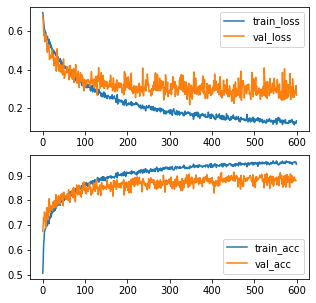

In [35]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot(2,1,1)
ax1.plot(history['loss'], label='train_loss')
ax1.plot(history['val_loss'][1:], label='val_loss')
ax1.legend()
ax2 = plt.subplot(2,1,2)
ax2.plot(history['acc'], label='train_acc')
ax2.plot(history['val_acc'][1:], label='val_acc')
ax2.legend()
plt.savefig('metrics.png')

In [37]:
if os.path.exists('logs'):
    checkpoint = torch.load('logs')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    print('Restore model at epoch - ', epoch)

test_acc = []
test_loss = []
for batch_idx, data in enumerate(validation_loader):

    img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
    img0, img1 , labels = img0.to(device), img1.to(device) , labels.to(device)#move to GPU

    logits = model(img0, img1)
    loss = F.cross_entropy(logits, labels, reduction = 'sum')/len(img0)

    test_loss.append(loss.item())
    _, preds = torch.max(logits, 1)
    total = len(labels)
    correct = torch.sum(preds==labels)
    test_acc.append(correct.item()/total)  

t_loss = np.mean(test_loss)
t_acc = np.mean(test_acc)
print('Test Loss: {:.4f}, Test Accuracy: {:.3f}'.format(t_loss,  t_acc))


Restore model at epoch -  348


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:234: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Test Loss: 0.3016, Test Accuracy: 0.871


len of iestidx -  256
completed computing score matrix
[0.4453125  0.52734375 0.5546875  0.609375   0.63671875 0.6640625
 0.6796875  0.71875    0.7265625  0.7421875  0.75       0.765625
 0.76953125 0.7734375  0.7890625  0.796875   0.80078125 0.80859375
 0.8125     0.81640625 0.82421875 0.83984375 0.8515625  0.85546875
 0.86328125 0.8671875  0.8671875  0.87109375 0.87890625 0.88671875
 0.89453125 0.90234375 0.91015625 0.9140625  0.921875   0.92578125
 0.92578125 0.92578125 0.92578125 0.9296875  0.9296875  0.9296875
 0.93359375 0.93359375 0.93359375 0.94140625 0.94140625 0.94140625
 0.94921875 0.94921875 0.94921875 0.94921875 0.94921875 0.94921875
 0.94921875 0.953125   0.95703125 0.95703125 0.95703125 0.95703125
 0.95703125 0.95703125 0.96484375 0.96484375 0.96484375 0.96484375
 0.96484375 0.96484375 0.96484375 0.96484375 0.96484375 0.96484375
 0.96484375 0.96875    0.97265625 0.97265625 0.9765625  0.98046875
 0.98046875 0.98046875 0.984375   0.984375   0.984375   0.984375
 0.984375   0

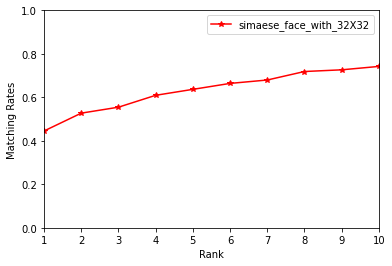

In [46]:

import matplotlib.lines as mlines

def cmc2(distmat, query_ids=None, gallery_ids=None,
        query_cams=None, gallery_cams=None, topk=100,
        separate_camera_set=False,
        single_gallery_shot=False,
        first_match_break=False):
    distmat = np.array(distmat)
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
#     print(m,n)
    indices = np.argsort(-distmat, axis=1)
#     print(indices)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute CMC for each query
    ret = np.zeros(topk)
    num_valid_queries = 0
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        if separate_camera_set:
            # Filter out samples from same camera
            valid &= (gallery_cams[indices[i]] != query_cams[i])
        if not np.any(matches[i, valid]): continue
        if single_gallery_shot:
            repeat = 10
            gids = gallery_ids[indices[i][valid]]
            print(gids)
            inds = np.where(valid)[0]
            ids_dict = defaultdict(list)
            for j, x in zip(inds, gids):
                ids_dict[x].append(j)
        else:
            repeat = 1
        for _ in range(repeat):
            if single_gallery_shot:
                # Randomly choose one instance for each id
                sampled = (valid & 1)#_unique_sample(ids_dict, len(valid)))
                index = np.nonzero(matches[i, sampled])[0]
            else:
                index = np.nonzero(matches[i, valid])[0]
            delta = 1. / (len(index) * repeat)
            for j, k in enumerate(index):
                if k - j >= topk: break
                if first_match_break:
                    print('I am here')
                    ret[k - j] += 1
                    break
                ret[k - j] += delta
        num_valid_queries += 1
    if num_valid_queries == 0:
        raise RuntimeError("No valid query")
    return ret.cumsum() / num_valid_queries

default_color = ['r','g','b','c','m','y','orange','brown']
default_marker = ['*','o','s','v','X','*','.','P']

class CMC:
    def __init__(self,cmc_dict, color=default_color, marker = default_marker, name = None):
        self.color = color
        self.marker = marker
        self.cmc_dict = cmc_dict
        self.name = name
        
    def plot(self,title,rank=10, xlabel='Rank',ylabel='Matching Rates',show_grid=True):        
        fig, ax = plt.subplots()
        fig.suptitle(title)
        x = list(range(1, rank+1, 1))
        plt.ylim(0, 1.0)
        plt.xlim(1, rank)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(x)
        plt.grid(show_grid)

        method_name = []
        i = 0
        for name in self.cmc_dict.keys():
            if rank < len(self.cmc_dict[name]):
                temp_cmc = self.cmc_dict[name][:rank]
                r = list(range(1, rank+1))
            else:
                temp_cmc = self.cmc_dict[name]
                r = list(range(1, len(temp_cmc)+1))
                
            if name == list(self.cmc_dict.keys())[-1]:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[0], marker=self.marker[0], label= name)
            else:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[i+1], marker=self.marker[i+1], label=name)
                i = i+1
            ax.add_line(globals()[name])
            method_name.append(globals()[name])

        plt.legend(handles=method_name)
        plt.savefig(self.name)
        #plt.show()
    
    def save(self, title, filename, 
             rank=20, xlabel='Rank',
             ylabel='Matching Rates (%)', show_grid=True,
             save_path=os.getcwd(), format='png', **kwargs):
        fig, ax = plt.subplots()
        fig.suptitle(title)
        x = list(range(0, rank+1, 5))
        plt.ylim(0, 1.0)
        plt.xlim(1, rank)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(x)
        plt.grid(show_grid)

        method_name = []
        i = 0
        for name in self.cmc_dict.keys():
            if rank < len(self.cmc_dict[name]):
                temp_cmc = self.cmc_dict[name][:rank]
                r = list(range(1, rank+1))
            else:
                temp_cmc = self.cmc_dict[name]
                r = list(range(1, len(temp_cmc)+1))
                
            if name == list(self.cmc_dict.keys())[-1]:
                globals()[name] = mlines.Line2D(r, temp_cmc, color='r', marker='*', label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
            else:
                globals()[name] = mlines.Line2D(r, temp_cmc, color=self.color[i], marker=self.marker[i], label='{:.1f}% {}'.format(self.cmc_dict[name][0]*100, name))
                i = i+1
            ax.add_line(globals()[name])
            method_name.append(globals()[name])

        plt.legend(handles=method_name)
        plt.show()

def score(img1,img2):

    image1 = cv2.imread(img1)
    image1 = cv2.resize(image1, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB).astype(float)
    image1 = val_transform(image=image1)['image']/255
    image1 = torch.reshape(image1, (1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)).float().cuda()
    image2 = cv2.imread(img2)
    image2 = cv2.resize(image2, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB).astype(float)
    image2 = val_transform(image=image2)['image']/255.
    image2 = torch.reshape(image2, (1,3, IMAGE_HEIGHT, IMAGE_WIDTH)).float().cuda()
    out = model(image1, image2)

    return out[0][1].item()

    
test_idx = np.arange(0,256)
print('len of iestidx - ', len(test_idx))


score_matrix=np.zeros((256,256))
for i in range(len(test_idx)):
    img1=random.choice(test_list[i])
    for j in range(len(test_idx)):
        img2=random.choice(test_list[j])
        score_matrix[i][j]=score(img1,img2)
        #print(score_matrix[i][j])
print('completed computing score matrix')
#calculating cmc score
cmc_score=cmc2(score_matrix,gallery_ids=test_idx,query_ids=test_idx, topk = 256)
print(cmc_score)
np.save('cmc_score1', cmc_score)
cmc_dict ={

'simaese_face_with_32X32': cmc_score,
}
curve=CMC(cmc_dict, name = 'Siamese_face_32X32_torch_cmc')
curve.plot(title = "", show_grid=False)